# My First Attempt at Data Science and Machine Learning on NFL data (on my own!)

Hi! If you're reading this notebook, then you're about to go into **my first personal project** and you'll review my little experimentation and usage of some **Data Science and Machine Learning** skills I've been learning for the past few months.  

What I'm attempting on this notebook comprises quite a few steps, which I'll detail right below.

Firstly, I'll use **Kaggle API** functions to download a dataset to my local device, and then load this data as a **Pandas DataFrame** for analysis.

Then, I'll perform quite a few **data wrangling** steps and apply a few custom functions to transform the dataset in question to a format I like. This includes just a few visuals which I'll explain throughout the notebook, but nothing incredibly detailed.

After this, I'll use the transformed data to train a **Machine Learning model** and tune it to the best possible parameters. I'll assess the quality of the model against a test set to see its performance.

Finally, I'll extract new data to pass it through the created ML model and see how accurate it is to predict the outcomes of unseen data, once the model is re-trained with the full initial dataset.  

I do want to make some *caveats* on this exercise, given it is my first time doing something like this (and actually publishing it to the wide world):

1. This project was done completely for pure fun and to practice my Python, Data Science, and Machine Learning potential. The outcome of this notebook has no commercial or scientific purpose (at least not yet, in which case I'll probably do something a bit more methodical and formal).
2. I do not own the data. I've used two separate Kaggle datasets for this project, which are in no way related.
3. There were quite a few back-and-forth moments throughout this project, but I'm not including all of those here to avoid bulking up the notebook too much.
4. I'm only documenting a single approach on this notebook; however, the different approaches that can be taken in this train of thought are of curiosity to me too, and I may attempt those in the short-term future.
5. I'm conscious there might be simpler or more efficient ways to tackle this project, either method-wise or code-wise. I do want to learn all of those tips and tricks, so please feel more than welcome to suggest them! This does not include things like sources to get the data more easily or related topics, as it was part of my self-imposed challenge to handle this data.

Now that these are out of the way, without further ado, I hope you enjoy reading through this and thank you very much for checking this out!

## So...what's this project about anyway?

Glad you asked! What I attempted to do here was to look at NFL play-by-play data between the 2009 and 2018 season. This is portraying the scenario that this is *"the only existing dataset between those seasons"*.  
If that were to be the case, I would have to sweep through the data to wrangle it in a way where I can find out a few things:

1. Which team won each game played between those years?
2. What did the box score look like for each game, including every possible extractable statline out of such dataset?
3. Could this dataset work to build a model that can predict the outcome of any other NFL game played after 2018?

Given this as the scenario, my goal through this project contained a few steps:

- Transform the data to obtain boxscores and determine the winner of every game between 2009 and 2018.
- Create a function that is able to search the boxscore of any game played between those years.
- Create a function that is able to summarise season-by-season data for one team.
- Use the transformed dataset to train a predictive model and evaluate its accuracy.
- Fit the trained model with new data from years 2019 and later to determine how accurately this model can predict the outcome of every game.

The model I'm looking to analyse is a **Decision Tree Classifier** that will determine, based on the training features, whether there will be a winner in the game (and who it would be, between the home and away teams), or if the game ends up in a tie (which is extremely unusual and improbable in the NFL).

*NB: Maybe at some point in later I'll attempt to compare this model a Logistic Regression and see how it fares up, but I went with a Decision Tree since it seemed like a relatively simple option for this case.*

## 1. Installing and importing all packages and first dataset

Right! Hands on deck now (or shall I say hands on keyboard...?)

The first thing I will do is installing and importing the packages I will use throughout this project. I'll start with installing the Kaggle package, which has a function to connect to their API and download any dataset in their site to my local device.

This step is simple with the help of the *pip* installer:

In [1]:
%pip install kaggle

Note: you may need to restart the kernel to use updated packages.


Great! Now that I have the Kaggle package installed, I can then import such package, as well as a set of other packages, including the classics - NumPy, Pandas, Matplotlib, Seaborn, Scikit-Learn, etc.

In [2]:
# Importing all packages and functions
import kaggle
from kaggle.api.kaggle_api_extended import KaggleApi
import requests
from tqdm import tqdm
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix,\
ConfusionMatrixDisplay, roc_auc_score, precision_score, recall_score, f1_score,\
jaccard_score, roc_curve, auc

import warnings
warnings.filterwarnings('ignore') # To disable warnings along the notebook

Now that all the packages are imported, the fun begins!

First things first, we need to download the dataset in order to load it as a DataFrame. To do this, I'll create a Kaggle API instance, authenticate my API key (which is stored as a .json file in my local machine), and use some of the methods of the Kaggle API instance to search and download the datasets used in this project.

In case you're interested in learning more about the Kaggle API package, [here's the link!](https://github.com/Kaggle/kaggle-api)

In [3]:
# Creating a KaggleApi instance and authenticating API credentials
kaggle = KaggleApi()
kaggle.authenticate()

After authenticating the credentials, I'll now use the *.dataset_list* method to search for datasets related to the NFL:

In [4]:
# Searching for Kaggle datasets related to the NFL
kaggle.dataset_list(search='NFL')

[kendallgillies/nflstatistics,
 tobycrabtree/nfl-scores-and-betting-data,
 nickcantalupa/nfl-team-data-2003-2023,
 maxhorowitz/nflplaybyplay2009to2016,
 robikscube/helmet-assignment-helpers,
 zynicide/nfl-football-player-stats,
 timoboz/superbowl-history-1967-2020,
 washingtonpost/nfl-arrests,
 rishabjadhav/nfl-passing-statistics-2001-2023,
 sujaykapadnis/nfl-stadium-attendance-dataset,
 mattop/2022nfl-team-offense,
 frlemarchand/nfl-player-numbers,
 toddsteussie/nfl-play-statistics-dataset-2004-to-present,
 its7171/nfl-models,
 ulrikthygepedersen/nfl-draft-1985-2015,
 maxhorowitz/nflplaybyplay2015,
 dtrade84/nfl-offensive-stats-2019-2022,
 savvastj/nfl-combine-data,
 its7171/nfl-lib,
 philiphyde1/nfl-stats-1999-2022]

The output of this search is a list of strings with the format *"owner/dataset"*, returning the first 20 results.

Although there are plenty more NFL datasets on Kaggle, the one that I'm looking for is right within these results - the ***"maxhorowitz/nflplaybyplay2009to2016"***.

This dataset contains 3 CSV files - one for play-by-play data between 2009 and 2016, a similar one also including the 2017 season, and finally, a third one including the 2018 season.

Something peculiar about these 3 datasets is that the 2009-to-2018 play-by-play dataset is different than the other two. The first two datasets have 102 columns, while the latter is further expanded to 255 columns, most of them being basically dummy columns (i.e. containing only binary values, either 0s or 1s). This is the dataset I will focus the rest of my work on throughout this project.

To get the CSV file in question, I'll use the *.dataset_download_cli* method on the Kaggle API object to find this dataset, unzip the contents and download it to my local machine. The *force* argument is set to True, so that the file replaces itself, in case it was already downloaded before.

In [5]:
# Downloading the dataset to the local machine and extracting the contents
kaggle.dataset_download_cli(dataset='maxhorowitz/nflplaybyplay2009to2016',
                            unzip=True, force=True)

Dataset URL: https://www.kaggle.com/datasets/maxhorowitz/nflplaybyplay2009to2016
License(s): unknown


100%|██████████| 274M/274M [01:08<00:00, 4.20MB/s] 


Excellent! Now that the contents are downloaded to the local machine, I'll just save the CSV file name in a variable and load the dataset as a Pandas DataFrame:

In [6]:
# Setting the output to display all columns on the dataset
pd.set_option('display.max_columns', None)

# Loading the file name as a variable
csv = "NFL Play by Play 2009-2018 (v5).csv"

# Loading the dataset as a DataFrame
df = pd.read_csv(csv)
df.head()

play_id     game_id home_team away_team posteam posteam_type defteam  \
0       46  2009091000       PIT       TEN     PIT         home     TEN   
1       68  2009091000       PIT       TEN     PIT         home     TEN   
2       92  2009091000       PIT       TEN     PIT         home     TEN   
3      113  2009091000       PIT       TEN     PIT         home     TEN   
4      139  2009091000       PIT       TEN     PIT         home     TEN   

  side_of_field  yardline_100   game_date  quarter_seconds_remaining  \
0           TEN          30.0  2009-09-10                      900.0   
1           PIT          58.0  2009-09-10                      893.0   
2           PIT          53.0  2009-09-10                      856.0   
3           PIT          56.0  2009-09-10                      815.0   
4           PIT          56.0  2009-09-10                      807.0   

   half_seconds_remaining  game_seconds_remaining game_half  quarter_end  \
0                  1800.0                  3600.0     Half1            0   
1                  1793.0                  3593.0     Half1            0   
2                  1756.0                  3556.0     Half1            0   
3                  1715.0                  3515.0     Half1            0   
4                  1707.0                  3507.0     Half1            0   

   drive  sp  qtr  down  goal_to_go   time   yrdln  ydstogo  ydsnet  \
0      1   0    1   NaN         0.0  15:00  TEN 30        0       0   
1      1   0    1   1.0         0.0  14:53  PIT 42       10       5   
2      1   0    1   2.0         0.0  14:16  PIT 47        5       2   
3      1   0    1   3.0         0.0  13:35  PIT 44        8       2   
4      1   0    1   4.0         0.0  13:27  PIT 44        8       2   

                                                desc play_type  yards_gained  \
0  R.Bironas kicks 67 yards from TEN 30 to PIT 3....   kickoff           0.0   
1  (14:53) B.Roethlisberger pass short left to H....      pass           5.0   
2  (14:16) W.Parker right end to PIT 44 for -3 ya...       run          -3.0   
3  (13:35) (Shotgun) B.Roethlisberger pass incomp...      pass           0.0   
4  (13:27) (Punt formation) D.Sepulveda punts 54 ...      punt           0.0   

   shotgun  no_huddle  qb_dropback  qb_kneel  qb_spike  qb_scramble  \
0        0          0          0.0         0         0            0   
1        0          0          1.0         0         0            0   
2        0          0          0.0         0         0            0   
3        1          0          1.0         0         0            0   
4        0          0          0.0         0         0            0   

  pass_length pass_location  air_yards  yards_after_catch run_location  \
0         NaN           NaN        NaN                NaN          NaN   
1       short          left       -3.0                8.0          NaN   
2         NaN           NaN        NaN                NaN        right   
3        deep         right       34.0                NaN          NaN   
4         NaN           NaN        NaN                NaN          NaN   

  run_gap field_goal_result  kick_distance extra_point_result  \
0     NaN               NaN           67.0                NaN   
1     NaN               NaN            NaN                NaN   
2     end               NaN            NaN                NaN   
3     NaN               NaN            NaN                NaN   
4     NaN               NaN           54.0                NaN   

  two_point_conv_result  home_timeouts_remaining  away_timeouts_remaining  \
0                   NaN                        3                        3   
1                   NaN                        3                        3   
2                   NaN                        3                        3   
3                   NaN                        3                        3   
4                   NaN                        3                        3   

   timeout timeout_team td_t

## 2. Exploring the dataset

With the dataset loaded, now it's time to clean and prepare the data!

The first thing to do is to check the size of the dataset:

In [7]:
df.shape

(449371, 255)

Not surprisingly, given we have 10 seasons of play-by-play data in this dataset, this translates to almost 450,000 rows of data and 255 columns.

It looks like the *play_id* column is the unique identifier for each row. Similarly, *game_id* identifies each unique game found in this dataset.

In an attempt to avoid any potential play duplicates, I will first check how many potential rows in this dataset are containing the same data, subsetted by both of these ID columns:

In [8]:
# Returning the number of duplicate pairs of 'play_id' and 'game_id'
len(df[df.duplicated(subset=['play_id', 'game_id'])])

2437

These rows will likely skew some of the analysis done in later steps, so I'll just proceed to remove them from the dataset (being mindful of resetting the index numbers as well!):

In [9]:
# Removing duplicate rows from the dataset and resetting the index
df = df.drop_duplicates(subset=['play_id', 'game_id']).reset_index(drop=True)

Now, let's just get some quick insights on the dataset, particularly the column types, any null values, and summary statistics for numerical columns:

In [10]:
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 446934 entries, 0 to 446933
Data columns (total 255 columns):
 #    Column                                Non-Null Count   Dtype  
---   ------                                --------------   -----  
 0    play_id                               446934 non-null  int64  
 1    game_id                               446934 non-null  int64  
 2    home_team                             446934 non-null  object 
 3    away_team                             446934 non-null  object 
 4    posteam                               433783 non-null  object 
 5    posteam_type                          434145 non-null  object 
 6    defteam                               434145 non-null  object 
 7    side_of_field                         446335 non-null  object 
 8    yardline_100                          433954 non-null  float64
 9    game_date                             446934 non-null  object 
 10   quarter_seconds_remaining             446794 non-null 

In [11]:
df.describe()

play_id       game_id   yardline_100  quarter_seconds_remaining  \
count  446934.000000  4.469340e+05  433954.000000              446794.000000   
mean     2141.319971  2.013596e+09      49.813743                 414.027691   
std      1240.735337  2.830785e+06      25.065600                 279.121722   
min        35.000000  2.009091e+09       1.000000                   0.000000   
25%      1074.000000  2.011111e+09      31.000000                 152.000000   
50%      2126.000000  2.013123e+09      52.000000                 397.000000   
75%      3181.000000  2.016102e+09      71.000000                 656.000000   
max      5706.000000  2.018122e+09      99.000000                 900.000000   

       half_seconds_remaining  game_seconds_remaining    quarter_end  \
count           446771.000000           446774.000000  446934.000000   
mean               810.867285             1700.571179       0.017079   
std                554.666991             1053.624246       0.129564   
min                  0.000000                0.000000       0.000000   
25%                286.000000              784.000000       0.000000   
50%                797.000000             1800.000000       0.000000   
75%               1288.000000             2583.000000       0.000000   
max               1800.000000             3600.000000       1.000000   

               drive             sp            qtr           down  \
count  446934.000000  446934.000000  446934.000000  379403.000000   
mean       12.282780       0.072033       2.577944       2.000169   
std         7.129246       0.258543       1.130098       1.005771   
min         1.000000       0.000000       1.000000       1.000000   
25%         6.000000       0.000000       2.000000       1.000000   
50%        12.000000       0.000000       3.000000       2.000000   
75%        18.000000       0.000000       4.000000       3.000000   
max        38.000000       1.000000       5.000000       4.000000   

          goal_to_go        ydstogo         ydsnet   yards_gained  \
count  434316.000000  446934.000000  446934.000000  446721.000000   
mean        0.050323       7.304139      27.281675       3.901520   
std         0.218610       4.877987      25.578440       7.881385   
min         0.000000       0.000000     -87.000000     -38.000000   
25%         0.000000       3.000000       5.000000       0.000000   
50%         0.000000       9.000000      21.000000       0.000000   
75%         0.000000      10.000000      46.000000       6.000000   
max         1.000000      50.000000      99.000000      99.000000   

             shotgun      no_huddle    qb_dropback       qb_kneel  \
count  446934.000000  446934.000000  434150.000000  446934.000000   
mean        0.401576       0.067260       0.442808       0.008558   
std         0.490218       0.250473       0.496719       0.092115   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         1.000000       0.000000       1.000000       0.000000   
max         1.000000       1.000000       1.000000       1.000000   

            qb_spike    qb_scramble      air_yards  yards_after_catch  \
count  446934.000000  446934.000000  174772.000000      108257.000000   
mean        0.001591       0.015537       8.317551           5.214083   
std         0.039854       0.123675      10.096512           7.231648   
min         0.000000       0.000000     -70.000000         -81.000000   
25%         0.000000       0.000000       2.000000           1.000000   
50%         0.000000       0.000000       6.000000           3.000000   
75%         0.000000       0.000000      13.000000           7.000000   
max         1.000000       1.000000      84.000000          90.000000   

       kick_distance  home_timeouts_remaining  away_timeouts_remaining  \
count   50460.000000            446934.000000

Okay, we have some reference information now!

It is quite a heavy dataset at 870 MB of memory usage, and as expected, most columns are either integer or float-type columns, given their dummy behaviour. The basic important columns (key ID columns, team details, etc.) seem to be intact, but most columns seem to have at least 1 empty cell.

Given the size of the dataset, strategies such as removing rows (based on particular columns) with blank cells may not be a bad idea, but I'll abstain from removing any rows for now.

As far as the summary statistics go, there are some things we can start validating straight away to confirm that some columns seem to be in good shape. For example, the *yardline_100* indicates the yardline where each play starts. As we know, a football field has 100 yards, and each positive-yardage play must be at least of 1 yard, which indicates that the maximum yardline where a play can start is the **99** yardline (or the opposing team's own 1 yardline, from the perspective of a team playing on offense).

Each quarter has 15:00 mins of duration, which translates to 900 seconds, as is the maximum value found on the *quarter_seconds_remaining* column. Same case for the duration of a half (2 quarters) and a whole game (4 quarters).

It also looks like the biggest play (or plays) on this dataset were effective for a 99-yard gain! And the longest pass recorded throughout this time had 84 total air yards! I wonder which quarterback that was!

Anyway, more to do so let's keep going! One thing I'll do first is to convert the *game_date* column to a datetime column, and then double-check that there are no resulting missing values from it:

In [12]:
# Converting game_date to datetime type
df['game_date'] = pd.to_datetime(df['game_date'], errors='coerce')

# Checking the game_date type and missing value
print(df[['game_date']].dtypes)
print(df['game_date'].isnull().sum())

game_date    datetime64[ns]
dtype: object
0


Next, the *game_half* column seems to be of object type instead of numeric. This is because the values found on this column seem to be "Half1", "Half2", and "Overtime".

I'll proceed to convert these values to numbers by stripping the "Half" string out of the 2 halfs, and replacing "Overtime" for a "3" (let's assume it as a 3rd half for this case):

In [13]:
# Transforming the game_half column to float
df['game_half'] = df['game_half'].str.replace('Half','').replace('Overtime','3').astype(float)

Let's do a few more transformations!

One thing to consider is that, since 2009, a few teams have been relocated to other cities, and this might cause the appearance of a few teams twice within the dataset. For example, the former Oakland Raiders (OAK) and St. Louis Rams (STL) were relocated to Las Vegas (LV) and Los Angeles (LAR) respectively. Same case with the San Diego Chargers (SD), which also relocated to Los Angeles (LAC).

Additionally, Jacksonville seems to show up in two different ways in the dataset - as JAC and JAX.

Let's fix this before proceeding any further:

In [14]:
# Looping through all team columns to replace the team abbreviations
for col in df[['home_team','away_team','posteam','defteam']].columns.tolist():
    df[col] = df[col].str.replace('SD', 'LAC').replace('JAC', 'JAX')\
    .replace('STL', 'LAR').replace('LA', 'LAR').replace('OAK','LV')

# Checking all teams are correctly identified to present date
print(df['home_team'].unique())
print(len(df['home_team'].unique()))
print(df['away_team'].unique())
print(len(df['away_team'].unique()))

['PIT' 'CLE' 'NO' 'TB' 'HOU' 'IND' 'CIN' 'CAR' 'BAL' 'ATL' 'ARI' 'SEA'
 'NYG' 'GB' 'NE' 'LV' 'DET' 'WAS' 'TEN' 'PHI' 'NYJ' 'KC' 'JAX' 'SF' 'BUF'
 'LAC' 'DEN' 'CHI' 'DAL' 'MIA' 'MIN' 'LAR']
32
['TEN' 'MIN' 'DET' 'DAL' 'NYJ' 'JAX' 'DEN' 'PHI' 'KC' 'MIA' 'SF' 'LAR'
 'WAS' 'CHI' 'BUF' 'LAC' 'CAR' 'HOU' 'NO' 'NE' 'LV' 'ARI' 'CIN' 'SEA' 'TB'
 'BAL' 'CLE' 'PIT' 'NYG' 'IND' 'ATL' 'GB']
32


Excellent! We can now see there are effectively 32 distinct team abbreviations, both in the *home_team* and *away_team* columns. This is accurate with the NFL current list of teams!

Let's move further with more exploring and transformations. Interestingly, from the column information displayed in previous steps, the *down* column seems to have a significant amount of null values, which is unusual...

I'll explore what's going on here by having a look at the filtered dataset for rows where the *down* column is null, and checking against the *play_type* value counts:

In [15]:
# Subsetting the dataset for null down values
df_null_downs = df[df['down'].isnull()]

# Value counts of all play_type values in the subset
df_null_downs['play_type'].value_counts()

play_type
kickoff        25401
no_play        18210
extra_point    10859
pass             500
run              171
qb_kneel          77
field_goal         1
Name: count, dtype: int64

That explains most of it! In NFL games, special teams plays such as kickoffs and extra points (PATs), there isn't an actual "down" to play, which is why these values would be empty.

To avoid any issues from these missing values, I'll just replace them with zeros:

In [16]:
# Replacing null down values with zeros
df['down'] = df['down'].fillna(0)
print(df['down'].value_counts())

# Confirming no null values are found on down
print(df['down'].isnull().sum())

down
1.0    152411
2.0    113971
3.0     73567
0.0     67531
4.0     39454
Name: count, dtype: int64
0


All cleaned! Let's now do some work on the *play_type* column. A similar approach like with the *down* column:

In [17]:
# Checking the value counts in the play_type column
df['play_type'].value_counts()

play_type
pass           185663
run            131972
no_play         42221
kickoff         25401
punt            23815
extra_point     10859
field_goal       9725
qb_kneel         3811
qb_spike          683
Name: count, dtype: int64

In [18]:
# Checking null values in the play_type column
df['play_type'].isnull().sum()

12784

After doing some digging on what could be related to the null values found in the *play_type* column, by analysing the *desc* (description) column there is a potential cause for this - most of the plays where the *play_type* is null are paired up with ends of quarter, half, or game, happening at the time of that play, as well as the 2-minute warning, which happens when there are 2 minutes remaining in the 2nd or 4th quarter:

In [19]:
# Subsetting for null play_type values
df_null_playtypes = df[df['play_type'].isnull()]

# Checking the value counts of the desc column
df_null_playtypes['desc'].value_counts()

desc
Two-Minute Warning                                                                                                                                                                                                                                     4180
END GAME                                                                                                                                                                                                                                               2090
END QUARTER 3                                                                                                                                                                                                                                          2083
END QUARTER 1                                                                                                                                                                                                                                  

In lesser volume, there are also plays where one team took a timeout before the play started. Finally, there's the plays where offsetting penalties took place. For further explanation, offsetting penalties occur when a player of both teams commits a penalty during a play, which results in the penalties "cancelling each other" (hence the offsetting), and the down being repeated, which means such play never counted.

In an attempt to fill in these null values for the *play_type* column, I'll use the *desc* column as a reference. I'll extract each play description and split them into a list of words, converted to lowercase. Then, if there's the presence of the words corresponding to each of the scenarios mentioned above, I'll fill the play type in that row with its respective value:

In [20]:
# Filling in play_type values based on desc
for i, v in enumerate(df['desc']):
    if pd.isna(df.loc[i, 'play_type']):
        desc = str(v).strip().lower().split()
        if set(desc).issuperset(['two-minute', 'warning']):
            df.loc[i, 'play_type'] = '2_min_warning'
        elif set(desc).issuperset(['end', 'game']):
            df.loc[i, 'play_type'] = 'end_game'
        elif set(desc).issuperset(['end', 'quarter']):
            df.loc[i, 'play_type'] = 'end_qtr'
        elif set(desc).issuperset(['end', 'half']):
            df.loc[i, 'play_type'] = 'end_half'
        elif set(desc).issuperset(['blank', 'play']):
            df.loc[i, 'play_type'] = 'unknown'
        elif set(desc).issuperset(['no', 'play']):
            df.loc[i, 'play_type'] = 'no_play'
        elif set(desc).issuperset(['game', 'resumed']):
            df.loc[i, 'play_type'] = 'no_play'
        elif 'timeout' in desc:
            df.loc[i, 'play_type'] = 'timeout'

In [21]:
# Checking null values on play_type
df['play_type'].isnull().sum()

508

Quite a huge reduction of null values! About 12,000 values were now replaced with a respective play type.

There are other methods to do this step, though. Perhaps my method wasn't necessarily the most efficient...(and I just thought of them after giving the dataset a second look)

For example, we'll find that most plays where a 2-minute warning happened will have the *quarter_seconds_remaining* column at 120 seconds (2 minutes) on the 2nd and 4th *qtr*. Similarly, most plays where the quarter ended will have a value of 1 on the *quarter_end* column, and if the *qtr* is 4, then that would mean the end of the game too.

The important part is, though, that most of these values were replaced by the *desc* method, and the number of plays remaining with blank play types are pretty insignificant, compared to the size of the dataset, giving a likelihood that it will not skew further analysis steps.

Notwithstanding, we'll proceed to fill the remaining 508 null values with an *'unknown'* tag:

In [22]:
# Filling in the rest of play_type null values
df['play_type'].fillna('unknown', inplace=True)

# Checking that the play_type column is free of null values
df['play_type'].isnull().sum()

0

Now, I'll also insert a new column next to the *game_date* column to indicate the **season**. Almost all NFL seasons start roughly at the beginning of September every year, and finish right before or right after the start of the following year. There have been occasions where the NFL season started in late August though, including the 2008 season which started on August 28th. This is due to Labor Day sometimes being on the first 2 days of September.

To insert this column, I'll use the month found on each play from the dataset. If the month is higher than (or potentially equal to) August, then the season will take the value of the year found on such date. However, given that some regular season games can happen in January of the following year, these are still part of the same season; therefore, for games that happen outside of August-December, the year needs to be reduced by 1:

In [23]:
# Inserting a season column next to game_date
df.insert(10, 'season', df['game_date'].apply(
    lambda x: x.year if x.month >= 8 else x.year - 1
))

# Checking the season value counts
df['season'].value_counts()

season
2015    46129
2016    45556
2014    45502
2013    45248
2012    45242
2017    45241
2011    45022
2010    44751
2009    44596
2018    39647
Name: count, dtype: int64

We can see that roughly all seasons had somewhere between 44,000 and 46,000 plays in total, except for the 2018 season...wonder why that's the case?

Let's check the date of the last registered game in this dataset:

In [24]:
# Checking the last game date in the dataset
df['game_date'].max()

Timestamp('2018-12-17 00:00:00')

Since the last date found in the dataset is December 17^th^ 2018, it means that the dataset does not contain all 2018 season games. This corresponds to the end of Week 15 that season, where the Philadelphia Eagles beat the Los Angeles Rams 30-23. The 2018 season (and the rest of seasons in the dataset) had 17 weeks played, so we're missing 2 weeks of this season. Not to worry though, it will not affect the rest of our analysis, so let's move on!

Finally, I'll insert another new column to the dataset that computes the amount of time elapsed between plays, and I'll call it *play_duration*. This column will help us calculate the time of possession for each team in each game. Bear in mind though, this is not the same as the actual duration of each play. As a high-level estimation, each executed play could take anywhere between 3 to 10 seconds on average. However, if the clock keeps running between the end of one play and the start of the next play, this is also computed in the time of possession for that team, which is what we ultimately want to calculate.

To do this, I'll first re-order the columns by both the *game_id* (which is a sequential number composed by the game date and the game number in that day, unique for every game), and the *play_id* column (which is a sequential number indicating the play unique identifier). By sorting the dataset in ascending order of *game_id* and *play_id*, we will obtain a sorted dataset in which each row's next row is the play after such play, which will help us calculate the difference between the seconds remaining at the start of one play and the seconds remaining on the play after, resulting in the time elapsed between both plays.

In [25]:
# Sorting the dataset by game_id and game_seconds_remaining
df = df.sort_values(by=['game_id', 'play_id'],
                    ascending=[True, True]).reset_index(drop=True)
df.head()

play_id     game_id home_team away_team posteam posteam_type defteam  \
0       46  2009091000       PIT       TEN     PIT         home     TEN   
1       68  2009091000       PIT       TEN     PIT         home     TEN   
2       92  2009091000       PIT       TEN     PIT         home     TEN   
3      113  2009091000       PIT       TEN     PIT         home     TEN   
4      139  2009091000       PIT       TEN     PIT         home     TEN   

  side_of_field  yardline_100  game_date  season  quarter_seconds_remaining  \
0           TEN          30.0 2009-09-10    2009                      900.0   
1           PIT          58.0 2009-09-10    2009                      893.0   
2           PIT          53.0 2009-09-10    2009                      856.0   
3           PIT          56.0 2009-09-10    2009                      815.0   
4           PIT          56.0 2009-09-10    2009                      807.0   

   half_seconds_remaining  game_seconds_remaining  game_half  quarter_end  \
0                  1800.0                  3600.0        1.0            0   
1                  1793.0                  3593.0        1.0            0   
2                  1756.0                  3556.0        1.0            0   
3                  1715.0                  3515.0        1.0            0   
4                  1707.0                  3507.0        1.0            0   

   drive  sp  qtr  down  goal_to_go   time   yrdln  ydstogo  ydsnet  \
0      1   0    1   0.0         0.0  15:00  TEN 30        0       0   
1      1   0    1   1.0         0.0  14:53  PIT 42       10       5   
2      1   0    1   2.0         0.0  14:16  PIT 47        5       2   
3      1   0    1   3.0         0.0  13:35  PIT 44        8       2   
4      1   0    1   4.0         0.0  13:27  PIT 44        8       2   

                                                desc play_type  yards_gained  \
0  R.Bironas kicks 67 yards from TEN 30 to PIT 3....   kickoff           0.0   
1  (14:53) B.Roethlisberger pass short left to H....      pass           5.0   
2  (14:16) W.Parker right end to PIT 44 for -3 ya...       run          -3.0   
3  (13:35) (Shotgun) B.Roethlisberger pass incomp...      pass           0.0   
4  (13:27) (Punt formation) D.Sepulveda punts 54 ...      punt           0.0   

   shotgun  no_huddle  qb_dropback  qb_kneel  qb_spike  qb_scramble  \
0        0          0          0.0         0         0            0   
1        0          0          1.0         0         0            0   
2        0          0          0.0         0         0            0   
3        1          0          1.0         0         0            0   
4        0          0          0.0         0         0            0   

  pass_length pass_location  air_yards  yards_after_catch run_location  \
0         NaN           NaN        NaN                NaN          NaN   
1       short          left       -3.0                8.0          NaN   
2         NaN           NaN        NaN                NaN        right   
3        deep         right       34.0                NaN          NaN   
4         NaN           NaN        NaN                NaN          NaN   

  run_gap field_goal_result  kick_distance extra_point_result  \
0     NaN               NaN           67.0                NaN   
1     NaN               NaN            NaN                NaN   
2     end               NaN            NaN                NaN   
3     NaN               NaN            NaN                NaN   
4     NaN               NaN           54.0                NaN   

  two_point_conv_result  home_timeouts_remaining  away_timeouts_remaining  \
0                   NaN                        3                        3   
1                   NaN                        3                        3   
2                   NaN                        3                        3   
3                   NaN                        3                        3   
4                   NaN                        3          

In [26]:
# Creating an empty column after game_seconds_remaining
df.insert(14, 'play_duration', None)
df.head()

play_id     game_id home_team away_team posteam posteam_type defteam  \
0       46  2009091000       PIT       TEN     PIT         home     TEN   
1       68  2009091000       PIT       TEN     PIT         home     TEN   
2       92  2009091000       PIT       TEN     PIT         home     TEN   
3      113  2009091000       PIT       TEN     PIT         home     TEN   
4      139  2009091000       PIT       TEN     PIT         home     TEN   

  side_of_field  yardline_100  game_date  season  quarter_seconds_remaining  \
0           TEN          30.0 2009-09-10    2009                      900.0   
1           PIT          58.0 2009-09-10    2009                      893.0   
2           PIT          53.0 2009-09-10    2009                      856.0   
3           PIT          56.0 2009-09-10    2009                      815.0   
4           PIT          56.0 2009-09-10    2009                      807.0   

   half_seconds_remaining  game_seconds_remaining play_duration  game_half  \
0                  1800.0                  3600.0          None        1.0   
1                  1793.0                  3593.0          None        1.0   
2                  1756.0                  3556.0          None        1.0   
3                  1715.0                  3515.0          None        1.0   
4                  1707.0                  3507.0          None        1.0   

   quarter_end  drive  sp  qtr  down  goal_to_go   time   yrdln  ydstogo  \
0            0      1   0    1   0.0         0.0  15:00  TEN 30        0   
1            0      1   0    1   1.0         0.0  14:53  PIT 42       10   
2            0      1   0    1   2.0         0.0  14:16  PIT 47        5   
3            0      1   0    1   3.0         0.0  13:35  PIT 44        8   
4            0      1   0    1   4.0         0.0  13:27  PIT 44        8   

   ydsnet                                               desc play_type  \
0       0  R.Bironas kicks 67 yards from TEN 30 to PIT 3....   kickoff   
1       5  (14:53) B.Roethlisberger pass short left to H....      pass   
2       2  (14:16) W.Parker right end to PIT 44 for -3 ya...       run   
3       2  (13:35) (Shotgun) B.Roethlisberger pass incomp...      pass   
4       2  (13:27) (Punt formation) D.Sepulveda punts 54 ...      punt   

   yards_gained  shotgun  no_huddle  qb_dropback  qb_kneel  qb_spike  \
0           0.0        0          0          0.0         0         0   
1           5.0        0          0          1.0         0         0   
2          -3.0        0          0          0.0         0         0   
3           0.0        1          0          1.0         0         0   
4           0.0        0          0          0.0         0         0   

   qb_scramble pass_length pass_location  air_yards  yards_after_catch  \
0            0         NaN           NaN        NaN                NaN   
1            0       short          left       -3.0                8.0   
2            0         NaN           NaN        NaN                NaN   
3            0        deep         right       34.0                NaN   
4            0         NaN           NaN        NaN                NaN   

  run_location run_gap field_goal_result  kick_distance extra_point_result  \
0          NaN     NaN               NaN           67.0                NaN   
1          NaN     NaN               NaN            NaN                NaN   
2        right     end               NaN            NaN                NaN   
3          NaN     NaN               NaN            NaN                NaN   
4          NaN     NaN               NaN           54.0                NaN   

  two_point_conv_result  home_timeouts_remaining  away_timeouts_remaining  \
0                   NaN                        3                        3   
1                   NaN                        3                        3   
2                   NaN                        3                        3   
3                   NaN                        3   

*NB: This code may take a while to run because of the iterations across all rows in the dataset. A progress bar has been added to show the number of iterations per second, until it hits all 446,934 iterations.*

In [27]:
# Replacing None values in play_duration with actual times
for i, v in tqdm(enumerate(df['game_seconds_remaining'])):
    if i == df.index.max():
        df.loc[i, 'play_duration'] = v
    elif v >= df.loc[(i+1), 'game_seconds_remaining']:
        df.loc[i, 'play_duration'] = v - df.loc[(i+1), 'game_seconds_remaining']
    else:
        df.loc[i, 'play_duration'] = 0

# Checking the first rows of the dataset
df.head()

446934it [03:02, 2444.19it/s]


play_id     game_id home_team away_team posteam posteam_type defteam  \
0       46  2009091000       PIT       TEN     PIT         home     TEN   
1       68  2009091000       PIT       TEN     PIT         home     TEN   
2       92  2009091000       PIT       TEN     PIT         home     TEN   
3      113  2009091000       PIT       TEN     PIT         home     TEN   
4      139  2009091000       PIT       TEN     PIT         home     TEN   

  side_of_field  yardline_100  game_date  season  quarter_seconds_remaining  \
0           TEN          30.0 2009-09-10    2009                      900.0   
1           PIT          58.0 2009-09-10    2009                      893.0   
2           PIT          53.0 2009-09-10    2009                      856.0   
3           PIT          56.0 2009-09-10    2009                      815.0   
4           PIT          56.0 2009-09-10    2009                      807.0   

   half_seconds_remaining  game_seconds_remaining play_duration  game_half  \
0                  1800.0                  3600.0           7.0        1.0   
1                  1793.0                  3593.0          37.0        1.0   
2                  1756.0                  3556.0          41.0        1.0   
3                  1715.0                  3515.0           8.0        1.0   
4                  1707.0                  3507.0          11.0        1.0   

   quarter_end  drive  sp  qtr  down  goal_to_go   time   yrdln  ydstogo  \
0            0      1   0    1   0.0         0.0  15:00  TEN 30        0   
1            0      1   0    1   1.0         0.0  14:53  PIT 42       10   
2            0      1   0    1   2.0         0.0  14:16  PIT 47        5   
3            0      1   0    1   3.0         0.0  13:35  PIT 44        8   
4            0      1   0    1   4.0         0.0  13:27  PIT 44        8   

   ydsnet                                               desc play_type  \
0       0  R.Bironas kicks 67 yards from TEN 30 to PIT 3....   kickoff   
1       5  (14:53) B.Roethlisberger pass short left to H....      pass   
2       2  (14:16) W.Parker right end to PIT 44 for -3 ya...       run   
3       2  (13:35) (Shotgun) B.Roethlisberger pass incomp...      pass   
4       2  (13:27) (Punt formation) D.Sepulveda punts 54 ...      punt   

   yards_gained  shotgun  no_huddle  qb_dropback  qb_kneel  qb_spike  \
0           0.0        0          0          0.0         0         0   
1           5.0        0          0          1.0         0         0   
2          -3.0        0          0          0.0         0         0   
3           0.0        1          0          1.0         0         0   
4           0.0        0          0          0.0         0         0   

   qb_scramble pass_length pass_location  air_yards  yards_after_catch  \
0            0         NaN           NaN        NaN                NaN   
1            0       short          left       -3.0                8.0   
2            0         NaN           NaN        NaN                NaN   
3            0        deep         right       34.0                NaN   
4            0         NaN           NaN        NaN                NaN   

  run_location run_gap field_goal_result  kick_distance extra_point_result  \
0          NaN     NaN               NaN           67.0                NaN   
1          NaN     NaN               NaN            NaN                NaN   
2        right     end               NaN            NaN                NaN   
3          NaN     NaN               NaN            NaN                NaN   
4          NaN     NaN               NaN           54.0                NaN   

  two_point_conv_result  home_timeouts_remaining  away_timeouts_remaining  \
0                   NaN                        3                        3   
1                   NaN                        3                        3   
2                   NaN                        3                        3   
3                   NaN                        3   

There we have it! Looks like now we can compute the time of possession for every team thanks to this new column, which we'll attempt to do in the following sections!

## 3. Producing game boxscores

So, we've done some data wrangling and preparation steps so far, not to the point of changing the whole dataset, but significantly transforming some columns of interest. Now, let's see if we can produce some interesting aggregations!

The first thing I'll try is to produce game boxscores and see the total team stats for a single game. This means, checking things like how many plays did each team run, how many total yards they had, their yard-per-play efficiency, and some other statlines.

To start with, I'll focus solely on regular offensive plays (i.e., rushing and passing plays). We can do this with the help of the *play_type* column:

In [28]:
# Subsetting the dataset for run and pass plays
df_plays = df[df['play_type'].isin(['pass', 'run'])]
df_plays.shape

(317635, 257)

Out of almost 450,000 rows in the original dataset, more than 317,000 rows are purely rushing and passing plays that were executed and completed!

So, based on this subset, let's see if we can produce what we want - boxscores!

I'll start with the first game found on this dataset, which was the Tennessee Titans visiting the recently-crowned 2008 Super Bowl champions, the Pittsburgh Steelers, on the opening game of the 2009 season, played in September 10^th^, 2009.

In [29]:
# Extracting the plays from the first game in the original dataset
first_game = df_plays[df_plays.game_id == df_plays.game_id.min()]\
.reset_index(drop=True)

first_game.head()

play_id     game_id home_team away_team posteam posteam_type defteam  \
0       68  2009091000       PIT       TEN     PIT         home     TEN   
1       92  2009091000       PIT       TEN     PIT         home     TEN   
2      113  2009091000       PIT       TEN     PIT         home     TEN   
3      162  2009091000       PIT       TEN     TEN         away     PIT   
4      183  2009091000       PIT       TEN     TEN         away     PIT   

  side_of_field  yardline_100  game_date  season  quarter_seconds_remaining  \
0           PIT          58.0 2009-09-10    2009                      893.0   
1           PIT          53.0 2009-09-10    2009                      856.0   
2           PIT          56.0 2009-09-10    2009                      815.0   
3           TEN          98.0 2009-09-10    2009                      796.0   
4           TEN          98.0 2009-09-10    2009                      760.0   

   half_seconds_remaining  game_seconds_remaining play_duration  game_half  \
0                  1793.0                  3593.0          37.0        1.0   
1                  1756.0                  3556.0          41.0        1.0   
2                  1715.0                  3515.0           8.0        1.0   
3                  1696.0                  3496.0          36.0        1.0   
4                  1660.0                  3460.0          29.0        1.0   

   quarter_end  drive  sp  qtr  down  goal_to_go   time   yrdln  ydstogo  \
0            0      1   0    1   1.0         0.0  14:53  PIT 42       10   
1            0      1   0    1   2.0         0.0  14:16  PIT 47        5   
2            0      1   0    1   3.0         0.0  13:35  PIT 44        8   
3            0      2   0    1   1.0         0.0  13:16   TEN 2       10   
4            0      2   0    1   2.0         0.0  12:40   TEN 2       10   

   ydsnet                                               desc play_type  \
0       5  (14:53) B.Roethlisberger pass short left to H....      pass   
1       2  (14:16) W.Parker right end to PIT 44 for -3 ya...       run   
2       2  (13:35) (Shotgun) B.Roethlisberger pass incomp...      pass   
3       0  (13:16) C.Johnson up the middle to TEN 2 for n...       run   
4       4  (12:40) K.Collins pass short left to A.Hall to...      pass   

   yards_gained  shotgun  no_huddle  qb_dropback  qb_kneel  qb_spike  \
0           5.0        0          0          1.0         0         0   
1          -3.0        0          0          0.0         0         0   
2           0.0        1          0          1.0         0         0   
3           0.0        0          0          0.0         0         0   
4           4.0        0          0          1.0         0         0   

   qb_scramble pass_length pass_location  air_yards  yards_after_catch  \
0            0       short          left       -3.0                8.0   
1            0         NaN           NaN        NaN                NaN   
2            0        deep         right       34.0                NaN   
3            0         NaN           NaN        NaN                NaN   
4            0       short          left        3.0                1.0   

  run_location run_gap field_goal_result  kick_distance extra_point_result  \
0          NaN     NaN               NaN            NaN                NaN   
1        right     end               NaN            NaN                NaN   
2          NaN     NaN               NaN            NaN                NaN   
3       middle     NaN               NaN            NaN                NaN   
4          NaN     NaN               NaN            NaN                NaN   

  two_point_conv_result  home_timeouts_remaining  away_timeouts_remaining  \
0                   NaN                        3                        3   
1                   NaN                        3                        3   
2                   NaN                        3                        3   
3                   NaN                        3   

Let_see how many plays this game had first:

In [30]:
first_game.shape[0]

131

In an NFL game, you can expect an average of 60-70 plays per team, which translates to 120-140 plays. Some games will have more or less than this average depending on multiple factors; for example, did the game go to Overtime, were there lots of time stoppages during the game due to incomplete passes or turnovers, was it mostly rushing plays in-bounds which would translate on the game clock running over without any stops...and a few other possibilities.

Now, at first glance with a subset like this, it's hard to actually determine all stats from it. However, the power of DataFrame GroupBy methods and aggregations will help us produce the boxscore for this game (or at least almost every statline of it!)

Firstly, let's define the columns that will help us achieve these aggregations:

- *posteam*: Indicates the team on offense during each play.
- *drive*: Indicates the number of the game drive to which each play is part of. A drive is a series of offensive plays that result in an outcome (a touchdown, a field goal, a punt, a turnover, etc.).
- *yards_gained*: Indicates the amount of yards that each play had, either forwards or backwards.
- *rush_attempt*: A dummy column that indicates if the play was a rushing attempt.
- *pass_attempt*: Similarly, indicates if the play was a passing attempt.
- *fumble_lost*: Indicates whether the play resulted in a fumble recovered by the opposing team.
- *interception*: Indicates whether the passing attempt was intercepted by the opposing team.
- *complete_pass*: Indicates whether the passing attempt was caught and completed by the team on offense.
- *sack*: Indicates whether the passing attempt resulted in a sack by the defense.

We will also use all the columns corresponding to first, third, and fourth down attempts, to see the number of 1st downs by each down, as well as their 3rd and 4th down efficiency.

The method used to aggregate these columns is the Named Aggregations column, in which each aggregation is written with the name of the resulting column, and assigned to a tuple containing the column to aggregate, and the aggregation to perform on such column. More details of this method can be found in the following [Pandas documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html#groupby-aggregate-named).

Here's the code that will help us summarise and aggregate all these statlines:

In [31]:
# Performing all aggregations with a .groupby method and named aggregations
first_game_stats = first_game.groupby('posteam').agg(
    # Counting unique drive values per team
    drives=('drive', 'nunique'),
    # Averaging the number of plays per drive for each team
    plays_per_drive=('drive', lambda x: np.mean(pd.value_counts(x))),
    # Averaging the amount of yards gained per play
    avg_yds_per_play=('yards_gained', 'mean'),
    # Adding up the total yards gained per team
    total_yds=('yards_gained', 'sum'),
    # Subsetting for run plays and adding up total rushing yards
    rush_yds=('yards_gained', lambda x: x[first_game['play_type'] == 'run'].sum()),
    # Subsetting for pass plays and adding up total passing yards
    pass_yds=('yards_gained', lambda x: x[first_game['play_type'] == 'pass'].sum()),
    # With dummy columns, the mean equals the ratio of plays per type
    run_ratio=('rush_attempt', 'mean'),
    pass_ratio=('pass_attempt', 'mean'),
    # Counting all plays per team
    total_plays=('play_type', 'count'),
    # Adding up all rushing attempts per team
    run_plays=('rush_attempt', 'sum'),
    # Adding the total time of possession per team
    time_of_poss=('play_duration', 'sum'),
    # Average yards per rushing attempt
    yds_per_run=('yards_gained', lambda x: x[(first_game['play_type'] == 'run')].mean()),
    # Total number of fumbles lost per team
    fumbles_lost=('fumble_lost', 'sum'),
    # Adding up all passing attempts (this includes sacks)
    pass_plays=('pass_attempt', 'sum'),
    # Adding up all completed passing attempts
    completed_passes=('complete_pass', 'sum'),
    # Average yards per passing attempt
    yds_per_pass=('yards_gained', lambda x: x[(first_game['play_type'] == 'pass')].mean()),
    # Total number of interceptions thrown per team
    interceptions=('interception', 'sum'),
    # Total number of times each team's QB got sacked
    sacks=('sack', 'sum'),
    # Total yards lost in all sacks (converted to positive)
    sack_yds_lost=('yards_gained', lambda x: abs(x[first_game['sack'] == 1].sum())),
    # Total 1st downs made with rushing attempts
    run_1st_downs=('first_down_rush', 'sum'),
    # Total 1st downs made with passing attempts
    pass_1st_downs=('first_down_pass', 'sum'),
    # Total 1st downs made due to a defensive penalty
    penalty_1st_downs=('first_down_penalty','sum'),
    # Total 3rd downs made per team
    made_3rd_downs=('third_down_converted','sum'),
    # Total 3rd downs failed per team
    failed_3rd_downs=('third_down_failed','sum'),
    # Total 4th downs made per team
    made_4th_downs=('fourth_down_converted','sum'),
    # Total 4th downs failed per team
    failed_4th_downs=('fourth_down_failed','sum')
)

# Adding a few additional columns as a result of named aggregations
# Actual number of passing attempts (without sacks included)
first_game_stats['pass_attempts'] = first_game_stats['pass_plays'] - first_game_stats['sacks']
# Passing completion percentage per team
first_game_stats['completion_pct'] = first_game_stats['completed_passes'] / first_game_stats['pass_attempts']
# Total number of turnovers lost per team
first_game_stats['turnovers'] = first_game_stats['fumbles_lost'] + first_game_stats['interceptions']
# Total number of 1st downs made per team
first_game_stats['total_1st_downs'] = first_game_stats[['run_1st_downs', 'pass_1st_downs', 'penalty_1st_downs']].sum(axis=1)
# Total number of 3rd down attempts per team
first_game_stats['total_3rd_downs'] = first_game_stats[['made_3rd_downs', 'failed_3rd_downs']].sum(axis=1)
# 3rd down efficiency per team
first_game_stats['eff_3rd_down'] = first_game_stats['made_3rd_downs'] / first_game_stats['total_3rd_downs']
# Total number of 4th down attempts per team
first_game_stats['total_4th_downs'] = first_game_stats[['made_4th_downs', 'failed_4th_downs']].sum(axis=1)
# 4th down efficiency per team
first_game_stats['eff_4th_down'] = first_game_stats['made_4th_downs'] / first_game_stats['total_4th_downs']

# Ordering columns for easier readability and sequence
col_order = ['total_plays', 'total_yds', 'drives', 'time_of_poss', \
             'avg_yds_per_play', 'plays_per_drive', 'total_1st_downs', \
             'pass_1st_downs', 'run_1st_downs', 'penalty_1st_downs', \
             'made_3rd_downs', 'failed_3rd_downs', 'total_3rd_downs', \
             'eff_3rd_down', 'made_4th_downs', 'failed_4th_downs', \
             'total_4th_downs', 'eff_4th_down', 'run_plays', 'rush_yds', \
             'yds_per_run', 'pass_plays', 'pass_yds', 'completed_passes', \
             'pass_attempts', 'completion_pct', 'sacks', 'sack_yds_lost', \
             'fumbles_lost', 'interceptions', 'turnovers', 'run_ratio', \
             'pass_ratio']

# Transposing the resulting DataFrame to have teams as columns
first_game_stats = first_game_stats[col_order].T
first_game_stats

posteam                 PIT       TEN
total_plays              70        61
total_yds             357.0     320.0
drives                   13        12
time_of_poss         2038.0    1560.0
avg_yds_per_play        5.1  5.245902
plays_per_drive    5.384615  5.083333
total_1st_downs        19.0      18.0
pass_1st_downs         18.0      14.0
run_1st_downs           1.0       2.0
penalty_1st_downs       0.0       2.0
made_3rd_downs          4.0       4.0
failed_3rd_downs       10.0       9.0
total_3rd_downs        14.0      13.0
eff_3rd_down       0.285714  0.307692
made_4th_downs          0.0       0.0
failed_4th_downs        0.0       0.0
total_4th_downs         0.0       0.0
eff_4th_down            NaN       NaN
run_plays              23.0      25.0
rush_yds               36.0      86.0
yds_per_run        1.565217      3.44
pass_plays             47.0      36.0
pass_yds              321.0     234.0
completed_passes       33.0      22.0
pass_attempts          43.0      35.0
completion_pct     0.767442  0.628571
sacks                   4.0       1.0
sack_yds_lost          42.0      10.0
fumbles_lost            1.0       1.0
interceptions           2.0       1.0
turnovers               3.0       2.0
run_ratio          0.328571  0.409836
pass_ratio         0.671429  0.590164

There we have it! Our first boxscore produced!

With a bit of formatting, it could look just like some of the broadcasting networks (think of ESPN or FOX for example).

Now, how do we compare if these stats actually match what happened in real life?

Let's compare it with the [ESPN boxscore](https://www.espn.com/nfl/matchup/_/gameId/290910023).

The team stats seem to all match up with what was produced from the aggregations above! Great!

Now, there's a couple of things to pay attention to here...

On one hand, our boxscore has a few more details that the ESPN one is not showing us. For example, rushing and passing ratios are a great indicator to understand team's tendencies in a game. This could serve well for a team to know what to prioritise when defending against their offenses.

There's also the average plays per drive, which is an indicator of how long and sustained a team's drives are, which translates to their offenses spending longer periods of time on the field.

On the other hand, ESPN's boxscores shows us a few statlines we don't have on ours - namely, red zone efficiency, and penalties.

Red zone efficiency is a key stat in the NFL. It tells us the ability of a team to score points once they are advancing the last few yards of the field (technically, from the opposing team's 20-yard line onwards).

Penalties are also key in the NFL since they tell us how "discplined" a team is when playing. Penalties never benefit one team when they commit them, because they either push a team back (and most of the times nulify plays) when they're on offense, as well as advance the opposing team further down the field when playing defense.

Finally, our possession time statline is computed in seconds rather than minutes and seconds, and it only relates to offensive plays for now, not special teams plays (kickoffs, field goals, punts, etc), which is why it doesn't match with ESPN's boxscore (Pittsburgh 33:58 minutes of purely offensive possession time does not match with ESPN's 36:11 minutes, which includes special teams plays).

Some of these stats could be extracted from our dataset; however, they'll be left out for our analysis for now.

## 4. Offensive boxscores for every team

So, we've seen how to obtain a single game's boxscore so far, but what if I'd like to see a single team's offensive stats per game through multiple games?

That's exactly what we'll work out next!

My favourite team are the Philadelphia Eagles, so I'll use them as a reference for this section. First, I'll subset the offensive data (*df_plays*, created in the previous section) by plays where the offensive team were the Eagles. This will return all rows throughout the 10 seasons of this dataset:

In [32]:
# Subsetting df_plays by PHI as the offensive team
single_team = df_plays[df_plays.posteam == 'PHI'].reset_index(drop=True)
single_team.head()

play_id     game_id home_team away_team posteam posteam_type defteam  \
0      508  2009091302       CAR       PHI     PHI         away     CAR   
1      529  2009091302       CAR       PHI     PHI         away     CAR   
2      573  2009091302       CAR       PHI     PHI         away     CAR   
3      597  2009091302       CAR       PHI     PHI         away     CAR   
4      626  2009091302       CAR       PHI     PHI         away     CAR   

  side_of_field  yardline_100  game_date  season  quarter_seconds_remaining  \
0           PHI          74.0 2009-09-13    2009                      408.0   
1           PHI          70.0 2009-09-13    2009                      378.0   
2           PHI          73.0 2009-09-13    2009                      317.0   
3           PHI          55.0 2009-09-13    2009                      275.0   
4           PHI          55.0 2009-09-13    2009                      267.0   

   half_seconds_remaining  game_seconds_remaining play_duration  game_half  \
0                  1308.0                  3108.0          30.0        1.0   
1                  1278.0                  3078.0          37.0        1.0   
2                  1217.0                  3017.0          42.0        1.0   
3                  1175.0                  2975.0           8.0        1.0   
4                  1167.0                  2967.0          38.0        1.0   

   quarter_end  drive  sp  qtr  down  goal_to_go   time   yrdln  ydstogo  \
0            0      2   0    1   1.0         0.0  06:48  PHI 26       10   
1            0      2   0    1   2.0         0.0  06:18  PHI 30        6   
2            0      2   0    1   3.0         0.0  05:17  PHI 27        9   
3            0      2   0    1   1.0         0.0  04:35  PHI 45       10   
4            0      2   0    1   2.0         0.0  04:27  PHI 45       10   

   ydsnet                                               desc play_type  \
0       4  (6:48) D.McNabb scrambles right end to PHI 30 ...       run   
1       6  (6:18) (Shotgun) B.Westbrook up the middle to ...       run   
2      19  (5:17) (Shotgun) D.McNabb pass short middle to...      pass   
3      19  (4:35) (Shotgun) D.McNabb pass incomplete shor...      pass   
4      27  (4:27) (Shotgun) D.Jackson left end to CAR 47 ...       run   

   yards_gained  shotgun  no_huddle  qb_dropback  qb_kneel  qb_spike  \
0           4.0        0          0          1.0         0         0   
1           2.0        1          0          0.0         0         0   
2          18.0        1          0          1.0         0         0   
3           0.0        1          0          1.0         0         0   
4           8.0        1          0          0.0         0         0   

   qb_scramble pass_length pass_location  air_yards  yards_after_catch  \
0            1         NaN           NaN        NaN                NaN   
1            0         NaN           NaN        NaN                NaN   
2            0       short        middle       15.0                3.0   
3            0       short          left        0.0                NaN   
4            0         NaN           NaN        NaN                NaN   

  run_location run_gap field_goal_result  kick_distance extra_point_result  \
0        right     end               NaN            NaN                NaN   
1       middle     NaN               NaN            NaN                NaN   
2          NaN     NaN               NaN            NaN                NaN   
3          NaN     NaN               NaN            NaN                NaN   
4         left     end               NaN            NaN                NaN   

  two_point_conv_result  home_timeouts_remaining  away_timeouts_remaining  \
0                   NaN                        1                        3   
1                   NaN                        1                        3   
2                   NaN                        1                        3   
3                   NaN                        1   

Now, we can use a similar code like the one written for the single game boxscore, but grouping by the game date and season instead. This will return a DataFrame with the offensive stats for every game that the Eagles played between seasons 2009 and 2018:

*NB: This code may take a little while to run.*

In [33]:
# Copying the single game boxscore code for all games per game date
single_team_stats = single_team.groupby(['game_date', 'season']).agg(
    opponent=('defteam', 'min'),
    drives=('drive', 'nunique'),
    plays_per_drive=('drive', lambda x: np.mean(pd.value_counts(x))),
    avg_yds_per_play=('yards_gained', 'mean'),
    total_yds=('yards_gained', 'sum'),
    rush_yds=('yards_gained', lambda x: x[df['play_type'] == 'run'].sum()),
    pass_yds=('yards_gained', lambda x: x[df['play_type'] == 'pass'].sum()),
    run_ratio=('rush_attempt', 'mean'),
    pass_ratio=('pass_attempt', 'mean'),
    total_plays=('play_type', 'count'),
    time_of_poss=('play_duration', 'sum'),
    run_plays=('rush_attempt', 'sum'),
    yds_per_run=('yards_gained', lambda x: x[(df['play_type'] == 'run')].mean()),
    fumbles_lost=('fumble_lost', 'sum'),
    pass_plays=('pass_attempt', 'sum'),
    completed_passes=('complete_pass', 'sum'),
    yds_per_pass=('yards_gained', lambda x: x[(df['play_type'] == 'pass')].mean()),
    interceptions=('interception', 'sum'),
    sacks=('sack', 'sum'),
    sack_yds_lost=('yards_gained', lambda x: abs(x[df['sack'] == 1].sum())),
    run_1st_downs=('first_down_rush', 'sum'),
    pass_1st_downs=('first_down_pass', 'sum'),
    penalty_1st_downs=('first_down_penalty','sum'),
    made_3rd_downs=('third_down_converted','sum'),
    failed_3rd_downs=('third_down_failed','sum'),
    made_4th_downs=('fourth_down_converted','sum'),
    failed_4th_downs=('fourth_down_failed','sum')
).reset_index()

single_team_stats['pass_attempts'] = single_team_stats['pass_plays'] - single_team_stats['sacks']
single_team_stats['completion_pct'] = single_team_stats['completed_passes'] / single_team_stats['pass_attempts']
single_team_stats['turnovers'] = single_team_stats['fumbles_lost'] + single_team_stats['interceptions']
single_team_stats['total_1st_downs'] = single_team_stats[['run_1st_downs','pass_1st_downs','penalty_1st_downs']].sum(axis=1)
single_team_stats['total_3rd_downs'] = single_team_stats[['made_3rd_downs', 'failed_3rd_downs']].sum(axis=1)
single_team_stats['eff_3rd_down'] = single_team_stats['made_3rd_downs'] / single_team_stats['total_3rd_downs']
single_team_stats['total_4th_downs'] = single_team_stats[['made_4th_downs', 'failed_4th_downs']].sum(axis=1)
single_team_stats['eff_4th_down'] = single_team_stats['made_4th_downs'] / single_team_stats['total_4th_downs']

col_order = ['game_date', 'season', 'opponent', 'total_plays', 'total_yds', \
             'drives', 'time_of_poss', 'avg_yds_per_play', 'plays_per_drive', \
             'total_1st_downs', 'pass_1st_downs', 'run_1st_downs', \
             'penalty_1st_downs', 'made_3rd_downs', 'failed_3rd_downs', \
             'total_3rd_downs', 'eff_3rd_down', 'made_4th_downs', \
             'failed_4th_downs', 'total_4th_downs', 'eff_4th_down', \
             'run_plays', 'rush_yds', 'yds_per_run', 'pass_plays', 'pass_yds', \
             'completed_passes', 'pass_attempts', 'completion_pct', 'sacks', \
             'sack_yds_lost', 'fumbles_lost', 'interceptions', 'turnovers', \
             'run_ratio', 'pass_ratio']

single_team_stats = single_team_stats[col_order]
single_team_stats

game_date  season opponent  total_plays  total_yds  drives time_of_poss  \
0   2009-09-13    2009      CAR           62      268.0      12       1612.0   
1   2009-09-20    2009       NO           75      463.0      13       1547.0   
2   2009-09-27    2009       KC           61      422.0      12       1704.0   
3   2009-10-11    2009       TB           46      327.0      10       1372.0   
4   2009-10-18    2009       LV           65      283.0      14       1494.0   
..         ...     ...      ...          ...        ...     ...          ...   
153 2018-11-18    2018       NO           48      196.0      11       1244.0   
154 2018-11-25    2018      NYG           61      346.0       9       1804.0   
155 2018-12-03    2018      WAS           69      442.0      10       2098.0   
156 2018-12-09    2018      DAL           48      256.0      11       1224.0   
157 2018-12-16    2018      LAR           61      381.0      12       1775.0   

     avg_yds_per_play  plays_per_drive  total_1st_downs  pass_1st_downs  \
0            4.322581         5.166667             16.0             7.0   
1            6.173333         5.769231             23.0            16.0   
2            6.918033         5.083333             20.0            13.0   
3            7.108696         4.600000             15.0            10.0   
4            4.353846         4.642857             13.0            10.0   
..                ...              ...              ...             ...   
153          4.083333         4.363636             11.0             9.0   
154          5.672131         6.777778             18.0            11.0   
155          6.405797         6.900000             27.0            18.0   
156          5.333333         4.363636             14.0            12.0   
157          6.245902         5.083333             17.0             9.0   

     run_1st_downs  penalty_1st_downs  made_3rd_downs  failed_3rd_downs  \
0              9.0                0.0             5.0               8.0   
1              7.0                0.0             7.0               9.0   
2              7.0                0.0             6.0               6.0   
3              5.0                0.0             4.0               6.0   
4              3.0                0.0             3.0              15.0   
..             ...                ...             ...               ...   
153            2.0                0.0             3.0               7.0   
154            6.0                1.0             3.0               8.0   
155            8.0                1.0             7.0               5.0   
156            1.0                1.0             1.0               8.0   
157            7.0                1.0             4.0               9.0   

     total_3rd_downs  eff_3rd_down  made_4th_downs  failed_4th_downs  \
0               13.0      0.384615             1.0               1.0   
1               16.0      0.437500             1.0               1.0   
2               12.0      0.500000             0.0               1.0   
3               10.0      0.400000             0.0               0.0   
4               18.0      0.166667             1.0               1.0   
..               ...           ...             ...               ...   
153             10.0      0.300000             0.0               2.0   
154             11.0      0.272727             1.0               0.0   
155             12.0      0.583333             0.0               1.0   
156              9.0      0.111111             1.0               0.0   
157             13.0      0.307692             0.0               1.0   

     total_4th_downs  eff_4th_down  run_plays  rush_yds  yds_per_run  \
0                2.0           0.5       31.0     128.0     6.400000   
1                2.0           0.5       21.0     138.0     6.900000   
2                1.0           0.0       25.0      88.0     6.285714   
3                0.0           NaN       19.0     103.0     6.437500   
4                

There we have it! A total of 158 games for the Philadelphia Eagles, which is consistent with the 10 seasons (at 16 games per season during those years, minus the 2 missing weeks of the 2018 season) of data.

By having a dataset like this, we could use this to plot and visualise many different things! For example, we could plot all the total offensive yards per game for each season, like the following code:

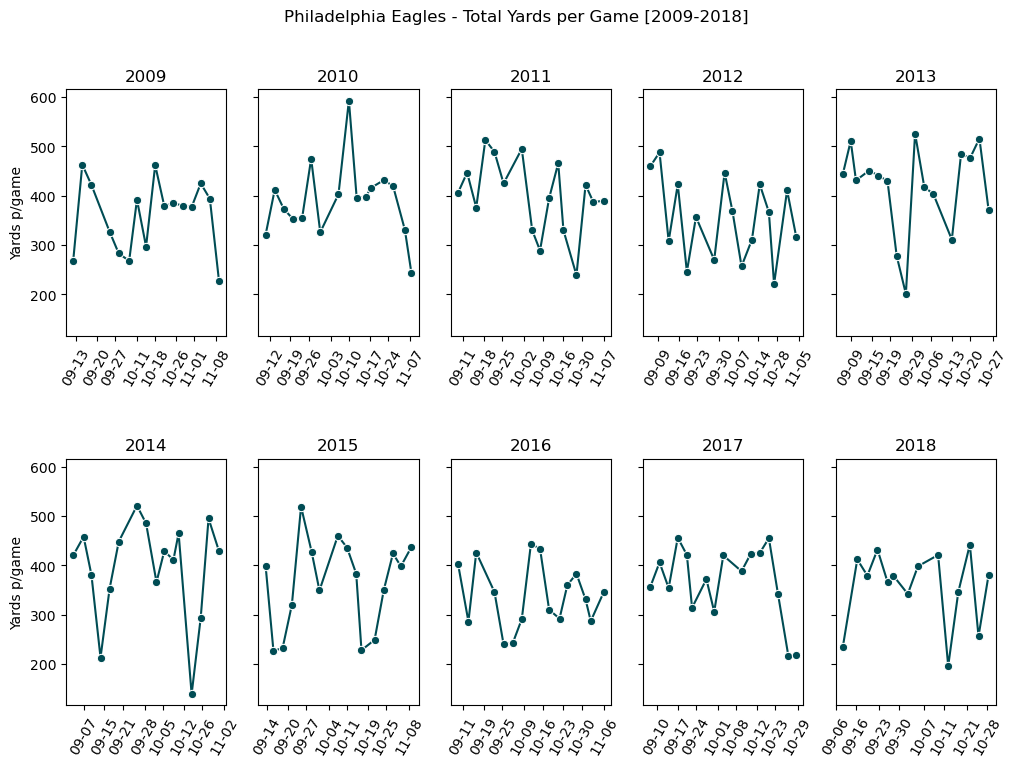

In [34]:
# Setting up parameters to create a figure with 10 subplots (1 per season)
rows = 2
cols = 5
year = single_team_stats['season'].min() # Starting with the 2009 season
fig, axs = plt.subplots(rows, cols, sharey=True, figsize=(12,8))

# Looping through each season and plotting yards per game for each subplot
for row in range(rows):
    for col in range(cols):            
        yearly_stats = single_team_stats[single_team_stats['season'] == year]
        sns.lineplot(x='game_date', y='total_yds', data=yearly_stats, color='#004c54', marker='o', ax=axs[row,col])
        axs[row,col].set_title(f"{year}")
        axs[row,col].set_xlabel("")
        axs[row,col].set_xticklabels(labels=yearly_stats['game_date'].dt.strftime("%m-%d"), rotation=60)
        axs[row,col].set_ylabel("Yards p/game")
        year += 1

fig.suptitle("Philadelphia Eagles - Total Yards per Game [2009-2018]")
fig.subplots_adjust(hspace=0.5)
fig.show()

Looks like the highest recorded amount of offensive yards throughout these seasons happened in 2010, when they played the now-called Washington Commanders in a historic 59-28 win, when Michael Vick (their QB at the time) had arguably his best ever game with a total of 6 touchdowns (4 passing and 2 rushing), and their offense totalled 592 offensive yards!

On the flipside, their worst offensive game in that timespan seemed to be in the final stretch of the 2014 season under Chip Kelly as a Head Coach, when they were only able to produce a poor 139 yards of offense against the Seattle Seahawks, who were known as the best overall team defense in both points and yards allowed per game. This game was just a complete fluke though, since it can be seen that during the 2014 season, the Eagles were able to consistently put up at least 350 yards on offense, which happened in at least 13 of the 16 games in the season. Let's try to dive in on this and see their recipe for offensive consistency here.

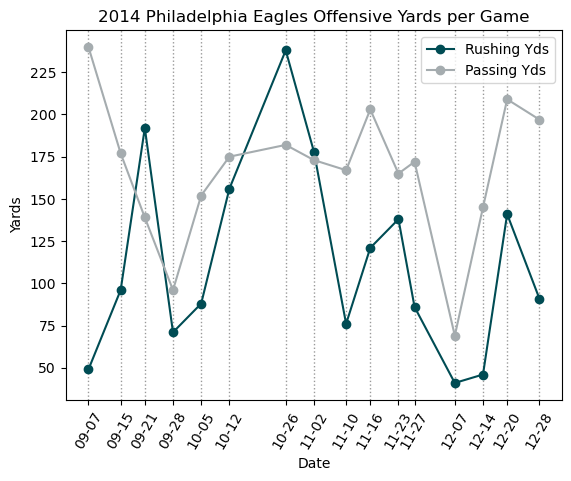

In [35]:
# Subsetting the PHI dataset for the 2014 season
phi_2014 = single_team_stats[single_team_stats.season == 2014]

# Looking at rushing and passing yards per game in this season
plt.plot(phi_2014.game_date, phi_2014.rush_yds, color='#004c54', marker='o')
plt.plot(phi_2014.game_date, phi_2014.pass_yds, color='#a5acaf', marker='o')
plt.title("2014 Philadelphia Eagles Offensive Yards per Game")
plt.xticks(ticks=phi_2014.game_date,
           labels=phi_2014.game_date.dt.strftime("%m-%d"),
           rotation=60)
plt.xlabel("Date")
plt.ylabel("Yards")
plt.grid(True, axis='x', color='black', linestyle=':', linewidth=1, alpha=0.4)
plt.legend(labels=["Rushing Yds", "Passing Yds"])
plt.show()

For the most part, there seems to be a slight pattern where the rushing and passing attack seemed to pair up together. Let's explore this with a correlation plot:

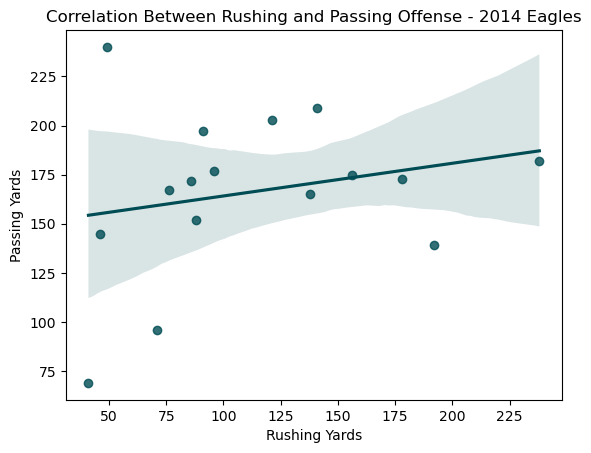

In [36]:
# Plotting a scatter plot for rushing vs passing yards for 2014 Eagles
sns.regplot(x=phi_2014.rush_yds, y=phi_2014.pass_yds, color='#004c54')
plt.title("Correlation Between Rushing and Passing Offense - 2014 Eagles")
plt.xlabel("Rushing Yards")
plt.ylabel("Passing Yards")
plt.show()

Although positive, it doesn't look like a strong correlation here...

Let's keep finding further insights. I'm curious about the influence of the rushing and passing ratio for every game and whether that had an influence in the total offensive yards for the Eagles in 2014. Let's see if that gives us anything:

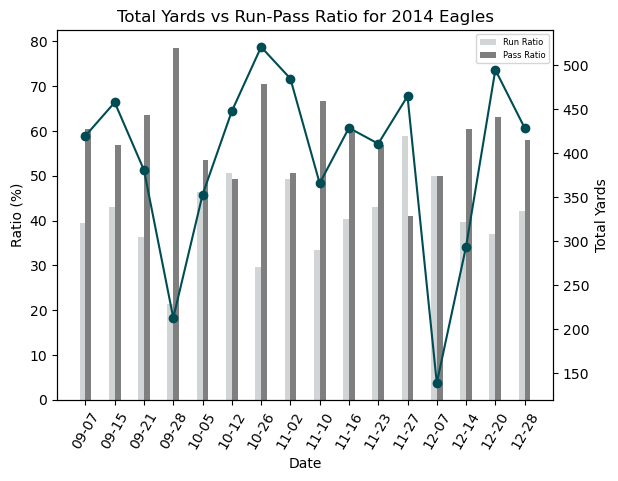

In [37]:
# Assigning variables for axis labels and bar width
x_pos = np.arange(len(phi_2014.game_date))
ratio_labels = np.arange(0,90,10)
bar_width = 0.1

# Plotting run-pass ratios in 2014
fig, ax = plt.subplots()

ax.bar(x_pos-bar_width, phi_2014.run_ratio, 
        width=0.2, label="Run Ratio", color='#a5acaf', alpha=0.5)
ax.bar(x_pos+bar_width, phi_2014.pass_ratio, 
        width=0.2, label="Pass Ratio", color='#000000', alpha=0.5)
ax.set_ylabel("Ratio (%)")
ax.set_yticklabels(ratio_labels)

# Setting up a 2nd y-axis and plotting total yards per game in 2014
ax2 = ax.twinx()

ax2.plot(x_pos, phi_2014.total_yds, color='#004c54', marker='o')
ax2.set_ylabel("Total Yards")

# Fixing up some additional figure settings
ax.set_xticks(x_pos, labels=phi_2014['game_date'].dt.strftime("%m-%d"), rotation=60)
ax.set_title("Total Yards vs Run-Pass Ratio for 2014 Eagles")
ax.set_xlabel("Date")
ax.legend(loc='upper right', bbox_to_anchor=(1,1), fontsize=6)
fig.show()

No particularly noticeable trends from this plot by the looks of it...

From the perspective of games where the 2014 Eagles had less than 300 yards of offense, the run-pass ratios seemed to be quite varied at approximately 20/80, 50/50, and 40/60. Although one could argue 3 samples aren't significantly high to determine such thing.

Only on two games did the Eagles ran the ball more than they passed it, and they seemed to be quite successful those days, producing at least 450 yards.

However, it's more evident that the passing game was their strong suit, given that in most games when they passed the ball more than they ran it, they produced at least 350 yards, and to a higher degree, more than 400 yards in more than half of their games that season. 

Is this a good number? We will see later on when we can visualise all games during this timespan.

## 5. Creating functions and visualisations

Granted, if we want to do these tasks repeatedly for every team and every game, writing that bulky block of code multiple times can become annoying.

So, to do this in a more user-friendly way, I'll create two functions - one to produce game boxscores for any combination of teams at any particular season (if they indeed played during that season), and another one to produce offensive stats for any individual team during any number of seasons.

The difference between these functions and the ones coded in the previous sections is that now we will include a few more descriptive columns, such as whether each team played as the home or away team, how many points they scored (and who won the game), and scoring details such as the touchdowns and field goals.

Let's start with the *game_stats* function, which takes a team, a rival, and the year when they played (if they played):

In [38]:
def game_stats(team, rival, year):
    """
    A game boxscore for two teams that played in the specified year.
    
    In the case of divisional rivals (which play twice a year), the function
    allows the user to select the specific date of the game of interest.

    ...

    Args:
    ----------
    team : str
        The team abbreviation for the first team (case-insensitive).
    rival : str
        The team abbreviation for the second team (case-insensitive).
    year : int
        The season when both teams played each other.

    Returns:
    ----------
    A Pandas DataFrame.
    """
    # Subset the data by both teams and year
    game = df[(df['posteam'].isin([team.upper(), rival.upper()])) & \
    (df['defteam'].isin([team.upper(), rival.upper()])) & \
    (df['season'] == year)]
    
    # Returning a message if no games were found for such teams in that year
    if game.empty:
        return print("Sorry, these two teams did not play each other that year.")

    # Checking if there are multiple games for both teams in that year
    # Allowing the user to select the game of interest by game date
    if len(game.game_date.unique()) > 1:
        print("It looks like there's multiple dates where these teams played during that year.\n")
        print(game.game_date.unique().strftime("%Y-%m-%d").tolist())
        date = input("Which date (yyyy-mm-dd) would you like to select?:")
        game = game[game['game_date'] == date]

        # If the date is entered wrong, return a message and exit the function
        if game.empty:
            return print("Sorry, it looks like you entered a wrong date. Please run the function again.")

    # Performing the aggregations for the boxscore
    game_stats = game.groupby('posteam').agg(
        home_away=('posteam_type', 'min'),
        points=('posteam_score_post', 'max'),
        drives=('drive', 'nunique'),
        plays_per_drive=('drive', lambda x: np.mean(pd.value_counts(x))),
        avg_yds_per_play=('yards_gained', lambda x: x[game['play_type'].isin(['run','pass'])].mean()),
        total_yds=('yards_gained', 'sum'),
        rush_yds=('yards_gained', lambda x: x[game['play_type'] == 'run'].sum()),
        pass_yds=('yards_gained', lambda x: x[game['play_type'] == 'pass'].sum()),
        run_ratio=('rush_attempt', lambda x: x[game['play_type'].isin(['run','pass'])].mean()),
        pass_ratio=('pass_attempt', lambda x: x[game['play_type'].isin(['run','pass'])].mean()),
        total_plays=('play_type', lambda x: x[game['play_type'].isin(['run','pass'])].count()),
        time_of_poss=('play_duration', 'sum'),
        run_plays=('rush_attempt', 'sum'),
        yds_per_run=('yards_gained', lambda x: x[(game['play_type'] == 'run')].sum() / x[(game['play_type'] == 'run')].count()),
        fumbles_lost=('fumble_lost', 'sum'),
        pass_plays=('pass_attempt', 'sum'),
        completed_passes=('complete_pass', 'sum'),
        yds_per_pass=('yards_gained', lambda x: x[(game['play_type'] == 'pass')].sum() / x[(game['play_type'] == 'pass')].count()),
        interceptions=('interception', 'sum'),
        sacks=('sack', 'sum'),
        sack_yds_lost=('yards_gained', lambda x: abs(x[game['sack'] == 1].sum())),
        total_tds=('touchdown', 'sum'),
        rush_tds=('rush_touchdown','sum'),
        pass_tds=('pass_touchdown','sum'),
        fg_made=('field_goal_result', lambda x: x[game['field_goal_result'] == 'made'].count()),
        fg_attempts=('field_goal_attempt', 'sum'),
        run_1st_downs=('first_down_rush', 'sum'),
        pass_1st_downs=('first_down_pass', 'sum'),
        penalty_1st_downs=('first_down_penalty','sum'),
        made_3rd_downs=('third_down_converted','sum'),
        failed_3rd_downs=('third_down_failed','sum'),
        made_4th_downs=('fourth_down_converted','sum'),
        failed_4th_downs=('fourth_down_failed','sum')
    )

    # Creating the extra columns and stats
    game_stats['pass_attempts'] = game_stats['pass_plays'] - game_stats['sacks']
    game_stats['completion_pct'] = game_stats['completed_passes'] / game_stats['pass_attempts']
    game_stats['turnovers'] = game_stats['fumbles_lost'] + game_stats['interceptions']
    game_stats['total_1st_downs'] = game_stats[['run_1st_downs', 'pass_1st_downs', 'penalty_1st_downs']].sum(axis=1)
    game_stats['total_3rd_downs'] = game_stats[['made_3rd_downs', 'failed_3rd_downs']].sum(axis=1)
    game_stats['eff_3rd_down'] = game_stats['made_3rd_downs'] / game_stats['total_3rd_downs']
    game_stats['total_4th_downs'] = game_stats[['made_4th_downs', 'failed_4th_downs']].sum(axis=1)
    game_stats['eff_4th_down'] = game_stats['made_4th_downs'] / game_stats['total_4th_downs']

    # Ordering the columns for the resulting dataset
    col_order = ['home_away', 'points', 'total_tds', 'rush_tds', 'pass_tds', 'fg_made', \
                 'fg_attempts', 'total_plays', 'time_of_poss', 'total_yds', 'drives', \
                 'avg_yds_per_play', 'plays_per_drive', 'total_1st_downs', \
                 'pass_1st_downs', 'run_1st_downs', 'penalty_1st_downs', \
                 'made_3rd_downs', 'failed_3rd_downs', 'total_3rd_downs', \
                 'eff_3rd_down', 'made_4th_downs', 'failed_4th_downs', \
                 'total_4th_downs', 'eff_4th_down', 'run_plays', 'rush_yds', \
                 'yds_per_run', 'pass_plays', 'pass_yds', 'completed_passes', \
                 'pass_attempts', 'completion_pct', 'sacks', 'sack_yds_lost', \
                 'fumbles_lost', 'interceptions', 'turnovers', 'run_ratio', \
                 'pass_ratio']

    # Rounding the stats to 2 decimals and transposing columns as rows
    # Returning the final dataset with the boxscore
    game_stats = game_stats[col_order].round(2).T
    return game_stats

Now that we have the function created, we can start getting boxscores for any game that happened between the 2009 and 2018 seasons!

Let's attempt to look for the first game found in the dataset, just like we did back in Section 3. We're talking about the Titans-Steelers game in 2009.

For that, let's use the function we just created and see what we come up with:

In [39]:
game_stats('ten', 'pit', 2009)

posteam               PIT     TEN
home_away            home    away
points               13.0    10.0
total_tds             1.0     1.0
rush_tds              0.0     0.0
pass_tds              1.0     1.0
fg_made                 2       1
fg_attempts           2.0     3.0
total_plays            70      61
time_of_poss       2165.0  1693.0
total_yds           357.0   320.0
drives                 13      12
avg_yds_per_play      5.1    5.25
plays_per_drive      7.15    6.58
total_1st_downs      19.0    18.0
pass_1st_downs       18.0    14.0
run_1st_downs         1.0     2.0
penalty_1st_downs     0.0     2.0
made_3rd_downs        4.0     4.0
failed_3rd_downs     10.0     9.0
total_3rd_downs      14.0    13.0
eff_3rd_down         0.29    0.31
made_4th_downs        0.0     0.0
failed_4th_downs      0.0     0.0
total_4th_downs       0.0     0.0
eff_4th_down          NaN     NaN
run_plays            23.0    25.0
rush_yds             36.0    86.0
yds_per_run          1.57    3.44
pass_plays           47.0    36.0
pass_yds            321.0   234.0
completed_passes     33.0    22.0
pass_attempts        43.0    35.0
completion_pct       0.77    0.63
sacks                 4.0     1.0
sack_yds_lost        42.0    10.0
fumbles_lost          1.0     1.0
interceptions         2.0     1.0
turnovers             3.0     2.0
run_ratio            0.33    0.41
pass_ratio           0.67    0.59

Nice! We pretty much got the same stats we saw in Section 3, but now also adding up the scores, scoring plays, and full time of possession for the game...well, almost.

Something peculiar about the time of possession is that it's missing the mark by a few seconds for each team, when compared to ESPN's boxscore. This might be to do with the operations we performed on the dataset to calculate each play's duration, but nothing particularly alarming for these purposes.

To test the divisional rivalry functionality, let's look for games in 2009 when the Eagles played the Dallas Cowboys, which are one of their divisional rivals in the NFC East division. As part of the NFL schedule, every team has to play against each of their divisional rivals twice per season. I'll search for the first occurence between these two teams in the 2009 season:

In [40]:
game_stats('phi', 'dal', 2009)

It looks like there's multiple dates where these teams played during that year.

['2009-11-08', '2010-01-03']


Which date (yyyy-mm-dd) would you like to select?: 2009-11-08


posteam               DAL     PHI
home_away            away    home
points               20.0    16.0
total_tds             2.0     1.0
rush_tds              1.0     0.0
pass_tds              1.0     1.0
fg_made                 2       3
fg_attempts           2.0     3.0
total_plays            57      55
time_of_poss       1861.0  1696.0
total_yds           358.0   297.0
drives                 11      11
avg_yds_per_play     6.33     5.4
plays_per_drive      7.64    7.18
total_1st_downs      18.0    17.0
pass_1st_downs       12.0    10.0
run_1st_downs         5.0     4.0
penalty_1st_downs     1.0     3.0
made_3rd_downs        7.0     4.0
failed_3rd_downs      8.0     8.0
total_3rd_downs      15.0    12.0
eff_3rd_down         0.47    0.33
made_4th_downs        0.0     0.0
failed_4th_downs      0.0     1.0
total_4th_downs       0.0     1.0
eff_4th_down          NaN     0.0
run_plays            23.0    23.0
rush_yds             79.0    89.0
yds_per_run          3.95    3.87
pass_plays           38.0    34.0
pass_yds            282.0   208.0
completed_passes     21.0    16.0
pass_attempts        34.0    30.0
completion_pct       0.62    0.53
sacks                 4.0     4.0
sack_yds_lost        25.0    19.0
fumbles_lost          0.0     0.0
interceptions         1.0     2.0
turnovers             1.0     2.0
run_ratio            0.35    0.42
pass_ratio           0.65    0.58

Sadly, to my liking, this game was won by the Cowboys, although for the most part it was a very balanced game for both offenses. Seems like the Cowboys got the edge on 3rd downs, where they had a 47% conversion efficiency, compared to the Eagles' 33%, which is not an ideal number when you're looking to extend drives and have more chances to score.

Now that we've tested the functionality of our *game_stats* function, let's create another function that looks to generate a team's season offensive stats one season, which is a very similar code like the one used in Section 4:

In [41]:
def team_season_stats(team, year):
    """
    A team's full offensive stats for every game played in the specified year.
    
    ...

    Args:
    ----------
    team : str
        The team abbreviation for the first team (case-insensitive).
    year : int
        The season of interest.

    Returns:
    ----------
    A Pandas DataFrame.
    """
    # If the entered year is not found in the dataset, return a message
    if year not in range(df['season'].min(), (df['season'].max()+1)):
        return print("Sorry, this season is not found on this dataset.")

    # Filtering the dataset by team and season
    df_season = df[(df['posteam'] == team.upper()) & (df['season'] == year)]

    # Producing the team stats for the selected season
    team_stats = df_season.groupby('game_date').agg(
        pts_for=('posteam_score_post', 'max'),
        pts_against=('defteam_score_post', 'max'),
        opponent=('defteam', 'min'),
        home_away=('posteam_type', 'min'),
        drives=('drive', 'nunique'),
        plays_per_drive=('drive', lambda x: np.mean(pd.value_counts(x))),
        avg_yds_per_play=('yards_gained', lambda x: x[df_season['play_type'].isin(['run','pass'])].mean()),
        total_yds=('yards_gained', 'sum'),
        rush_yds=('yards_gained', lambda x: x[df_season['play_type'] == 'run'].sum()),
        pass_yds=('yards_gained', lambda x: x[df_season['play_type'] == 'pass'].sum()),
        run_ratio=('rush_attempt', lambda x: x[df_season['play_type'].isin(['run','pass'])].mean()),
        pass_ratio=('pass_attempt', lambda x: x[df_season['play_type'].isin(['run','pass'])].mean()),
        total_plays=('play_type', lambda x: x[df_season['play_type'].isin(['run','pass'])].count()),
        time_of_poss=('play_duration', 'sum'),
        run_plays=('rush_attempt', 'sum'),
        yds_per_run=('yards_gained', lambda x: x[(df_season['play_type'] == 'run')].mean()),
        fumbles_lost=('fumble_lost', 'sum'),
        pass_plays=('pass_attempt', 'sum'),
        completed_passes=('complete_pass', 'sum'),
        yds_per_pass=('yards_gained', lambda x: x[(df_season['play_type'] == 'pass')].mean()),
        interceptions=('interception', 'sum'),
        sacks=('sack', 'sum'),
        sack_yds_lost=('yards_gained', lambda x: abs(x[df_season['sack'] == 1].sum())),
        total_tds=('touchdown', 'sum'),
        rush_tds=('rush_touchdown','sum'),
        pass_tds=('pass_touchdown','sum'),
        fg_made=('field_goal_result', lambda x: x[df_season['field_goal_result'] == 'made'].count()),
        fg_attempts=('field_goal_attempt', 'sum'),
        run_1st_downs=('first_down_rush', 'sum'),
        pass_1st_downs=('first_down_pass', 'sum'),
        penalty_1st_downs=('first_down_penalty','sum'),
        made_3rd_downs=('third_down_converted','sum'),
        failed_3rd_downs=('third_down_failed','sum'),
        made_4th_downs=('fourth_down_converted','sum'),
        failed_4th_downs=('fourth_down_failed','sum')
    ).reset_index()

    # Creating the extra stat columns
    team_stats['pass_attempts'] = team_stats['pass_plays'] - team_stats['sacks']
    team_stats['completion_pct'] = team_stats['completed_passes'] / team_stats['pass_attempts']
    team_stats['turnovers'] = team_stats['fumbles_lost'] + team_stats['interceptions']
    team_stats['total_1st_downs'] = team_stats[['run_1st_downs', 'pass_1st_downs', 'penalty_1st_downs']].sum(axis=1)
    team_stats['total_3rd_downs'] = team_stats[['made_3rd_downs', 'failed_3rd_downs']].sum(axis=1)
    team_stats['eff_3rd_down'] = team_stats['made_3rd_downs'] / team_stats['total_3rd_downs']
    team_stats['total_4th_downs'] = team_stats[['made_4th_downs', 'failed_4th_downs']].sum(axis=1)
    team_stats['eff_4th_down'] = team_stats['made_4th_downs'] / team_stats['total_4th_downs']

    # Sorting the columns in the desired order
    col_order = ['game_date', 'opponent', 'home_away', 'pts_for', \
                 'pts_against', 'total_tds', 'rush_tds', 'pass_tds', 'fg_made', \
                 'fg_attempts', 'total_plays', 'time_of_poss', 'total_yds', \
                 'drives', 'avg_yds_per_play', 'plays_per_drive', 'total_1st_downs', \
                 'pass_1st_downs', 'run_1st_downs', 'penalty_1st_downs', \
                 'made_3rd_downs', 'failed_3rd_downs', 'total_3rd_downs', \
                 'eff_3rd_down', 'made_4th_downs', 'failed_4th_downs', \
                 'total_4th_downs', 'eff_4th_down', 'run_plays', 'rush_yds', \
                 'yds_per_run', 'pass_plays', 'pass_yds', 'completed_passes', \
                 'pass_attempts', 'completion_pct', 'sacks', 'sack_yds_lost', \
                 'fumbles_lost', 'interceptions', 'turnovers', 'run_ratio', \
                 'pass_ratio']

    # Rounding the values to 2 decimals
    team_stats = team_stats[col_order].round(2)
    # Inserting dummy columns to determine the team's result
    team_stats.insert(3, 'win', np.where(team_stats['pts_for'] > team_stats['pts_against'], 1, 0))
    team_stats.insert(4, 'loss', np.where(team_stats['pts_for'] < team_stats['pts_against'], 1, 0))
    team_stats.insert(5, 'tie', np.where(team_stats['pts_for'] == team_stats['pts_against'], 1, 0))
    
    return team_stats

Now, let's put the function to the test by looking at the stats of the Eagles' 2017 regular season, which was the season when they won their first and, so far, only Super Bowl:

In [42]:
phi_2017 = team_season_stats('PHI', 2017)
phi_2017

game_date opponent home_away  win  loss  tie  pts_for  pts_against  \
0  2017-09-10      WAS      away    1     0    0     28.0         16.0   
1  2017-09-17       KC      away    0     1    0     20.0         27.0   
2  2017-09-24      NYG      home    1     0    0     27.0         24.0   
3  2017-10-01      LAC      away    1     0    0     26.0         24.0   
4  2017-10-08      ARI      home    1     0    0     34.0          7.0   
5  2017-10-12      CAR      away    1     0    0     28.0         23.0   
6  2017-10-23      WAS      home    1     0    0     34.0         24.0   
7  2017-10-29       SF      home    1     0    0     31.0         10.0   
8  2017-11-05      DEN      home    1     0    0     51.0         22.0   
9  2017-11-19      DAL      away    1     0    0     35.0          9.0   
10 2017-11-26      CHI      home    1     0    0     31.0          3.0   
11 2017-12-03      SEA      away    0     1    0     10.0         24.0   
12 2017-12-10      LAR      away    1     0    0     37.0         34.0   
13 2017-12-17      NYG      away    1     0    0     34.0         29.0   
14 2017-12-25       LV      home    1     0    0     13.0         10.0   
15 2017-12-31      DAL      home    0     1    0      0.0          6.0   

    total_tds  rush_tds  pass_tds  fg_made  fg_attempts  total_plays  \
0         3.0       0.0       2.0        3          3.0           63   
1         2.0       0.0       2.0        2          3.0           69   
2         3.0       2.0       1.0        2          3.0           72   
3         2.0       1.0       1.0        4          4.0           72   
4         4.0       0.0       4.0        2          2.0           62   
5         3.0       0.0       3.0        2          2.0           58   
6         4.0       0.0       4.0        2          3.0           60   
7         3.0       1.0       2.0        2          2.0           64   
8         8.0       3.0       4.0        1          1.0           66   
9         4.0       2.0       2.0        0          1.0           58   
10        4.0       0.0       3.0        1          1.0           70   
11        1.0       0.0       1.0        1          1.0           74   
12        5.0       0.0       4.0        3          3.0           84   
13        4.0       0.0       4.0        2          2.0           65   
14        1.0       0.0       1.0        2          3.0           61   
15        0.0       0.0       0.0        0          0.0           55   

   time_of_poss  total_yds  drives  avg_yds_per_play  plays_per_drive  \
0        2061.0      356.0      12              5.67             7.25   
1        1846.0      406.0      11              5.88             8.36   
2        2274.0      354.0      13              4.92             7.54   
3        2358.0      454.0       9              6.33            10.67   
4        2147.0      419.0      11              6.79             7.36   
5        1765.0      312.0      13              5.41             6.46   
6        1856.0      371.0      12              6.20             7.25   
7        1977.0      304.0      13              4.78             6.54   
8        1794.0      419.0      14              6.36             6.50   
9        1769.0      387.0      12              6.69             6.42   
10       2228.0      420.0      11              6.04             8.64   
11       1914.0      425.0      10              5.74             8.70   
12       2352.0      455.0      13              5.42             9.23   
13       1853.0      341.0      12              5.26             7.33   
14       1539.0      216.0      14              3.54             6.14   
15       1794.0      219.0      12              3.98             6.17   

    total_1st_downs  pass_1st_downs  run_1st_downs  penalty_1st_downs  \
0              19.0            17.0            1.0                1.0   
1              27.0            19.0            6.0                2.0   
2              24.0             8.0           13.0         

What a season this one was! The 2017 Eagles team was a very efficient team on offense, both in points and yards. They scored 3 or more touchdowns in 75% of their games that year, and at least 20 points in all but 3 games, counting the last 2 games of the season when they already had the #1 seed secured and could basically rest their starting players. One can tell that was the case given the fact that those last 2 games were the only games in that season where they failed to produce at least 300 yards.

Now, let's create one last function, and this one will encompass all season games played in a single season or range of seasons. Since we have a good template on how to summarise the dataset to produce these stats, this function won't be any more complicated than it should. But instead of only producing the stats for one team playing offense, we'll do both teams as home and away stats for easier reference and better structure to the predictive model that we'll analyse further down this notebook.

In [43]:
def get_season_scores(years):
    """
    All boxscores for games played in a single season or range of seasons.
    
    ...

    Args:
    ----------
    years : int or list(ints)
        The season/s of interest.

    Returns:
    ----------
    A Pandas DataFrame.
    """
    # If a season is not found on the dataset, return a message
    if type(years) == int:
        if years not in df['season'].unique():
            return print("Sorry, this season is not found on the dataset.")
        # Subsetting the dataset for the entered season
        df_season = df[df['season'] == years]
    elif type(years) == list:
        # If one season in the range is not on the dataset, return a message
        for y in years:
            if y not in df['season'].unique():
                return print(f"Sorry, the {y} season is not found on the dataset.")
        # Subsetting the dataset for the entered list of seasons
        df_season = df[df['season'].isin(years)]

    # Creating variables for easier subsetting in the named aggregations
    home = df_season['posteam_type'] == 'home'
    away = df_season['posteam_type'] == 'away'
    plays = df_season['play_type'].isin(['run','pass'])
    runs = df_season['play_type'] == 'run'
    passes = df_season['play_type'] == 'pass'
    sacks = df_season['sack'] == 1
    fgs = df_season['field_goal_result'] == 'made'
    xps = df_season['extra_point_result'] == 'good'
    conv_2pts = df_season['two_point_conv_result'] == 'success'

    # Grouping and aggregating the subset by season, game, and home/away teams
    all_games = df_season.groupby(['season', 'game_id', 'game_date', 'home_team', 'away_team']).agg(
        home_pts=('total_home_score', lambda x: x[home].max()),
        away_pts=('total_away_score', lambda x: x[away].max()),
        home_yds=('yards_gained', lambda x: x[home].sum()),
        away_yds=('yards_gained', lambda x: x[away].sum()),
        home_plays=('play_type', lambda x: x[home & plays].count()),
        away_plays=('play_type', lambda x: x[away & plays].count()),
        home_time_of_poss=('play_duration', lambda x: x[home].sum()),
        away_time_of_poss=('play_duration', lambda x: x[away].sum()),    
        home_yds_per_play=('yards_gained', lambda x: x[home & plays].mean()),
        away_yds_per_play=('yards_gained', lambda x: x[away & plays].mean()),
        home_drives=('drive', lambda x: x[home].nunique()),
        away_drives=('drive', lambda x: x[away].nunique()),
        home_plays_per_drive=('drive', lambda x: np.mean(pd.value_counts(x[home & plays]))),
        away_plays_per_drive=('drive', lambda x: np.mean(pd.value_counts(x[away & plays]))),
        home_rush_ratio=('rush_attempt', lambda x: x[home & plays].mean()),
        away_rush_ratio=('rush_attempt', lambda x: x[away & plays].mean()),
        home_pass_ratio=('pass_attempt', lambda x: x[home & plays].mean()),
        away_pass_ratio=('pass_attempt', lambda x: x[away & plays].mean()),
        home_rush_plays=('rush_attempt', lambda x: x[home].sum()),
        away_rush_plays=('rush_attempt', lambda x: x[away].sum()),
        home_rush_yds=('yards_gained', lambda x: x[home & runs].sum()),
        away_rush_yds=('yards_gained', lambda x: x[away & runs].sum()),
        home_yds_per_rush=('yards_gained', lambda x: x[home & runs].mean()),
        away_yds_per_rush=('yards_gained', lambda x: x[away & runs].mean()),
        home_pass_plays=('pass_attempt', lambda x: x[home].sum()),
        away_pass_plays=('pass_attempt', lambda x: x[away].sum()),
        home_pass_yds=('yards_gained', lambda x: x[home & passes].sum()),
        away_pass_yds=('yards_gained', lambda x: x[away & passes].sum()),
        home_yds_per_pass=('yards_gained', lambda x: x[home & passes].mean()),
        away_yds_per_pass=('yards_gained', lambda x: x[away & passes].mean()),
        home_pass_comp=('complete_pass', lambda x: x[home].sum()),
        away_pass_comp=('complete_pass', lambda x: x[away].sum()),
        home_pass_att=('pass_attempt', lambda x: x[home & ~sacks].sum()),
        away_pass_att=('pass_attempt', lambda x: x[away & ~sacks].sum()),
        home_sacks=('sack', lambda x: x[away].sum()),
        away_sacks=('sack', lambda x: x[home].sum()),
        home_sack_yds=('yards_gained', lambda x: abs(x[away & sacks].sum())),
        away_sack_yds=('yards_gained', lambda x: abs(x[home & sacks].sum())),
        home_rush_tds=('rush_touchdown', lambda x: x[home].sum()),
        away_rush_tds=('rush_touchdown', lambda x: x[away].sum()),
        home_pass_tds=('pass_touchdown', lambda x: x[home].sum()),
        away_pass_tds=('pass_touchdown', lambda x: x[away].sum()),
        home_dst_tds=('touchdown', lambda x: x[home & ~plays].sum()),
        away_dst_tds=('touchdown', lambda x: x[away & ~plays].sum()),
        home_total_tds=('touchdown', lambda x: x[home].sum()),
        away_total_tds=('touchdown', lambda x: x[away].sum()),
        home_fg_made=('field_goal_result', lambda x: x[home & fgs].count()),
        away_fg_made=('field_goal_result', lambda x: x[away & fgs].count()),
        home_fg_att=('field_goal_attempt', lambda x: x[home].sum()),
        away_fg_att=('field_goal_attempt', lambda x: x[away].sum()),
        home_xp_made=('extra_point_result', lambda x: x[home & xps].count()),
        away_xp_made=('extra_point_result', lambda x: x[away & xps].count()),
        home_xp_att=('extra_point_attempt', lambda x: x[home].sum()),
        away_xp_att=('extra_point_attempt', lambda x: x[away].sum()),
        home_2pt_made=('two_point_conv_result', lambda x: x[home & conv_2pts].count()),
        away_2pt_made=('two_point_conv_result', lambda x: x[away & conv_2pts].count()),
        home_2pt_att=('two_point_attempt', lambda x: x[home].sum()),
        away_2pt_att=('two_point_attempt', lambda x: x[away].sum()),
        home_punts=('punt_attempt', lambda x: x[home].sum()),
        away_punts=('punt_attempt', lambda x: x[away].sum()),
        home_fumbles=('fumble_lost', lambda x: x[home].sum()),
        away_fumbles=('fumble_lost', lambda x: x[away].sum()),
        home_ints=('interception', lambda x: x[home].sum()),
        away_ints=('interception', lambda x: x[away].sum()),
        home_rush_1st_downs=('first_down_rush', lambda x: x[home].sum()),
        away_rush_1st_downs=('first_down_rush', lambda x: x[away].sum()),
        home_pass_1st_downs=('first_down_pass', lambda x: x[home].sum()),
        away_pass_1st_downs=('first_down_pass', lambda x: x[away].sum()),
        home_penalty_1st_downs=('first_down_penalty', lambda x: x[home].sum()),
        away_penalty_1st_downs=('first_down_penalty', lambda x: x[away].sum()),
        home_made_3rd_downs=('third_down_converted', lambda x: x[home].sum()),
        away_made_3rd_downs=('third_down_converted', lambda x: x[away].sum()),
        home_failed_3rd_downs=('third_down_failed', lambda x: x[home].sum()),
        away_failed_3rd_downs=('third_down_failed', lambda x: x[away].sum()),
        home_made_4th_downs=('fourth_down_converted', lambda x: x[home].sum()),
        away_made_4th_downs=('fourth_down_converted', lambda x: x[away].sum()),
        home_failed_4th_downs=('fourth_down_failed', lambda x: x[home].sum()),
        away_failed_4th_downs=('fourth_down_failed', lambda x: x[away].sum())
    ).reset_index()    
    
    return all_games

Let's now test this new function by filtering for the 2009 season games:

In [44]:
games_2009 = get_season_scores(2009)
games_2009

season     game_id  game_date home_team away_team  home_pts  away_pts  \
0      2009  2009091000 2009-09-10       PIT       TEN        13        10   
1      2009  2009091300 2009-09-13       ATL       MIA        19         7   
2      2009  2009091301 2009-09-13       BAL        KC        38        23   
3      2009  2009091302 2009-09-13       CAR       PHI        10        36   
4      2009  2009091303 2009-09-13       CIN       DEN         7        12   
..      ...         ...        ...       ...       ...       ...       ...   
251    2009  2010010311 2010-01-03       ARI        GB         7        32   
252    2009  2010010312 2010-01-03       DEN        KC        24        42   
253    2009  2010010313 2010-01-03        LV       BAL        13        21   
254    2009  2010010314 2010-01-03       LAC       WAS        23        20   
255    2009  2010010315 2010-01-03       SEA       TEN        13        17   

     home_yds  away_yds  home_plays  away_plays  home_time_of_poss  \
0       357.0     320.0          70          61             2165.0   
1       281.0     259.0          62          55             1831.0   
2       501.0     188.0          85          44             2381.0   
3       169.0     267.0          68          62             1751.0   
4       307.0     302.0          63          52             2005.0   
..        ...       ...         ...         ...                ...   
251     187.0     345.0          45          60             1353.0   
252     512.0     524.0          80          60             1983.0   
253     325.0     330.0          62          55             2750.0   
254     364.0     339.0          63          65             1647.0   
255     309.0     304.0          59          63             1658.0   

     away_time_of_poss  home_yds_per_play  away_yds_per_play  home_drives  \
0               1693.0           5.100000           5.245902           13   
1               1747.0           4.596774           4.709091           11   
2               1211.0           5.894118           4.272727           11   
3               1897.0           2.500000           4.322581           15   
4               1593.0           4.873016           5.807692           11   
..                 ...                ...                ...          ...   
251             2228.0           4.155556           5.800000            9   
252             1617.0           6.400000           8.733333           14   
253             1663.0           5.241935           6.054545           11   
254             1953.0           5.777778           5.215385           11   
255             1942.0           5.254237           4.857143           11   

     away_drives  home_plays_per_drive  away_plays_per_drive  home_rush_ratio  \
0             12              5.384615              5.083333         0.328571   
1             11              5.636364              5.000000         0.387097   
2             11              7.727273              4.000000         0.482353   
3             14              4.857143              5.166667         0.426471   
4             11              5.727273              4.727273         0.428571   
..           ...                   ...                   ...              ...   
251            9              5.000000              6.666667         0.311111   
252           12              5.714286              5.000000         0.275000   
253           11              6.200000              5.000000         0.322581   
254           10              5.727273              6.500000         0.269841   
255           11              5.900000              6.300000         0.423729   

     away_rush_ratio  home_pass_ratio  away_pass_ratio  home_rush_plays  \
0           0.409836         0.671429         0.590164             23.0   
1           0.400000         0.612903         0.600000             27.0   
2           0.386364         0.517647         0.613636             41.0   
3           0.500000         

As we can see, we have 256 rows which is equal to the 256 games played in the 2009 season. Our first row is the game we've shown quite a few times throughout this notebook - Titans @ Steelers.

Additionally, we've added more columns to the resulting dataset, such as extra-point attempts (or Points After Touchdowns), 2-point conversion attempts, punts, and defensive/special teams touchdowns. This gives us a bigger picture of all stats that contribute to a team's win in every game.

With this function, we can now summarise the whole dataset to obtain all stats for every single game in the dataset, which will serve us for our predictive model later on:

In [45]:
# Creating a DataFrame with the scores and stats for every game in the dataset
all_games = get_season_scores(df['season'].unique().tolist())
all_games

season     game_id  game_date home_team away_team  home_pts  away_pts  \
0       2009  2009091000 2009-09-10       PIT       TEN        13        10   
1       2009  2009091300 2009-09-13       ATL       MIA        19         7   
2       2009  2009091301 2009-09-13       BAL        KC        38        23   
3       2009  2009091302 2009-09-13       CAR       PHI        10        36   
4       2009  2009091303 2009-09-13       CIN       DEN         7        12   
...      ...         ...        ...       ...       ...       ...       ...   
2521    2018  2018121608 2018-12-16       NYG       TEN         0        17   
2522    2018  2018121609 2018-12-16        SF       SEA        26        23   
2523    2018  2018121610 2018-12-16       PIT        NE        17        10   
2524    2018  2018121611 2018-12-16       LAR       PHI        23        30   
2525    2018  2018121700 2018-12-17       CAR        NO         7        12   

      home_yds  away_yds  home_plays  away_plays  home_time_of_poss  \
0        357.0     320.0          70          61             2165.0   
1        281.0     259.0          62          55             1831.0   
2        501.0     188.0          85          44             2381.0   
3        169.0     267.0          68          62             1751.0   
4        307.0     302.0          63          52             2005.0   
...        ...       ...         ...         ...                ...   
2521     260.0     301.0          63          64             1479.0   
2522     351.0     378.0          56          69             1775.0   
2523     376.0     368.0          58          56             1849.0   
2524     407.0     381.0          73          61             1704.0   
2525     247.0     346.0          56          68             1491.0   

      away_time_of_poss  home_yds_per_play  away_yds_per_play  home_drives  \
0                1693.0           5.100000           5.245902           13   
1                1747.0           4.596774           4.709091           11   
2                1211.0           5.894118           4.272727           11   
3                1897.0           2.500000           4.322581           15   
4                1593.0           4.873016           5.807692           11   
...                 ...                ...                ...          ...   
2521             2088.0           4.126984           4.718750           10   
2522             2234.0           6.303571           5.478261           13   
2523             1751.0           6.534483           6.571429           10   
2524             1896.0           5.575342           6.245902           12   
2525             2080.0           4.410714           5.117647           10   

      away_drives  home_plays_per_drive  away_plays_per_drive  \
0              12              5.384615              5.083333   
1              11              5.636364              5.000000   
2              11              7.727273              4.000000   
3              14              4.857143              5.166667   
4              11              5.727273              4.727273   
...           ...                   ...                   ...   
2521           10              6.300000              7.111111   
2522           12              5.600000              5.750000   
2523            9              7.250000              6.222222   
2524           12              6.083333              5.083333   
2525           11              5.600000              7.555556   

      home_rush_ratio  away_rush_ratio  home_pass_ratio  away_pass_ratio  \
0            0.328571         0.409836         0.671429         0.590164   
1            0.387097         0.400000         0.612903         0.600000   
2            0.482353         0.386364         0.517647         0.613636   
3            0.426471         0.500000         0.573529         0.500000   
4            0.428571         0.384615         0.571429         0.615385   
...               ...         

There we go! All games in the dataset have been fully summarised. As a final last addition, we'll re-add the dummy columns with the game result, just like we did in previous steps:

In [46]:
# Adding additional dummy home/away win and tie columns
all_games.insert(7, 'home_win', np.where(all_games['home_pts'] > all_games['away_pts'], 1, 0))
all_games.insert(8, 'away_win', np.where(all_games['home_pts'] < all_games['away_pts'], 1, 0))
all_games.insert(9, 'tie', np.where(all_games['home_pts'] == all_games['away_pts'], 1, 0))

all_games.head()

season     game_id  game_date home_team away_team  home_pts  away_pts  \
0    2009  2009091000 2009-09-10       PIT       TEN        13        10   
1    2009  2009091300 2009-09-13       ATL       MIA        19         7   
2    2009  2009091301 2009-09-13       BAL        KC        38        23   
3    2009  2009091302 2009-09-13       CAR       PHI        10        36   
4    2009  2009091303 2009-09-13       CIN       DEN         7        12   

   home_win  away_win  tie  home_yds  away_yds  home_plays  away_plays  \
0         1         0    0     357.0     320.0          70          61   
1         1         0    0     281.0     259.0          62          55   
2         1         0    0     501.0     188.0          85          44   
3         0         1    0     169.0     267.0          68          62   
4         0         1    0     307.0     302.0          63          52   

   home_time_of_poss  away_time_of_poss  home_yds_per_play  away_yds_per_play  \
0             2165.0             1693.0           5.100000           5.245902   
1             1831.0             1747.0           4.596774           4.709091   
2             2381.0             1211.0           5.894118           4.272727   
3             1751.0             1897.0           2.500000           4.322581   
4             2005.0             1593.0           4.873016           5.807692   

   home_drives  away_drives  home_plays_per_drive  away_plays_per_drive  \
0           13           12              5.384615              5.083333   
1           11           11              5.636364              5.000000   
2           11           11              7.727273              4.000000   
3           15           14              4.857143              5.166667   
4           11           11              5.727273              4.727273   

   home_rush_ratio  away_rush_ratio  home_pass_ratio  away_pass_ratio  \
0         0.328571         0.409836         0.671429         0.590164   
1         0.387097         0.400000         0.612903         0.600000   
2         0.482353         0.386364         0.517647         0.613636   
3         0.426471         0.500000         0.573529         0.500000   
4         0.428571         0.384615         0.571429         0.615385   

   home_rush_plays  away_rush_plays  home_rush_yds  away_rush_yds  \
0             23.0             25.0           36.0           86.0   
1             27.0             22.0           72.0           96.0   
2             41.0             17.0          198.0           29.0   
3             30.0             32.0           87.0          186.0   
4             27.0             20.0           86.0           75.0   

   home_yds_per_rush  away_yds_per_rush  home_pass_plays  away_pass_plays  \
0           1.565217           3.440000             47.0             36.0   
1           3.000000           4.363636             38.0             34.0   
2           4.829268           1.705882             44.0             27.0   
3           3.000000           6.000000             39.0             31.0   
4           3.185185           3.750000             36.0             32.0   

   home_pass_yds  away_pass_yds  home_yds_per_pass  away_yds_per_pass  \
0          321.0          234.0           6.829787           6.500000   
1          213.0          163.0           5.605263           4.939394   
2          303.0          159.0           6.886364           5.888889   
3           83.0           82.0           2.128205           2.645161   
4          221.0          227.0           6.138889           7.093750   

   home_pass_comp  away_pass_comp  home_pass_att  away_pass_att  home_sacks  \
0            33.0            22.0           43.0           35.0         1.0   
1            22.0            21.0           36.0           30.0         4.0   
2            26.0            16.0           43.0           24.0         3.0   
3            14.0            17.0           34.0           29.0         2.0   
4           

Let's quickly look at the size of our newly produced and aggregated dataset:

In [47]:
all_games.shape

(2526, 86)

With these aggregations, we've converted a play-by-play dataset into a game-boxscore dataset, reduced the number of rows from almost 450,000 to just above 2,500 and also reduced the number of columns from more than 250 to 86 columns. This is a much friendlier dataset to work with for our model!

Let's explore a few things about this new dataset. First, let's look for any potential null values and column types:

In [48]:
all_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2526 entries, 0 to 2525
Data columns (total 86 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   season                  2526 non-null   int64         
 1   game_id                 2526 non-null   int64         
 2   game_date               2526 non-null   datetime64[ns]
 3   home_team               2526 non-null   object        
 4   away_team               2526 non-null   object        
 5   home_pts                2526 non-null   int64         
 6   away_pts                2526 non-null   int64         
 7   home_win                2526 non-null   int32         
 8   away_win                2526 non-null   int32         
 9   tie                     2526 non-null   int32         
 10  home_yds                2526 non-null   float64       
 11  away_yds                2526 non-null   float64       
 12  home_plays              2526 non-null   int64   

Interestingly enough, the dataset seems to have 2 null values for the *yards_per_rush* columns. Let's look at what's happening here:

In [49]:
# Subsetting the DataFrame for null values
all_games[all_games['home_yds_per_rush'].isnull()]

season     game_id  game_date home_team away_team  home_pts  away_pts  \
1187    2013  2013112401 2013-11-24       CLE       PIT        11        26   
1203    2013  2013120101 2013-12-01       CLE       JAX        28        32   

      home_win  away_win  tie  home_yds  away_yds  home_plays  away_plays  \
1187         0         1    0      35.0       0.0          73          65   
1203         0         1    0       0.0       0.0          73          72   

      home_time_of_poss  away_time_of_poss  home_yds_per_play  \
1187             1581.0             2019.0               1.25   
1203             1768.0             1832.0               0.00   

      away_yds_per_play  home_drives  away_drives  home_plays_per_drive  \
1187                0.0           14           13              5.615385   
1203                0.0           14           14              5.214286   

      away_plays_per_drive  home_rush_ratio  away_rush_ratio  home_pass_ratio  \
1187              5.416667         0.205479         0.492308         0.794521   
1203              5.538462         0.410959         0.402778         0.589041   

      away_pass_ratio  home_rush_plays  away_rush_plays  home_rush_yds  \
1187         0.507692             16.0             34.0            0.0   
1203         0.597222             30.0             29.0            0.0   

      away_rush_yds  home_yds_per_rush  away_yds_per_rush  home_pass_plays  \
1187            0.0                NaN                NaN             58.0   
1203            0.0                NaN                NaN             43.0   

      away_pass_plays  home_pass_yds  away_pass_yds  home_yds_per_pass  \
1187             34.0           35.0            0.0               1.25   
1203             43.0            0.0            0.0               0.00   

      away_yds_per_pass  home_pass_comp  away_pass_comp  home_pass_att  \
1187                0.0            27.0            22.0           53.0   
1203                0.0            24.0            23.0           40.0   

      away_pass_att  home_sacks  away_sacks  home_sack_yds  away_sack_yds  \
1187           34.0         0.0         5.0            0.0            0.0   
1203           41.0         2.0         3.0            0.0            0.0   

      home_rush_tds  away_rush_tds  home_pass_tds  away_pass_tds  \
1187            0.0            0.0            1.0            2.0   
1203            1.0            0.0            3.0            3.0   

      home_dst_tds  away_dst_tds  home_total_tds  away_total_tds  \
1187           0.0           0.0             2.0             2.0   
1203           0.0           0.0             4.0             3.0   

      home_fg_made  away_fg_made  home_fg_att  away_fg_att  home_xp_made  \
1187             1             2          2.0          2.0             0   
1203             0             3          1.0          3.0             4   

      away_xp_made  home_xp_att  away_xp_att  home_2pt_made  away_2pt_made  \
1187             2          0.0          2.0              1              0   
1203             3          4.0          3.0              0              0   

      home_2pt_att  away_2pt_att  home_punts  away_punts  home_fumbles  \
1187           1.0           0.0         5.0         7.0           3.0   
1203           0.0           0.0         4.0         7.0           1.0   

      away_fumbles  home_ints  away_ints  home_rush_1st_downs  \
1187           0.0        1.0        0.0                  4.0   
1203           0.0        2.0        1.0                  9.0   

      away_rush_1st_downs  home_pass_1st_downs  away_pass_1st_downs  \
1187                  7.0                 15.0                 12.0   
1203                  7.0                 13.0                 13.0   

      home_penalty_1st_downs  away_penalty_1st_downs  home_made_3rd_downs  \
1187                     0.0                     0.0                  6.0   
1203                     2.0                     2.0                  6.0

Interestingly, both of these rows are for Cleveland Browns games played in the 2013 season - one against Pittsburgh Steelers and another one against Jacksonville Jaguars.

The reason for these values being null is because it seems like there was no correct aggregation of yards for neither of the teams in both games. This could be due to an issue with the data from the original dataset, which we'll explore next:

In [50]:
# Subsetting the original dataset for both games
df[df['game_id'].isin([2013112401, 2013120101])]['yards_gained']

208781    0.0
208782    NaN
208783    NaN
208784    NaN
208785    NaN
         ... 
211810    NaN
211811    0.0
211812    0.0
211813    0.0
211814    0.0
Name: yards_gained, Length: 376, dtype: float64

At first glance, we can already spot there's an issue with the *yards_gained* values for each row associated with these 2 games. Either there are null values, or the yards gained are 0, which is not a great look.

Thankfully though, for the purposes of training our predictive model, given there's only 2 rows showing this null-values issue, we can discard them from the dataset and use the remaining 2524 games.

In [51]:
# Removing the two games off of the DataFrame
all_games = all_games[all_games['home_yds_per_rush'].notnull()]
all_games

season     game_id  game_date home_team away_team  home_pts  away_pts  \
0       2009  2009091000 2009-09-10       PIT       TEN        13        10   
1       2009  2009091300 2009-09-13       ATL       MIA        19         7   
2       2009  2009091301 2009-09-13       BAL        KC        38        23   
3       2009  2009091302 2009-09-13       CAR       PHI        10        36   
4       2009  2009091303 2009-09-13       CIN       DEN         7        12   
...      ...         ...        ...       ...       ...       ...       ...   
2521    2018  2018121608 2018-12-16       NYG       TEN         0        17   
2522    2018  2018121609 2018-12-16        SF       SEA        26        23   
2523    2018  2018121610 2018-12-16       PIT        NE        17        10   
2524    2018  2018121611 2018-12-16       LAR       PHI        23        30   
2525    2018  2018121700 2018-12-17       CAR        NO         7        12   

      home_win  away_win  tie  home_yds  away_yds  home_plays  away_plays  \
0            1         0    0     357.0     320.0          70          61   
1            1         0    0     281.0     259.0          62          55   
2            1         0    0     501.0     188.0          85          44   
3            0         1    0     169.0     267.0          68          62   
4            0         1    0     307.0     302.0          63          52   
...        ...       ...  ...       ...       ...         ...         ...   
2521         0         1    0     260.0     301.0          63          64   
2522         1         0    0     351.0     378.0          56          69   
2523         1         0    0     376.0     368.0          58          56   
2524         0         1    0     407.0     381.0          73          61   
2525         0         1    0     247.0     346.0          56          68   

      home_time_of_poss  away_time_of_poss  home_yds_per_play  \
0                2165.0             1693.0           5.100000   
1                1831.0             1747.0           4.596774   
2                2381.0             1211.0           5.894118   
3                1751.0             1897.0           2.500000   
4                2005.0             1593.0           4.873016   
...                 ...                ...                ...   
2521             1479.0             2088.0           4.126984   
2522             1775.0             2234.0           6.303571   
2523             1849.0             1751.0           6.534483   
2524             1704.0             1896.0           5.575342   
2525             1491.0             2080.0           4.410714   

      away_yds_per_play  home_drives  away_drives  home_plays_per_drive  \
0              5.245902           13           12              5.384615   
1              4.709091           11           11              5.636364   
2              4.272727           11           11              7.727273   
3              4.322581           15           14              4.857143   
4              5.807692           11           11              5.727273   
...                 ...          ...          ...                   ...   
2521           4.718750           10           10              6.300000   
2522           5.478261           13           12              5.600000   
2523           6.571429           10            9              7.250000   
2524           6.245902           12           12              6.083333   
2525           5.117647           10           11              5.600000   

      away_plays_per_drive  home_rush_ratio  away_rush_ratio  home_pass_ratio  \
0                 5.083333         0.328571         0.409836         0.671429   
1                 5.000000         0.387097         0.400000         0.612903   
2                 4.000000         0.482353         0.386364         0.517647   
3                 5.166667         0.426471         0.500000         0.573529   
4                 4.727273         0.428571  

Now, let's check and visualise some statistics!

First, let's perform a *.describe* method on this DataFrame to see some summary statistics for all game stats:

In [52]:
all_games.loc[:, 'home_pts':].describe()

home_pts     away_pts     home_win     away_win          tie  \
count  2524.000000  2524.000000  2524.000000  2524.000000  2524.000000   
mean     23.501981    21.036846     0.568938     0.422742     0.008320   
std      10.260557     9.734925     0.495323     0.494093     0.090852   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%      17.000000    14.000000     0.000000     0.000000     0.000000   
50%      23.000000    20.000000     1.000000     0.000000     0.000000   
75%      30.000000    27.000000     1.000000     1.000000     0.000000   
max      61.000000    58.000000     1.000000     1.000000     1.000000   

          home_yds     away_yds   home_plays   away_plays  home_time_of_poss  \
count  2524.000000  2524.000000  2524.000000  2524.000000        2524.000000   
mean    353.068542   337.444929    63.214739    62.519017        1847.737322   
std      83.827019    85.694614     8.456496     8.562704         342.151036   
min      86.000000    67.000000    34.000000    35.000000         982.000000   
25%     295.750000   280.000000    58.000000    57.000000        1656.000000   
50%     351.000000   336.000000    63.000000    62.000000        1839.000000   
75%     409.000000   396.000000    69.000000    68.000000        2024.250000   
max     640.000000   626.000000    95.000000    92.000000        8839.000000   

       away_time_of_poss  home_yds_per_play  away_yds_per_play  home_drives  \
count        2524.000000        2524.000000        2524.000000  2524.000000   
mean         1809.906101           5.605926           5.401532    11.764659   
std           326.789358           1.172982           1.173660     1.762359   
min           887.000000           1.758065           1.634146     7.000000   
25%          1614.000000           4.829538           4.609375    11.000000   
50%          1798.000000           5.527027           5.340667    12.000000   
75%          1991.250000           6.360909           6.174086    13.000000   
max          9345.000000          10.382979          10.304348    19.000000   

       away_drives  home_plays_per_drive  away_plays_per_drive  \
count  2524.000000           2524.000000           2524.000000   
mean     11.844691              5.719349              5.636326   
std       1.764709              0.973107              0.996137   
min       7.000000              3.166667              3.076923   
25%      11.000000              5.000000              4.984375   
50%      12.000000              5.636364              5.535897   
75%      13.000000              6.300000              6.250000   
max      19.000000             10.250000             10.666667   

       home_rush_ratio  away_rush_ratio  home_pass_ratio  away_pass_ratio  \
count      2524.000000      2524.000000      2524.000000      2524.000000   
mean          0.422960         0.409880         0.577054         0.590141   
std           0.105979         0.107674         0.105980         0.107674   
min           0.090909         0.120690         0.183333         0.129032   
25%           0.345298         0.333333         0.507042         0.518353   
50%           0.421053         0.405430         0.578947         0.594570   
75%           0.492958         0.481647         0.654702         0.666667   
max           0.816667         0.870968         0.909091         0.879310   

       home_rush_plays  away_rush_plays  home_rush_yds  away_rush_yds  \
count      2524.000000      2524.000000    2524.000000    2524.000000   
mean         27.470681        26.253566     117.387876     110.283677   
std           7.619125         7.841618      51.531554      51.160317   
min           6.000000         8.000000       4.000000       1.000000   
25%          22.000000        20.750000      81.000000      72.750000   
50%          27.000000        26.000000     111.500000     103.000000   
75%          33.000000        31.000000     147.000000     140.000000   
max          57.000000        55.0000

The good thing about having stats for both home and away teams is that we can quickly compare if playing as the home/away team makes any difference.

In terms of points, we can see that the average points scored by a team playing at home is 23/24 points, compared to 21 points on average scored by away teams. Very small edge, yet still significant, given the fact that from all the games summarised in these 10 seasons, the home team won on 57 out of 100 games. This could be a reason why most betting places would predict the home team as a winner in matches between two very similar teams (in terms of stats) by a point-spread of 2.5 to 3 points. This is also reflected by the median of both points, where the margin shows up as 3 points in favour of the home team (23-20).

For the most part, all the other stats are very similar between home and away teams, in some cases slightly favouring the home team given the intrinsic advantage of playing in one team's own stadium with the influence of their own fanbase.

Now, let's look at some very peculiar numbers in a few columns, such as the maximum values found in total yards, total number of plays, and time of possession. Maybe a few of these might hint that something's probably not right...or could it be?

Let's start with the highest amount of home yards calculated from our procedures. 640 yards definitely sounds like a wild number to produce offensively! Let's see when this happened:

In [53]:
all_games[all_games['home_yds'] == all_games['home_yds'].max()]

season     game_id  game_date home_team away_team  home_pts  away_pts  \
921    2012  2012111807 2012-11-18       HOU       JAX        43        37   

     home_win  away_win  tie  home_yds  away_yds  home_plays  away_plays  \
921         1         0    0     640.0     458.0          92          65   

     home_time_of_poss  away_time_of_poss  home_yds_per_play  \
921             2901.0             1876.0           6.956522   

     away_yds_per_play  home_drives  away_drives  home_plays_per_drive  \
921           7.046154           16           15                  5.75   

     away_plays_per_drive  home_rush_ratio  away_rush_ratio  home_pass_ratio  \
921              4.642857         0.380435         0.446154         0.619565   

     away_pass_ratio  home_rush_plays  away_rush_plays  home_rush_yds  \
921         0.553846             35.0             29.0          136.0   

     away_rush_yds  home_yds_per_rush  away_yds_per_rush  home_pass_plays  \
921           86.0           3.885714           2.965517             57.0   

     away_pass_plays  home_pass_yds  away_pass_yds  home_yds_per_pass  \
921             37.0          504.0          372.0           8.842105   

     away_yds_per_pass  home_pass_comp  away_pass_comp  home_pass_att  \
921          10.333333            43.0            18.0           55.0   

     away_pass_att  home_sacks  away_sacks  home_sack_yds  away_sack_yds  \
921           35.0         2.0         2.0            6.0           23.0   

     home_rush_tds  away_rush_tds  home_pass_tds  away_pass_tds  home_dst_tds  \
921            0.0            0.0            5.0            4.0           0.0   

     away_dst_tds  home_total_tds  away_total_tds  home_fg_made  away_fg_made  \
921           0.0             5.0             4.0             3             3   

     home_fg_att  away_fg_att  home_xp_made  away_xp_made  home_xp_att  \
921          5.0          3.0             4             4          4.0   

     away_xp_att  home_2pt_made  away_2pt_made  home_2pt_att  away_2pt_att  \
921          4.0              0              0           0.0           0.0   

     home_punts  away_punts  home_fumbles  away_fumbles  home_ints  away_ints  \
921         3.0         5.0           1.0           1.0        2.0        0.0   

     home_rush_1st_downs  away_rush_1st_downs  home_pass_1st_downs  \
921                 10.0                  4.0                 26.0   

     away_pass_1st_downs  home_penalty_1st_downs  away_penalty_1st_downs  \
921                 12.0                     3.0                     1.0   

     home_made_3rd_downs  away_made_3rd_downs  home_failed_3rd_downs  \
921                  4.0                  4.0                    7.0   

     away_failed_3rd_downs  home_made_4th_downs  away_made_4th_downs  \
921                   10.0                  0.0                  1.0   

     home_failed_4th_downs  away_failed_4th_downs  
921                    0.0                    1.0

The Houston Texans were on an offensive roll that day! This was a very good Houston Texans team back in 2012, when they entered this game having an 8-1 record and playing against a 1-8 Jacksonville Jaguars team. One would have expected that the Texans were going to have an easy win, given they were playing at home and the records marked a huge difference. Yet, they actually won the game in an overtime period where both teams scored a field goal to keep the game tied, until Matt Schaub threw a 48-yard touchdown pass to Andre Johnson, one of the best wide receivers in NFL history and recently inducted to the Pro Football Hall of Fame, to seal the victory with just 2 minutes left on the overtime clock.

One small sample of evidence that a huge number of offensive yards does not necessarily indicate a lop-sided win...

[Check the ESPN boxscore here.](https://www.espn.com/nfl/matchup/_/gameId/321118034)

Now, let's check the case for the highest amount of away yards:

In [54]:
all_games[all_games['away_yds'] == all_games['away_yds'].max()]

season     game_id  game_date home_team away_team  home_pts  away_pts  \
1906    2016  2016103007 2016-10-30        TB        LV        24        30   

      home_win  away_win  tie  home_yds  away_yds  home_plays  away_plays  \
1906         0         1    0     272.0     626.0          62          84   

      home_time_of_poss  away_time_of_poss  home_yds_per_play  \
1906             1743.0             2616.0           4.387097   

      away_yds_per_play  home_drives  away_drives  home_plays_per_drive  \
1906           7.452381           13           14              4.769231   

      away_plays_per_drive  home_rush_ratio  away_rush_ratio  home_pass_ratio  \
1906                   6.0         0.435484         0.285714         0.564516   

      away_pass_ratio  home_rush_plays  away_rush_plays  home_rush_yds  \
1906         0.714286             27.0             24.0          102.0   

      away_rush_yds  home_yds_per_rush  away_yds_per_rush  home_pass_plays  \
1906          128.0           3.777778           5.333333             35.0   

      away_pass_plays  home_pass_yds  away_pass_yds  home_yds_per_pass  \
1906             61.0          170.0          498.0           4.857143   

      away_yds_per_pass  home_pass_comp  away_pass_comp  home_pass_att  \
1906                8.3            16.0            40.0           33.0   

      away_pass_att  home_sacks  away_sacks  home_sack_yds  away_sack_yds  \
1906           59.0         2.0         2.0           15.0           12.0   

      home_rush_tds  away_rush_tds  home_pass_tds  away_pass_tds  \
1906            1.0            0.0            2.0            4.0   

      home_dst_tds  away_dst_tds  home_total_tds  away_total_tds  \
1906           0.0           0.0             3.0             4.0   

      home_fg_made  away_fg_made  home_fg_att  away_fg_att  home_xp_made  \
1906             1             1          1.0          3.0             1   

      away_xp_made  home_xp_att  away_xp_att  home_2pt_made  away_2pt_made  \
1906             3          2.0          3.0              1              0   

      home_2pt_att  away_2pt_att  home_punts  away_punts  home_fumbles  \
1906           1.0           0.0         8.0         6.0           0.0   

      away_fumbles  home_ints  away_ints  home_rush_1st_downs  \
1906           1.0        0.0        0.0                  3.0   

      away_rush_1st_downs  home_pass_1st_downs  away_pass_1st_downs  \
1906                  6.0                  9.0                 19.0   

      home_penalty_1st_downs  away_penalty_1st_downs  home_made_3rd_downs  \
1906                     6.0                     2.0                  4.0   

      away_made_3rd_downs  home_failed_3rd_downs  away_failed_3rd_downs  \
1906                  7.0                    9.0                   11.0   

      home_made_4th_downs  away_made_4th_downs  home_failed_4th_downs  \
1906                  0.0                  1.0                    0.0   

      away_failed_4th_downs  
1906                    0.0

Another overtime win! In this case, the former Oakland Raiders (now Las Vegas Raiders) went down to the wire against the Tampa Bay Buccaneers, scoring the last touchdown with only 1:45 left on the clock. Yet, there is a clear difference between both teams' offensive production, with the Raiders putting up 626 yards of total offense that day - more than double than those of the Buccaneers. Still with such a difference of offensive yardage, both teams ended up tied at the end of regulation, which shows that football is just more than running up and down the field with a ball.

[You can see the ESPN boxscore here.](https://www.espn.com/nfl/matchup/_/gameId/400874561)

Now, time of possession is a statline where it is highly unusual to see huge numbers, and this one may suggest that something is wrong with a few games in our resulting DataFrame. First, let's look at the longest home time of possession in our data:

In [55]:
all_games[all_games['home_time_of_poss'] == all_games['home_time_of_poss'].max()]

season     game_id  game_date home_team away_team  home_pts  away_pts  \
640    2011  2011110612 2011-11-06       PIT       BAL        20        23   

     home_win  away_win  tie  home_yds  away_yds  home_plays  away_plays  \
640         0         1    0     392.0     356.0          58          77   

     home_time_of_poss  away_time_of_poss  home_yds_per_play  \
640             8839.0             4918.0           6.758621   

     away_yds_per_play  home_drives  away_drives  home_plays_per_drive  \
640           4.623377            9           11              6.444444   

     away_plays_per_drive  home_rush_ratio  away_rush_ratio  home_pass_ratio  \
640              8.555556         0.344828         0.350649         0.655172   

     away_pass_ratio  home_rush_plays  away_rush_plays  home_rush_yds  \
640         0.649351             20.0             27.0           70.0   

     away_rush_yds  home_yds_per_rush  away_yds_per_rush  home_pass_plays  \
640           67.0                3.5           2.481481             38.0   

     away_pass_plays  home_pass_yds  away_pass_yds  home_yds_per_pass  \
640             50.0          322.0          289.0           8.473684   

     away_yds_per_pass  home_pass_comp  away_pass_comp  home_pass_att  \
640               5.78            20.0            28.0           37.0   

     away_pass_att  home_sacks  away_sacks  home_sack_yds  away_sack_yds  \
640           47.0         3.0         1.0           11.0            8.0   

     home_rush_tds  away_rush_tds  home_pass_tds  away_pass_tds  home_dst_tds  \
640            1.0            1.0            1.0            1.0           0.0   

     away_dst_tds  home_total_tds  away_total_tds  home_fg_made  away_fg_made  \
640           0.0             2.0             2.0             2             3   

     home_fg_att  away_fg_att  home_xp_made  away_xp_made  home_xp_att  \
640          2.0          4.0             2             2          2.0   

     away_xp_att  home_2pt_made  away_2pt_made  home_2pt_att  away_2pt_att  \
640          2.0              0              0           0.0           0.0   

     home_punts  away_punts  home_fumbles  away_fumbles  home_ints  away_ints  \
640         3.0         2.0           1.0           1.0        1.0        0.0   

     home_rush_1st_downs  away_rush_1st_downs  home_pass_1st_downs  \
640                  5.0                  2.0                 15.0   

     away_pass_1st_downs  home_penalty_1st_downs  away_penalty_1st_downs  \
640                 18.0                     0.0                     3.0   

     home_made_3rd_downs  away_made_3rd_downs  home_failed_3rd_downs  \
640                  7.0                 14.0                    5.0   

     away_failed_3rd_downs  home_made_4th_downs  away_made_4th_downs  \
640                    7.0                  0.0                  1.0   

     home_failed_4th_downs  away_failed_4th_downs  
640                    0.0                    0.0

Ahh, the old AFC North rivalry between the Baltimore Ravens and Pittsburgh Steelers. There's a saying that goes that you're not a Raven until you beat the Steelers, and well...the 2011 Ravens certainly became Ravens that year after beating the Steelers on enemy turf in November of 2011.

As far as the statlines go, everything seems to be pretty much well recorded when compared to the [ESPN boxscore](https://www.espn.com/nfl/matchup/_/gameId/311106023); however, time of possession seems to be very off for both teams, which suggests that the data may not have been accurately compiled for this game. We can explore this again from the original dataset:

In [56]:
# Subsetting the data for the Ravens-Steelers 2011 game in November, 
# and sorting by play duration descending
df[df.game_id == 2011110612].sort_values(by='play_duration', ascending=False).head(20)

play_id     game_id home_team away_team posteam posteam_type defteam  \
112024     3365  2011110612       PIT       BAL     PIT         home     BAL   
112022     3329  2011110612       PIT       BAL     PIT         home     BAL   
112016     3211  2011110612       PIT       BAL     BAL         away     PIT   
112014     3148  2011110612       PIT       BAL     BAL         away     PIT   
112020     3301  2011110612       PIT       BAL     BAL         away     PIT   
112031     3547  2011110612       PIT       BAL     PIT         home     BAL   
112035     3637  2011110612       PIT       BAL     PIT         home     BAL   
112026     3412  2011110612       PIT       BAL     PIT         home     BAL   
112029     3495  2011110612       PIT       BAL     PIT         home     BAL   
112040     3749  2011110612       PIT       BAL     PIT         home     BAL   
112033     3603  2011110612       PIT       BAL     PIT         home     BAL   
112037     3698  2011110612       PIT       BAL     PIT         home     BAL   
111988     2541  2011110612       PIT       BAL     BAL         away     PIT   
111986     2496  2011110612       PIT       BAL     BAL         away     PIT   
111984     2448  2011110612       PIT       BAL     BAL         away     PIT   
111981     2370  2011110612       PIT       BAL     BAL         away     PIT   
111952     1613  2011110612       PIT       BAL     PIT         home     BAL   
111921      841  2011110612       PIT       BAL     PIT         home     BAL   
111901      407  2011110612       PIT       BAL     BAL         away     PIT   
111940     1346  2011110612       PIT       BAL     PIT         home     BAL   

       side_of_field  yardline_100  game_date  season  \
112024           PIT          80.0 2011-11-06    2011   
112022           BAL          35.0 2011-11-06    2011   
112016           PIT           4.0 2011-11-06    2011   
112014           PIT          27.0 2011-11-06    2011   
112020           PIT           2.0 2011-11-06    2011   
112031           PIT          85.0 2011-11-06    2011   
112035           PIT          77.0 2011-11-06    2011   
112026           PIT          70.0 2011-11-06    2011   
112029           PIT          80.0 2011-11-06    2011   
112040           PIT          56.0 2011-11-06    2011   
112033           PIT          77.0 2011-11-06    2011   
112037           PIT          56.0 2011-11-06    2011   
111988           PIT          42.0 2011-11-06    2011   
111986           PIT          49.0 2011-11-06    2011   
111984           BAL          53.0 2011-11-06    2011   
111981           BAL          68.0 2011-11-06    2011   
111952           PIT          61.0 2011-11-06    2011   
111921           PIT          53.0 2011-11-06    2011   
111901           PIT           1.0 2011-11-06    2011   
111940           PIT          76.0 2011-11-06    2011   

        quarter_seconds_remaining  half_seconds_remaining  \
112024                      264.0                  1164.0   
112022                      267.0                  1167.0   
112016                      276.0                  1176.0   
112014                      281.0                  1181.0   
112020                      267.0                  1167.0   
112031                      184.0                  1084.0   
112035                      135.0                  1035.0   
112026                      230.0                  1130.0   
112029                      208.0                  1108.0   
112040                       82.0                   982.0   
112033                      140.0                  1040.0   
112037                       88.0                   988.0   
111988                      342.0                  1242.0   
111986                      437.0                  1337.0   
111984                      502.0                  1402.0   
111981                      596.0                  1496.0   
111952                      336.0                   336.0   
111921                       48

As we can see from the data, some play durations seem to have been miscalculated, with a few plays in the range of the 800-second mark...that's approximately an entire quarter for one play, which is definitely not correct.

Let's dive deeper into the sequence of plays according to the play IDs:

In [57]:
df[(df.game_id == 2011110612) & (df.play_id >= 3100) & (df.play_id <= 3700)]

play_id     game_id home_team away_team posteam posteam_type defteam  \
112012     3116  2011110612       PIT       BAL     PIT         home     BAL   
112013     3127  2011110612       PIT       BAL     BAL         away     PIT   
112014     3148  2011110612       PIT       BAL     BAL         away     PIT   
112015     3182  2011110612       PIT       BAL     PIT         home     BAL   
112016     3211  2011110612       PIT       BAL     BAL         away     PIT   
112017     3224  2011110612       PIT       BAL     PIT         home     BAL   
112018     3251  2011110612       PIT       BAL     BAL         away     PIT   
112019     3275  2011110612       PIT       BAL     BAL         away     PIT   
112020     3301  2011110612       PIT       BAL     BAL         away     PIT   
112021     3317  2011110612       PIT       BAL     BAL         away     PIT   
112022     3329  2011110612       PIT       BAL     PIT         home     BAL   
112023     3354  2011110612       PIT       BAL     BAL         away     PIT   
112024     3365  2011110612       PIT       BAL     PIT         home     BAL   
112025     3396  2011110612       PIT       BAL     BAL         away     PIT   
112026     3412  2011110612       PIT       BAL     PIT         home     BAL   
112027     3442  2011110612       PIT       BAL     BAL         away     PIT   
112028     3483  2011110612       PIT       BAL     PIT         home     BAL   
112029     3495  2011110612       PIT       BAL     PIT         home     BAL   
112030     3524  2011110612       PIT       BAL     PIT         home     BAL   
112031     3547  2011110612       PIT       BAL     PIT         home     BAL   
112032     3575  2011110612       PIT       BAL     PIT         home     BAL   
112033     3603  2011110612       PIT       BAL     PIT         home     BAL   
112034     3615  2011110612       PIT       BAL     PIT         home     BAL   
112035     3637  2011110612       PIT       BAL     PIT         home     BAL   
112036     3665  2011110612       PIT       BAL     PIT         home     BAL   
112037     3698  2011110612       PIT       BAL     PIT         home     BAL   

       side_of_field  yardline_100  game_date  season  \
112012           BAL          25.0 2011-11-06    2011   
112013           PIT          31.0 2011-11-06    2011   
112014           PIT          27.0 2011-11-06    2011   
112015           BAL          25.0 2011-11-06    2011   
112016           PIT           4.0 2011-11-06    2011   
112017           BAL           2.0 2011-11-06    2011   
112018           PIT          35.0 2011-11-06    2011   
112019           PIT           4.0 2011-11-06    2011   
112020           PIT           2.0 2011-11-06    2011   
112021           BAL          77.0 2011-11-06    2011   
112022           BAL          35.0 2011-11-06    2011   
112023           BAL          77.0 2011-11-06    2011   
112024           PIT          80.0 2011-11-06    2011   
112025           BAL          77.0 2011-11-06    2011   
112026           PIT          70.0 2011-11-06    2011   
112027           BAL          77.0 2011-11-06    2011   
112028           PIT          54.0 2011-11-06    2011   
112029           PIT          80.0 2011-11-06    2011   
112030           PIT          54.0 2011-11-06    2011   
112031           PIT          85.0 2011-11-06    2011   
112032           PIT          53.0 2011-11-06    2011   
112033           PIT          77.0 2011-11-06    2011   
112034           BAL          48.0 2011-11-06    2011   
112035           PIT          77.0 2011-11-06    2011   
112036           BAL          34.0 2011-11-06    2011   
112037           PIT          56.0 2011-11-06    2011   

        quarter_seconds_remaining  half_seconds_remaining  \
112012                      314.0                   314.0   
112013                      316.0                  1216.0   
112014                      281.0                  1181.0   
112015                      308.0                   308.0   
11

This could explain the problem. As we can tell from this sequence of plays, the *time* column displays what looks to be the amount of time remaining in the respective quarter being played, which is also related to the *game_seconds_remaining* column that we used to calculate play durations. However, even though the *play_id* is sorted in ascending order, suggesting that the each play's next row is the play immediately executed after it, the quarters in some of the plays do not seem to be aligned with each other, alternating between the 3rd and 4th quarter between plays, which also affects the amount of *game_seconds_remaining*, and therefore, affecting our calculation of play durations.

We'll explore this in more detail further down the line by looking at the distributions of time of possession and seeing if there are any other outliers in our resulting data.

A similar case took place for the highest time of possession recorded for an away team, as per below:

In [58]:
all_games[all_games['away_time_of_poss'] == all_games['away_time_of_poss'].max()]

season     game_id  game_date home_team away_team  home_pts  away_pts  \
695    2011  2011120406 2011-12-04        NO       DET        52        38   

     home_win  away_win  tie  home_yds  away_yds  home_plays  away_plays  \
695         1         0    0     591.0     594.0          71          90   

     home_time_of_poss  away_time_of_poss  home_yds_per_play  \
695             7168.0             9345.0           8.323944   

     away_yds_per_play  home_drives  away_drives  home_plays_per_drive  \
695                6.6           11           11              6.454545   

     away_plays_per_drive  home_rush_ratio  away_rush_ratio  home_pass_ratio  \
695                   9.0         0.380282         0.344444         0.619718   

     away_pass_ratio  home_rush_plays  away_rush_plays  home_rush_yds  \
695         0.655556             27.0             31.0          121.0   

     away_rush_yds  home_yds_per_rush  away_yds_per_rush  home_pass_plays  \
695          109.0           4.481481           3.516129             44.0   

     away_pass_plays  home_pass_yds  away_pass_yds  home_yds_per_pass  \
695             60.0          470.0          485.0          10.681818   

     away_yds_per_pass  home_pass_comp  away_pass_comp  home_pass_att  \
695           8.220339            31.0            41.0           41.0   

     away_pass_att  home_sacks  away_sacks  home_sack_yds  away_sack_yds  \
695           56.0         4.0         3.0           36.0            5.0   

     home_rush_tds  away_rush_tds  home_pass_tds  away_pass_tds  home_dst_tds  \
695            1.0            2.0            4.0            1.0           0.0   

     away_dst_tds  home_total_tds  away_total_tds  home_fg_made  away_fg_made  \
695           0.0             5.0             3.0             1             1   

     home_fg_att  away_fg_att  home_xp_made  away_xp_made  home_xp_att  \
695          1.0          3.0             5             3          5.0   

     away_xp_att  home_2pt_made  away_2pt_made  home_2pt_att  away_2pt_att  \
695          3.0              0              0           0.0           0.0   

     home_punts  away_punts  home_fumbles  away_fumbles  home_ints  away_ints  \
695         4.0         5.0           0.0           0.0        0.0        1.0   

     home_rush_1st_downs  away_rush_1st_downs  home_pass_1st_downs  \
695                  4.0                  7.0                 19.0   

     away_pass_1st_downs  home_penalty_1st_downs  away_penalty_1st_downs  \
695                 24.0                     2.0                     2.0   

     home_made_3rd_downs  away_made_3rd_downs  home_failed_3rd_downs  \
695                  7.0                  4.0                    6.0   

     away_failed_3rd_downs  home_made_4th_downs  away_made_4th_downs  \
695                   11.0                  0.0                  0.0   

     home_failed_4th_downs  away_failed_4th_downs  
695                    1.0                    1.0

The New Orleans Saints played the Detroit Lions in December of 2011 (not far off from the game above), and whilst it is accurate that the Saints won that game, neither the scores nor the time of possession for this game are accurate, as compared against its [ESPN boxscore](https://www.espn.com/nfl/matchup/_/gameId/311204018).

There are also discrepancies with the total offensive yards for both teams, as well as the number of plays, which may suggest that the data collected for this game is skewed, and therefore, will be pulled out of the data.

In [59]:
# Extracting the Lions-Saints 2011 game out of the data
all_games = all_games[all_games.game_id != 2011120406]
all_games.shape

(2523, 86)

In [60]:
# Double-checking the summary statistics
all_games.loc[:, 'home_pts':].describe()

home_pts     away_pts     home_win     away_win          tie  \
count  2523.000000  2523.000000  2523.000000  2523.000000  2523.000000   
mean     23.490686    21.030123     0.568767     0.422909     0.008323   
std      10.246884     9.730991     0.495347     0.494119     0.090870   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%      17.000000    14.000000     0.000000     0.000000     0.000000   
50%      23.000000    20.000000     1.000000     0.000000     0.000000   
75%      30.000000    27.000000     1.000000     1.000000     0.000000   
max      61.000000    58.000000     1.000000     1.000000     1.000000   

          home_yds     away_yds   home_plays   away_plays  home_time_of_poss  \
count  2523.000000  2523.000000  2523.000000  2523.000000        2523.000000   
mean    352.974237   337.343242    63.211653    62.508125        1845.628617   
std      83.709614    85.559160     8.456751     8.546894         325.401273   
min      86.000000    67.000000    34.000000    35.000000         982.000000   
25%     295.500000   280.000000    58.000000    57.000000        1656.000000   
50%     351.000000   336.000000    63.000000    62.000000        1839.000000   
75%     409.000000   396.000000    69.000000    68.000000        2024.000000   
max     640.000000   626.000000    95.000000    92.000000        8839.000000   

       away_time_of_poss  home_yds_per_play  away_yds_per_play  home_drives  \
count        2523.000000        2523.000000        2523.000000  2523.000000   
mean         1806.919540           5.604849           5.401057    11.764962   
std           290.364879           1.171965           1.173650     1.762642   
min           887.000000           1.758065           1.634146     7.000000   
25%          1614.000000           4.828887           4.609375    11.000000   
50%          1798.000000           5.527027           5.340426    12.000000   
75%          1991.000000           6.359687           6.172063    13.000000   
max          4918.000000          10.382979          10.304348    19.000000   

       away_drives  home_plays_per_drive  away_plays_per_drive  \
count  2523.000000           2523.000000           2523.000000   
mean     11.845026              5.719057              5.634993   
std       1.764978              0.973190              0.994080   
min       7.000000              3.166667              3.076923   
25%      11.000000              5.000000              4.968750   
50%      12.000000              5.636364              5.533333   
75%      13.000000              6.300000              6.240385   
max      19.000000             10.250000             10.666667   

       home_rush_ratio  away_rush_ratio  home_pass_ratio  away_pass_ratio  \
count      2523.000000      2523.000000      2523.000000      2523.000000   
mean          0.422977         0.409905         0.577037         0.590115   
std           0.105997         0.107688         0.105998         0.107687   
min           0.090909         0.120690         0.183333         0.129032   
25%           0.345141         0.333333         0.507042         0.518188   
50%           0.421053         0.405797         0.578947         0.594203   
75%           0.492958         0.481812         0.654859         0.666667   
max           0.816667         0.870968         0.909091         0.879310   

       home_rush_plays  away_rush_plays  home_rush_yds  away_rush_yds  \
count      2523.000000      2523.000000    2523.000000    2523.000000   
mean         27.470868        26.251685     117.386445     110.284185   
std           7.620629         7.842603      51.541720      51.170453   
min           6.000000         8.000000       4.000000       1.000000   
25%          22.000000        20.500000      81.000000      72.500000   
50%          27.000000        26.000000     111.000000     103.000000   
75%          33.000000        31.000000     147.000000     140.000000   
max          57.000000        55.0000

There are still a few skewing observations when it comes to time of possession, which we'll decide whether we take them out of our modelling data, or leave them in over the next few steps.

Finally, let's look at the highest number of plays that both a home or away team has recorded in a game during these seasons. First, let's look it up for a home team:

In [61]:
all_games[all_games['home_plays'] == all_games['home_plays'].max()]

season     game_id  game_date home_team away_team  home_pts  away_pts  \
2376    2018  2018100710 2018-10-07        SF       ARI        18        27   

      home_win  away_win  tie  home_yds  away_yds  home_plays  away_plays  \
2376         0         1    0     447.0     220.0          95          45   

      home_time_of_poss  away_time_of_poss  home_yds_per_play  \
2376             2412.0             1190.0           4.705263   

      away_yds_per_play  home_drives  away_drives  home_plays_per_drive  \
2376           4.955556           13           13              7.307692   

      away_plays_per_drive  home_rush_ratio  away_rush_ratio  home_pass_ratio  \
2376                  3.75         0.368421         0.444444         0.631579   

      away_pass_ratio  home_rush_plays  away_rush_plays  home_rush_yds  \
2376         0.555556             35.0             23.0          147.0   

      away_rush_yds  home_yds_per_rush  away_yds_per_rush  home_pass_plays  \
2376           59.0                4.2               2.95             60.0   

      away_pass_plays  home_pass_yds  away_pass_yds  home_yds_per_pass  \
2376             26.0          300.0          164.0                5.0   

      away_yds_per_pass  home_pass_comp  away_pass_comp  home_pass_att  \
2376               6.56            34.0            10.0           56.0   

      away_pass_att  home_sacks  away_sacks  home_sack_yds  away_sack_yds  \
2376           25.0         1.0         4.0            6.0           49.0   

      home_rush_tds  away_rush_tds  home_pass_tds  away_pass_tds  \
2376            1.0            2.0            2.0            1.0   

      home_dst_tds  away_dst_tds  home_total_tds  away_total_tds  \
2376           0.0           0.0             4.0             3.0   

      home_fg_made  away_fg_made  home_fg_att  away_fg_att  home_xp_made  \
2376             0             0          1.0          0.0             0   

      away_xp_made  home_xp_att  away_xp_att  home_2pt_made  away_2pt_made  \
2376             3          0.0          3.0              0              0   

      home_2pt_att  away_2pt_att  home_punts  away_punts  home_fumbles  \
2376           3.0           0.0         4.0         8.0           3.0   

      away_fumbles  home_ints  away_ints  home_rush_1st_downs  \
2376           0.0        2.0        0.0                  9.0   

      away_rush_1st_downs  home_pass_1st_downs  away_pass_1st_downs  \
2376                  4.0                 22.0                  5.0   

      home_penalty_1st_downs  away_penalty_1st_downs  home_made_3rd_downs  \
2376                     2.0                     1.0                 10.0   

      away_made_3rd_downs  home_failed_3rd_downs  away_failed_3rd_downs  \
2376                  2.0                    7.0                   10.0   

      home_made_4th_downs  away_made_4th_downs  home_failed_4th_downs  \
2376                  1.0                  0.0                    1.0   

      away_failed_4th_downs  
2376                    0.0

95 total offensive plays for the San Francisco 49ers in their game against one of their divisional rivals, the Arizona Cardinals, in October 2018. And no, it is not a mistake. It actually happened! [Check it out!](https://www.espn.com/nfl/matchup/_/gameId/401030797)

Both teams got into this match with negative records, with the Cardinals still having not won after 4 games played. But on that day, although they had half of the plays that the 49ers had (give or take, with slight inaccuracies), they still managed to put up 28 points and win the game. Possession was completely on the 49ers side, with almost double the time; however, their 5 turnovers (2 of them resulting in touchdowns for the Cardinals) did not help the cause.

When it is seen that a team has significantly more offensive plays than the other, but the opposing team is favoured in the score, it is usually an indicator of the defense putting up points for them.

Lastly, let's look at the highest number of points for an away team:

In [62]:
all_games[all_games['away_plays'] == all_games['away_plays'].max()]

season     game_id  game_date home_team away_team  home_pts  away_pts  \
804    2012  2012092303 2012-09-23       TEN       DET        42        41   

     home_win  away_win  tie  home_yds  away_yds  home_plays  away_plays  \
804         1         0    0     437.0     585.0          59          92   

     home_time_of_poss  away_time_of_poss  home_yds_per_play  \
804             1671.0             2428.0            7.40678   

     away_yds_per_play  home_drives  away_drives  home_plays_per_drive  \
804           6.358696           12           15                   5.9   

     away_plays_per_drive  home_rush_ratio  away_rush_ratio  home_pass_ratio  \
804              6.571429         0.322034         0.391304         0.677966   

     away_pass_ratio  home_rush_plays  away_rush_plays  home_rush_yds  \
804         0.608696             19.0             36.0           59.0   

     away_rush_yds  home_yds_per_rush  away_yds_per_rush  home_pass_plays  \
804          141.0           3.105263           3.916667             42.0   

     away_pass_plays  home_pass_yds  away_pass_yds  home_yds_per_pass  \
804             57.0          378.0          444.0               9.45   

     away_yds_per_pass  home_pass_comp  away_pass_comp  home_pass_att  \
804           7.928571            29.0            43.0           42.0   

     away_pass_att  home_sacks  away_sacks  home_sack_yds  away_sack_yds  \
804           56.0         1.0         0.0            8.0            0.0   

     home_rush_tds  away_rush_tds  home_pass_tds  away_pass_tds  home_dst_tds  \
804            0.0            1.0            2.0            3.0           1.0   

     away_dst_tds  home_total_tds  away_total_tds  home_fg_made  away_fg_made  \
804           1.0             3.0             6.0             3             4   

     home_fg_att  away_fg_att  home_xp_made  away_xp_made  home_xp_att  \
804          5.0          4.0             3             3          3.0   

     away_xp_att  home_2pt_made  away_2pt_made  home_2pt_att  away_2pt_att  \
804          3.0              0              1           0.0           1.0   

     home_punts  away_punts  home_fumbles  away_fumbles  home_ints  away_ints  \
804         1.0         4.0           2.0           1.0        0.0        0.0   

     home_rush_1st_downs  away_rush_1st_downs  home_pass_1st_downs  \
804                  4.0                 11.0                 13.0   

     away_pass_1st_downs  home_penalty_1st_downs  away_penalty_1st_downs  \
804                 23.0                     4.0                     2.0   

     home_made_3rd_downs  away_made_3rd_downs  home_failed_3rd_downs  \
804                  5.0                  3.0                    7.0   

     away_failed_3rd_downs  home_made_4th_downs  away_made_4th_downs  \
804                    9.0                  0.0                  0.0   

     home_failed_4th_downs  away_failed_4th_downs  
804                    0.0                    1.0

[Tennessee Titans hosting the Detroit Lions](https://www.espn.com/nfl/matchup/_/gameId/320923010) in one of the first games of the 2012 season. This was a game that ended up with an overtime field goal win for the Titans in an incredibly exciting 44-41 (although our data suggested 42 pts for the Titans).

However, the biggest takeaway for this was, again, the offensive supremacy in terms of plays by the Lions, with 92 total plays and more than 40 mins of possession time. However, the same theme applied to this game as mentioned before - defensive scores put up by the Titans (4 of them in total), which certainly helped to win a wild game in Music City!

Now that we've explored some high-level insights with basic summary statistics, let's now to go the visuals.

We'll start with a few box plots to see the distribution of some of the values and how they span out by team. First, let's look at points scored, both in home and away scenarios:

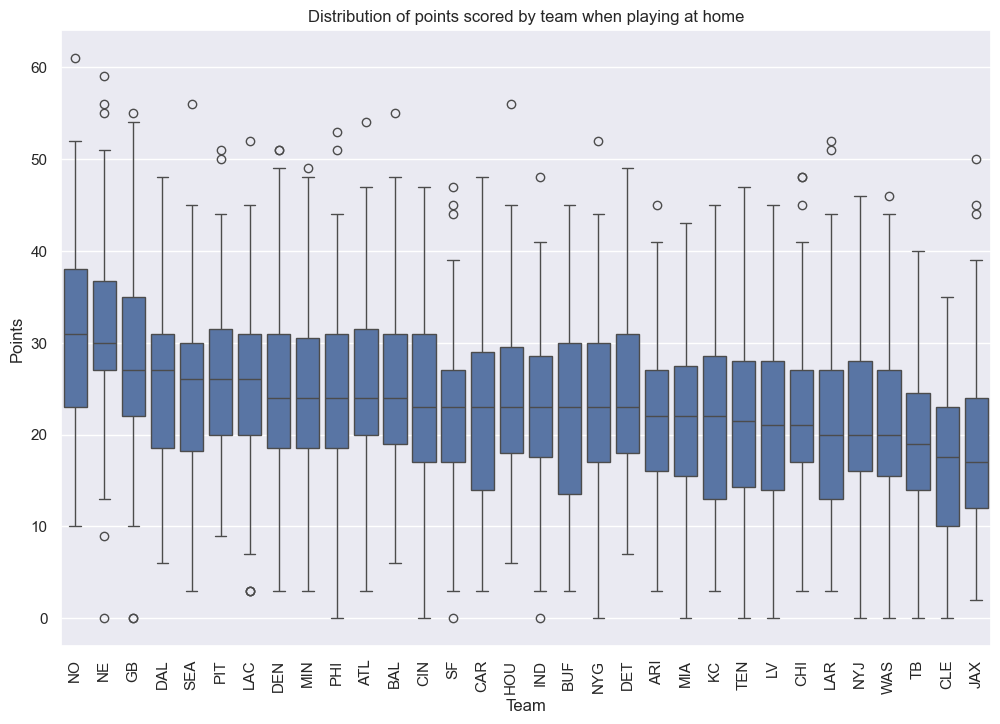

In [63]:
# Setting up a variable to sort teams by median of home pts
home_pts_median = all_games.groupby('home_team')['home_pts'].median().sort_values(ascending=False)

# Creating a box plot of home pts vs home teams
sns.set(rc={'figure.figsize':(12,8)})

sns.boxplot(y='home_pts',
            x='home_team', 
            data=all_games, 
            order=home_pts_median.index)

# Customising the box plot
plt.title("Distribution of points scored by team when playing at home")
plt.xlabel("Team")
plt.xticks(rotation=90)
plt.ylabel("Points")
plt.show()

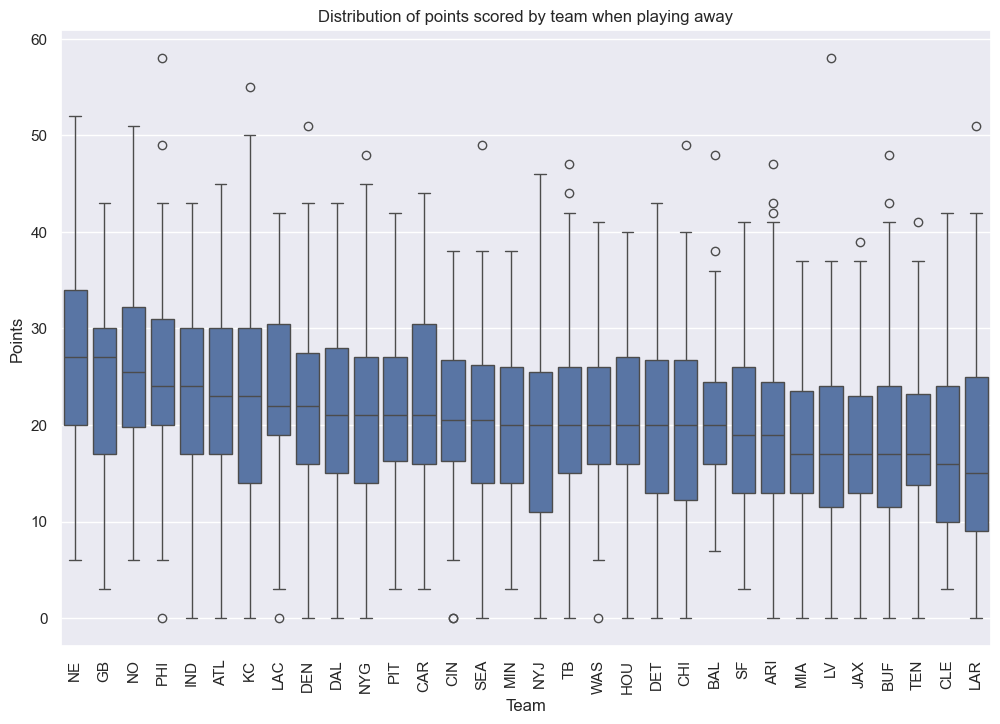

In [64]:
# Setting up a variable to sort teams by median of home pts
away_pts_median = all_games.groupby('away_team')['away_pts'].median().sort_values(ascending=False)

# Creating a box plot of home pts vs home teams
sns.set(rc={'figure.figsize':(12,8)})

sns.boxplot(y='away_pts',
            x='away_team', 
            data=all_games, 
            order=away_pts_median.index)

# Customising the box plot
plt.title("Distribution of points scored by team when playing away")
plt.xlabel("Team")
plt.xticks(rotation=90)
plt.ylabel("Points")
plt.show()

Throughout this timespan, one thing seems consistent regardless of the venue - New England Patriots, New Orleans Saints and Green Bay Packers were the best offensive teams in points!

These three teams occupy the first 3 spots on both of our charts in terms of median of points scored as a home or away team, just around or shy of the 30-point mark. Want to take a guess at a potential reason? This matches the presence of 3 of the most historic quarterbacks to ever play in the NFL for these 3 teams: **Tom Brady**, **Drew Brees** and **Aaron Rodgers**.

Unsurprisingly, between these 3 quarterbacks, they won 5 of the 9 Super Bowls that are related to the seasons we have in our dataset - 3 by Brady, and 1 each for Brees and Rodgers.

Interestingly enough, there are also a few teams who seem to be more productive points-wise in one venue compared to the other. For example, the Indianapolis Colts appear 5th in our away points chart, but pretty much middle of the pack for home points. Similar case with the Kansas City Chiefs, showing up as 7th for away points, yet also a bottom-10 team for home points.

Baltimore and San Francisco seemed to do better at home than away, as well.

Now, what about the total yards in both home and away games? Remember the question we had for the 2014 Eagles and whether 350 yards of offense was a good enough mark?

Let's see!

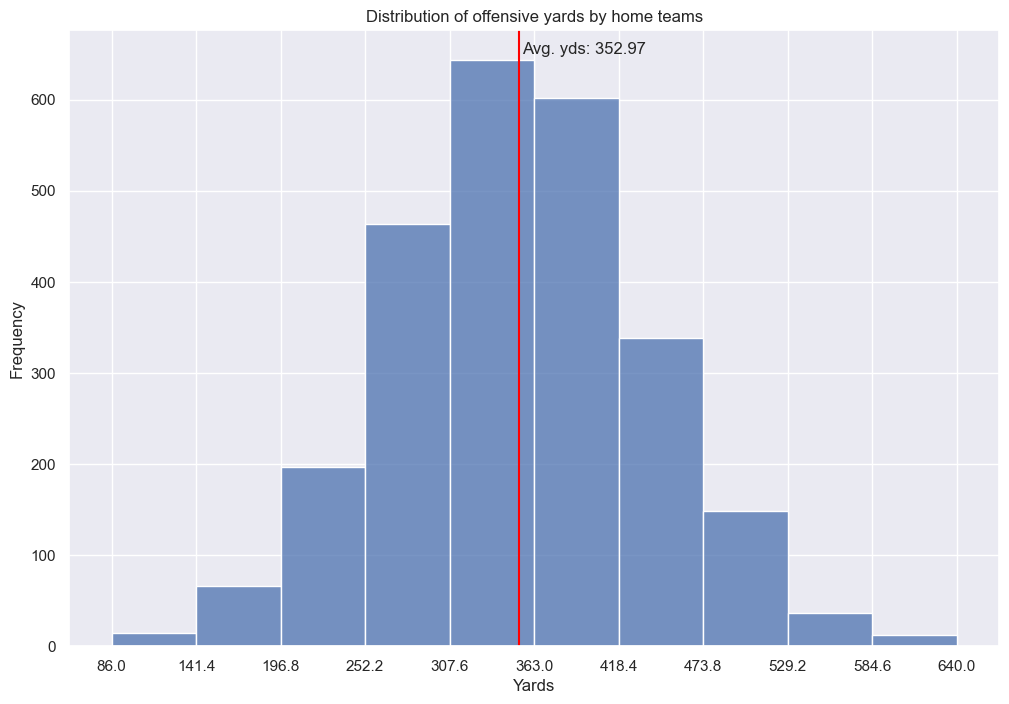

In [65]:
# Creating histogram tick marks to align the plot
hist, bins = np.histogram(all_games['home_yds'], bins=10)

# Initialising and customising a histogram plot for home yards
sns.histplot(x='home_yds', data=all_games, bins=10)
plt.title("Distribution of offensive yards by home teams")
plt.xlabel("Yards")
plt.xticks(bins)
plt.ylabel("Frequency")
plt.axvline(x=all_games['home_yds'].mean(), color='red')
plt.annotate(f"Avg. yds: {all_games['home_yds'].mean().round(2)}", (355,650))
plt.show()

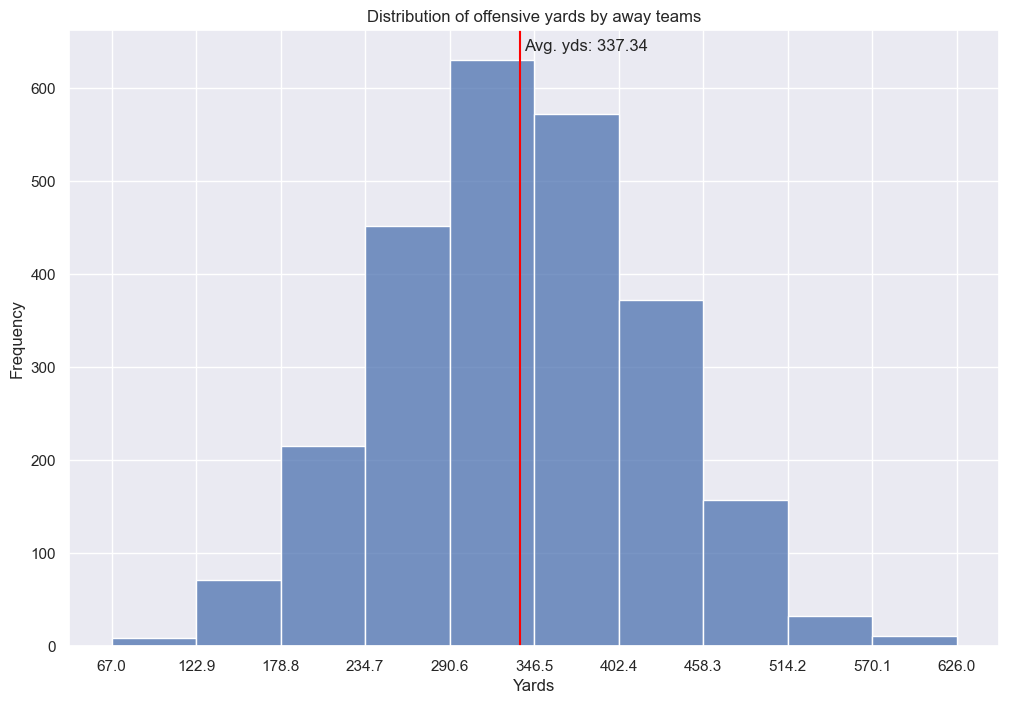

In [66]:
hist, bins = np.histogram(all_games['away_yds'], bins=10)

sns.histplot(x='away_yds', data=all_games, bins=10)
plt.title("Distribution of offensive yards by away teams")
plt.xlabel("Yards")
plt.xticks(bins)
plt.ylabel("Frequency")
plt.axvline(x=all_games['away_yds'].mean(), color='red')
plt.annotate(f"Avg. yds: {all_games['away_yds'].mean().round(2)}", (340,640))
plt.show()

Looks like the theory is confirmed! Across all 10 seasons, the average team produces somewhere between 337 to 353 yards of offense, regardless of the venue. So for the case of the 2014 Eagles, which were very consistent at putting up at least 350 yards of offense, and in most cases above 400 yards, it is good to see that they were a lot closer to the elite group of offenses.

If we want to dive deeper specifically in that 2014 season, let's narrow our analysis more:

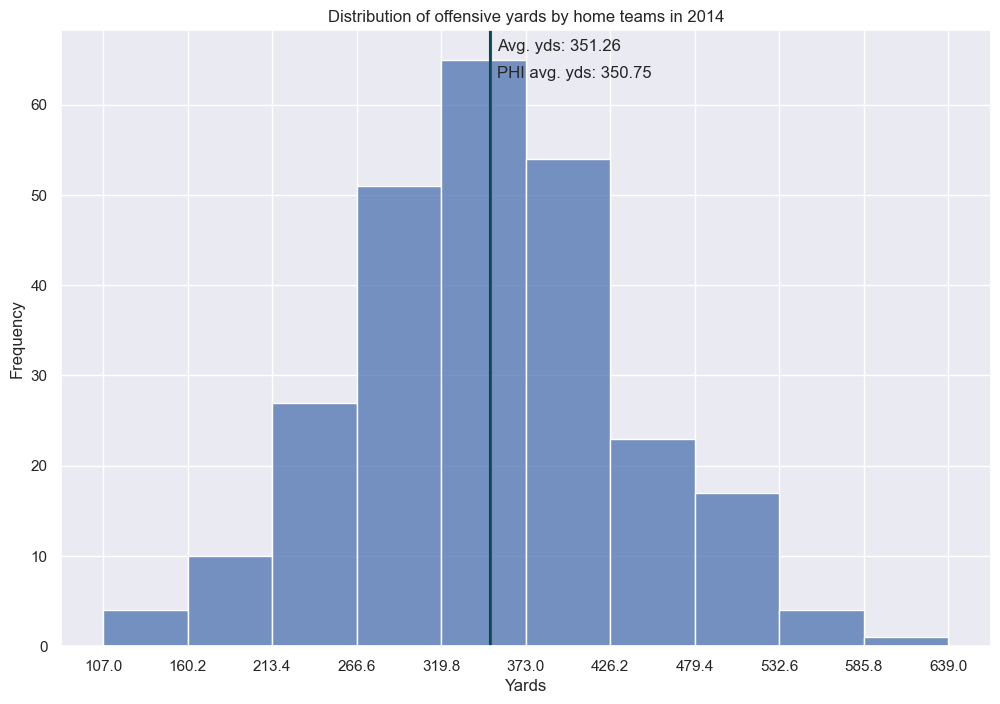

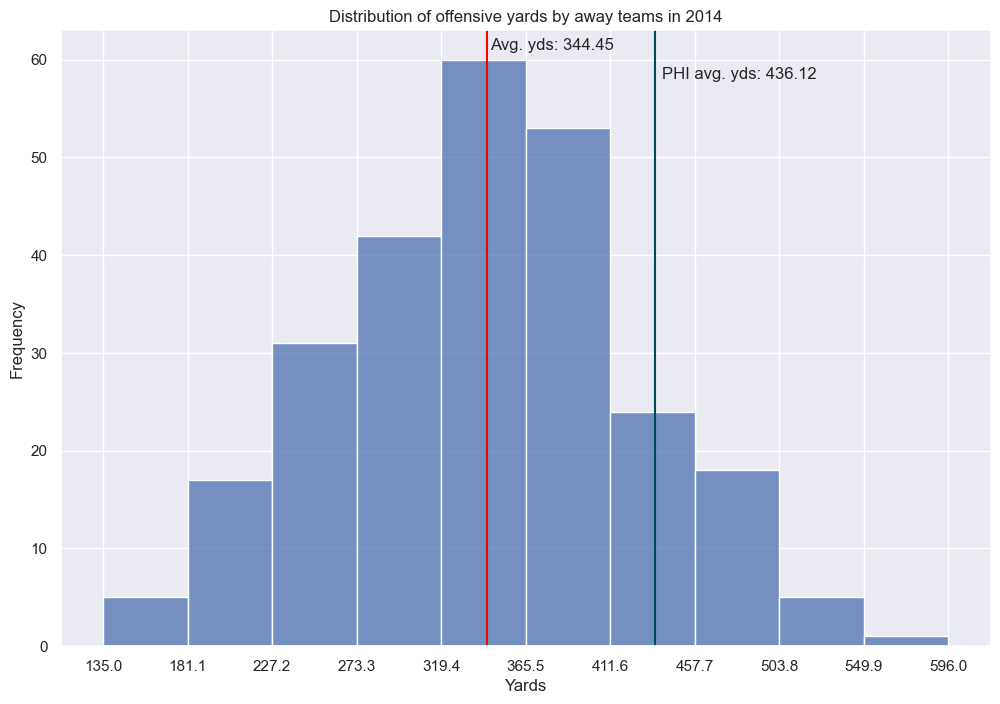

In [67]:
# Subsetting the data for games in the 2014 season, and home and away PHI games
season_2014 = all_games[all_games.season == 2014]
phi_home_2014 = season_2014[season_2014['home_team'] == 'PHI']
phi_away_2014 = season_2014[season_2014['away_team'] == 'PHI']

# Initialising the histogram for home yards
hist, bins = np.histogram(season_2014['home_yds'], bins=10)

# Customising the histogram and including an auxiliary line for PHI's avg. home yards
sns.histplot(x='home_yds', data=season_2014, bins=10)
plt.title("Distribution of offensive yards by home teams in 2014")
plt.xlabel("Yards")
plt.xticks(bins)
plt.ylabel("Frequency")
plt.axvline(x=season_2014['home_yds'].mean(), color='red')
plt.axvline(x=phi_home_2014.home_yds.mean(), color='#004c54')
plt.annotate(f"Avg. yds: {season_2014['home_yds'].mean().round(2)}", (355,66))
plt.annotate(f"PHI avg. yds: {phi_home_2014.home_yds.mean().round(2)}", (355,63))
plt.show()

# Initialising another histogram for away yards
hist, bins = np.histogram(season_2014['away_yds'], bins=10)

# Customising the away yards histogram with PHI's avg. away yards
sns.histplot(x='away_yds', data=season_2014, bins=10)
plt.title("Distribution of offensive yards by away teams in 2014")
plt.xlabel("Yards")
plt.xticks(bins)
plt.ylabel("Frequency")
plt.axvline(x=season_2014['away_yds'].mean(), color='red')
plt.axvline(x=phi_away_2014.away_yds.mean(), color='#004c54')
plt.annotate(f"Avg. yds: {season_2014['away_yds'].mean().round(2)}", (346,61))
plt.annotate(f"PHI avg. yds: {phi_away_2014.away_yds.mean().round(2)}", (440,58))
plt.show()

Remarkable difference between the 2014 Eagles performance at home and away! When playing at home, they were on right on cue with the average offensive yardage for a home team that season, but they really brought up the pace when playing in enemy territory, averaging more than 430 yards a game! Quite impressive to say, given the complications of playing offense as an away team when you include some intangible factors such as the crowd noise and the hostile environments one team can find when playing teams on the road.

Perfect! A few interesting things seen on this Section! Let's move further to start preparing our model!

## 6. Understanding correlations and creating standings

Now, it's time to dive deeper into what determines the chances of a team to win.

First, let's explore simple correlations and see which features have the most significant relationship with a home victory:

In [68]:
# Creating a subset DataFrame only for numeric stats, with correlations
df_corr = all_games.loc[:, 'home_pts':].corr(method='pearson', numeric_only=True)

In [69]:
# Returning the 25 features with the highest correlation coefficients
df_corr[['home_win']].sort_values(by='home_win', ascending=False).loc['home_pts':,:].head(25)

home_win
home_pts               0.563536
home_rush_plays        0.536366
home_rush_ratio        0.511848
away_pass_ratio        0.504133
home_xp_att            0.450493
home_xp_made           0.445136
home_yds_per_pass      0.410960
home_total_tds         0.362836
away_failed_4th_downs  0.357440
home_rush_yds          0.347845
away_ints              0.345750
away_pass_plays        0.345051
home_yds_per_play      0.330353
home_time_of_poss      0.313671
home_rush_1st_downs    0.305213
away_pass_att          0.297728
home_yds               0.293319
home_pass_tds          0.291794
home_rush_tds          0.288420
home_sack_yds          0.286204
home_sacks             0.277280
home_fg_made           0.241236
home_made_3rd_downs    0.238670
home_fg_att            0.194468
away_failed_3rd_downs  0.187231

Now, to nobody's surprise, there's something clear about football (or any sport in general) - in order to win games, you have to score more points than the other team. This result tells us pretty much that same logic, with the *home_pts* feature being the most significant in terms of correlation with a home win. Now, at 0.56, it's not an extremely high correlation, which could be explained by the fact that there are a significant number of features in our data that could also influence a home win. As we saw from previous visualisations and summary statistics, points do not always correlate with other stats such as total plays or total yards, for example.

By nature of association, some other features will have very close correlation coefficients compared to the amount of points that we wouldn't expect at first sight, such as the number of extra-points made and attempted for example. However, extra-points only occur after touchdowns, which feed the amount of points too. Therefore, we can see there are a few features that are slightly repetitive or redundant in our data.

A similar case would be seen for away wins and away stats:

In [70]:
df_corr[['away_win']].sort_values(by='away_win', ascending=False).loc['away_pts':,:].head(25)

away_win
away_pts               0.558932
away_rush_plays        0.540811
home_pass_ratio        0.508473
away_rush_ratio        0.503997
away_xp_att            0.434292
away_xp_made           0.425168
away_yds_per_pass      0.379162
home_failed_4th_downs  0.377527
away_rush_yds          0.376257
away_time_of_poss      0.374684
home_ints              0.369066
home_pass_plays        0.364824
away_total_tds         0.345316
away_rush_1st_downs    0.336756
away_rush_tds          0.324251
home_pass_att          0.321040
away_yds_per_play      0.305413
away_yds               0.286817
away_sacks             0.281862
away_fg_made           0.269907
away_sack_yds          0.266555
away_made_3rd_downs    0.254451
away_pass_tds          0.252543
away_fg_att            0.247911
home_failed_3rd_downs  0.218417

For a more visual representation, let's create a pair plot that combines all home and away stats for every team.

To do this, I'll create two separate DataFrames, one for home games and one for away games, and then concatenate both resulting DataFrames into one to have a full picture of wins by team per season.

Each separate DataFrame will aggregate certain stats by adding them all up, or by averaging them. They will be tagged with the *_for* suffix for the team's offense, and the *_ag* suffix for the team's defense.

Let's create the home games DataFrame first:

In [71]:
# Creating a home games DataFrame with named aggregations
home_games = all_games.groupby(['season', 'home_team']).agg(
    wins=('home_win', 'sum'),
    losses=('away_win', 'sum'),
    ties=('tie', 'sum'),
    pts_for=('home_pts', 'mean'),
    pts_ag=('away_pts', 'mean'),
    tot_yds_for=('home_yds', 'mean'),
    tot_yds_ag=('away_yds', 'mean'),
    plays_for=('home_plays', 'mean'),
    plays_ag=('away_plays', 'mean'),
    poss_for=('home_time_of_poss', 'mean'),
    poss_ag=('away_time_of_poss', 'mean'),
    yds_play_for=('home_yds_per_play', 'mean'),
    yds_play_ag=('away_yds_per_play', 'mean'),
    drives_for=('home_drives', 'mean'),
    drives_ag=('away_drives', 'mean'),
    drive_plays_for=('home_plays_per_drive', 'mean'),
    drive_plays_ag=('away_plays_per_drive', 'mean'),
    rush_ratio_for=('home_rush_ratio', 'mean'),
    rush_ratio_ag=('away_rush_ratio', 'mean'),
    pass_ratio_for=('home_pass_ratio', 'mean'),
    pass_ratio_ag=('away_pass_ratio', 'mean'),
    rushes_for=('home_rush_plays', 'mean'),
    rushes_ag=('away_rush_plays', 'mean'),
    rush_yds_for=('home_rush_yds', 'mean'),
    rush_yds_ag=('away_rush_yds', 'mean'),
    yds_per_rush_for=('home_yds_per_rush', 'mean'),
    yds_per_rush_ag=('away_yds_per_rush', 'mean'),
    passes_for=('home_pass_plays', 'mean'),
    passes_ag=('away_pass_plays', 'mean'),
    pass_yds_for=('home_pass_yds', 'mean'),
    pass_yds_ag=('away_pass_yds', 'mean'),
    yds_per_pass_for=('home_yds_per_pass', 'mean'),
    yds_per_pass_ag=('away_yds_per_pass', 'mean'),
    pass_comp_for=('home_pass_comp', 'mean'),
    pass_comp_ag=('away_pass_comp', 'mean'),
    pass_att_for=('home_pass_att', 'mean'),
    pass_att_ag=('away_pass_att', 'mean'),
    sacks_for=('home_sacks', 'sum'),
    sacks_ag=('away_sacks', 'sum'),
    sack_yds_for=('home_sack_yds', 'mean'),
    sack_yds_ag=('away_sack_yds', 'mean'),
    rush_tds_for=('home_rush_tds', 'sum'),
    rush_tds_ag=('away_rush_tds', 'sum'),
    pass_tds_for=('home_pass_tds', 'sum'),
    pass_tds_ag=('away_pass_tds', 'sum'),
    dst_tds_for=('home_dst_tds', 'sum'),
    dst_tds_ag=('away_dst_tds', 'sum'),
    tot_tds_for=('home_total_tds', 'sum'),
    tot_tds_ag=('away_total_tds', 'sum'),
    fg_made_for=('home_fg_made', 'sum'),
    fg_made_ag=('away_fg_made', 'sum'),
    fg_att_for=('home_fg_att', 'sum'),
    fg_att_ag=('away_fg_att', 'sum'),
    xp_made_for=('home_xp_made', 'sum'),
    xp_made_ag=('away_xp_made', 'sum'),
    xp_att_for=('home_xp_att', 'sum'),
    xp_att_ag=('away_xp_att', 'sum'),
    made_2pt_for=('home_2pt_made', 'sum'),
    made_2pt_ag=('away_2pt_made', 'sum'),
    att_2pt_for=('home_2pt_att', 'sum'),
    att_2pt_ag=('away_2pt_att', 'sum'),
    punts_for=('home_punts', 'mean'),
    punts_ag=('away_punts', 'mean'),
    fumbles_for=('home_fumbles', 'sum'),
    fumbles_ag=('away_fumbles', 'sum'),
    ints_for=('home_ints', 'sum'),
    ints_ag=('away_ints', 'sum'),
    rush_1d_for=('home_rush_1st_downs', 'mean'),
    rush_1d_ag=('away_rush_1st_downs', 'mean'),
    pass_1d_for=('home_pass_1st_downs', 'mean'),
    pass_1d_ag=('away_pass_1st_downs', 'mean'),
    pen_1d_for=('home_penalty_1st_downs', 'mean'),
    pen_1d_ag=('away_penalty_1st_downs', 'mean'),
    made_3d_for=('home_made_3rd_downs', 'mean'),
    made_3d_ag=('away_made_3rd_downs', 'mean'),
    failed_3d_for=('home_failed_3rd_downs', 'mean'),
    failed_3d_ag=('away_failed_3rd_downs', 'mean'),
    made_4d_for=('home_made_4th_downs', 'mean'),
    made_4d_ag=('away_made_4th_downs', 'mean'),
    failed_4d_for=('home_failed_4th_downs', 'mean'),
    failed_4d_ag=('away_failed_4th_downs', 'mean')
).reset_index()

home_games

season home_team  wins  losses  ties    pts_for     pts_ag  tot_yds_for  \
0      2009       ARI     4       4     0  21.625000  23.000000   342.000000   
1      2009       ATL     6       2     0  22.250000  17.125000   323.250000   
2      2009       BAL     6       2     0  28.625000  11.625000   396.250000   
3      2009       BUF     3       5     0  17.000000  17.625000   293.375000   
4      2009       CAR     5       3     0  18.625000  17.375000   330.250000   
..      ...       ...   ...     ...   ...        ...        ...          ...   
315    2018       SEA     4       2     0  27.000000  19.666667   334.833333   
316    2018        SF     4       3     0  23.000000  22.857143   362.857143   
317    2018        TB     4       3     0  21.142857  20.428571   407.714286   
318    2018       TEN     5       1     0  23.000000  16.500000   333.333333   
319    2018       WAS     3       4     0  19.000000  24.428571   321.285714   

     tot_yds_ag  plays_for   plays_ag     poss_for      poss_ag  yds_play_for  \
0    356.125000  60.125000  65.250000  1723.000000  1882.500000      5.691151   
1    331.375000  62.500000  59.875000  1758.750000  1835.000000      5.263530   
2    262.375000  65.250000  57.875000  1916.875000  1735.375000      6.065315   
3    300.250000  58.125000  63.375000  1730.375000  1842.375000      5.004451   
4    284.625000  64.000000  59.000000  2021.000000  1752.250000      5.206656   
..          ...        ...        ...          ...          ...           ...   
315  372.166667  61.500000  57.333333  1922.666667  1675.333333      5.564274   
316  307.000000  63.857143  60.428571  1873.571429  1782.714286      5.836980   
317  357.428571  67.142857  62.142857  1835.571429  1830.000000      6.126234   
318  341.500000  56.666667  67.000000  1767.666667  1928.166667      5.730709   
319  358.428571  62.571429  60.857143  1856.571429  1743.142857      5.220040   

     yds_play_ag  drives_for  drives_ag  drive_plays_for  drive_plays_ag  \
0       5.420357   12.500000  12.125000         5.030540        5.541448   
1       5.487233   10.250000  10.250000         6.345581        6.182314   
2       4.533486   11.500000  12.000000         5.969557        5.239880   
3       4.670917   12.000000  12.375000         5.076603        5.374519   
4       4.744130   12.750000  12.125000         5.255952        5.140793   
..           ...         ...        ...              ...             ...   
315     6.529314   11.166667  11.000000         5.800000        5.394444   
316     5.080518   11.857143  12.000000         5.772527        5.455628   
317     5.762537   12.142857  12.142857         5.846104        5.578596   
318     5.106337   11.166667  11.666667         5.316848        6.064957   
319     5.890242   11.428571  11.285714         5.688837        5.789940   

     rush_ratio_for  rush_ratio_ag  pass_ratio_for  pass_ratio_ag  rushes_for  \
0          0.321444       0.423307        0.678556       0.576693   20.375000   
1          0.423645       0.410323        0.576355       0.589677   27.500000   
2          0.475683       0.458626        0.524317       0.541374   31.625000   
3          0.469029       0.504985        0.530971       0.495015   28.125000   
4          0.496185       0.453339        0.503815       0.546661   32.375000   
..              ...            ...             ...            ...         ...   
315        0.553022       0.365485        0.446978       0.634515   34.833333   
316        0.442256       0.421770        0.557744       0.578230   29.142857   
317        0.361325       0.373285        0.638675       0.626715   24.857143   
318        0.457232       0.382493        0.542768       0.617507   26.666667   
319        0.418288       0.399026        0.581712       0.600974   26.142857   

     rushes_ag  rush_yds_for  rush_yds_ag  yds_per_rush_for  yds_per_rush_ag  \
0    27.500000     75.250000   111.125000          3.721115         3.885801   
1    24.750000    107.500

Now, let's do the same for the away team:

In [72]:
away_games = all_games.groupby(['season', 'away_team']).agg(
    wins=('away_win', 'sum'),
    losses=('home_win', 'sum'),
    ties=('tie', 'sum'),
    pts_for=('away_pts', 'mean'),
    pts_ag=('home_pts', 'mean'),
    tot_yds_for=('away_yds', 'mean'),
    tot_yds_ag=('home_yds', 'mean'),
    plays_for=('away_plays', 'mean'),
    plays_ag=('home_plays', 'mean'),
    poss_for=('away_time_of_poss', 'mean'),
    poss_ag=('home_time_of_poss', 'mean'),
    yds_play_for=('away_yds_per_play', 'mean'),
    yds_play_ag=('home_yds_per_play', 'mean'),
    drives_for=('away_drives', 'mean'),
    drives_ag=('home_drives', 'mean'),
    drive_plays_for=('away_plays_per_drive', 'mean'),
    drive_plays_ag=('home_plays_per_drive', 'mean'),
    rush_ratio_for=('away_rush_ratio', 'mean'),
    rush_ratio_ag=('home_rush_ratio', 'mean'),
    pass_ratio_for=('away_pass_ratio', 'mean'),
    pass_ratio_ag=('home_pass_ratio', 'mean'),
    rushes_for=('away_rush_plays', 'mean'),
    rushes_ag=('home_rush_plays', 'mean'),
    rush_yds_for=('away_rush_yds', 'mean'),
    rush_yds_ag=('home_rush_yds', 'mean'),
    yds_per_rush_for=('away_yds_per_rush', 'mean'),
    yds_per_rush_ag=('home_yds_per_rush', 'mean'),
    passes_for=('away_pass_plays', 'mean'),
    passes_ag=('home_pass_plays', 'mean'),
    pass_yds_for=('away_pass_yds', 'mean'),
    pass_yds_ag=('home_pass_yds', 'mean'),
    yds_per_pass_for=('away_yds_per_pass', 'mean'),
    yds_per_pass_ag=('home_yds_per_pass', 'mean'),
    pass_comp_for=('away_pass_comp', 'mean'),
    pass_comp_ag=('home_pass_comp', 'mean'),
    pass_att_for=('away_pass_att', 'mean'),
    pass_att_ag=('home_pass_att', 'mean'),
    sacks_for=('away_sacks', 'sum'),
    sacks_ag=('home_sacks', 'sum'),
    sack_yds_for=('away_sack_yds', 'mean'),
    sack_yds_ag=('home_sack_yds', 'mean'),
    rush_tds_for=('away_rush_tds', 'sum'),
    rush_tds_ag=('home_rush_tds', 'sum'),
    pass_tds_for=('away_pass_tds', 'sum'),
    pass_tds_ag=('home_pass_tds', 'sum'),
    dst_tds_for=('away_dst_tds', 'sum'),
    dst_tds_ag=('home_dst_tds', 'sum'),
    tot_tds_for=('away_total_tds', 'sum'),
    tot_tds_ag=('home_total_tds', 'sum'),
    fg_made_for=('away_fg_made', 'sum'),
    fg_made_ag=('home_fg_made', 'sum'),
    fg_att_for=('away_fg_att', 'sum'),
    fg_att_ag=('home_fg_att', 'sum'),
    xp_made_for=('away_xp_made', 'sum'),
    xp_made_ag=('home_xp_made', 'sum'),
    xp_att_for=('away_xp_att', 'sum'),
    xp_att_ag=('home_xp_att', 'sum'),
    made_2pt_for=('away_2pt_made', 'sum'),
    made_2pt_ag=('home_2pt_made', 'sum'),
    att_2pt_for=('away_2pt_att', 'sum'),
    att_2pt_ag=('home_2pt_att', 'sum'),
    punts_for=('away_punts', 'mean'),
    punts_ag=('home_punts', 'mean'),
    fumbles_for=('away_fumbles', 'sum'),
    fumbles_ag=('home_fumbles', 'sum'),
    ints_for=('away_ints', 'sum'),
    ints_ag=('home_ints', 'sum'),
    rush_1d_for=('away_rush_1st_downs', 'mean'),
    rush_1d_ag=('home_rush_1st_downs', 'mean'),
    pass_1d_for=('away_pass_1st_downs', 'mean'),
    pass_1d_ag=('home_pass_1st_downs', 'mean'),
    pen_1d_for=('away_penalty_1st_downs', 'mean'),
    pen_1d_ag=('home_penalty_1st_downs', 'mean'),
    made_3d_for=('away_made_3rd_downs', 'mean'),
    made_3d_ag=('home_made_3rd_downs', 'mean'),
    failed_3d_for=('away_failed_3rd_downs', 'mean'),
    failed_3d_ag=('home_failed_3rd_downs', 'mean'),
    made_4d_for=('away_made_4th_downs', 'mean'),
    made_4d_ag=('home_made_4th_downs', 'mean'),
    failed_4d_for=('away_failed_4th_downs', 'mean'),
    failed_4d_ag=('home_failed_4th_downs', 'mean')
).reset_index()

away_games

season away_team  wins  losses  ties    pts_for     pts_ag  tot_yds_for  \
0      2009       ARI     6       2     0  25.000000  17.250000   346.750000   
1      2009       ATL     3       5     0  22.750000  23.125000   357.625000   
2      2009       BAL     3       5     0  20.000000  20.750000   306.125000   
3      2009       BUF     3       5     0  15.000000  21.875000   254.375000   
4      2009       CAR     3       5     0  20.625000  20.250000   332.375000   
..      ...       ...   ...     ...   ...        ...        ...          ...   
315    2018       SEA     4       4     0  25.000000  21.625000   360.500000   
316    2018        SF     0       7     0  19.857143  30.142857   365.857143   
317    2018        TB     1       6     0  27.857143  36.714286   426.000000   
318    2018       TEN     3       5     0  16.500000  19.000000   306.125000   
319    2018       WAS     4       3     0  18.714286  19.428571   309.857143   

     tot_yds_ag  plays_for   plays_ag     poss_for      poss_ag  yds_play_for  \
0    337.375000  59.750000  62.875000  1889.000000  1725.125000      5.811009   
1    366.375000  65.625000  63.125000  1824.500000  1806.250000      5.463238   
2    338.625000  59.875000  63.750000  1615.750000  2087.500000      5.092985   
3    381.375000  54.625000  70.375000  1660.250000  2193.000000      4.687335   
4    347.000000  61.875000  61.250000  1750.375000  1845.250000      5.374198   
..          ...        ...        ...          ...          ...           ...   
315  350.375000  60.625000  59.750000  1850.250000  1789.000000      5.967270   
316  383.428571  62.000000  64.285714  1763.428571  1830.285714      5.919927   
317  416.571429  63.285714  59.714286  1818.857143  1779.285714      6.698880   
318  319.625000  61.000000  56.875000  1899.500000  1709.125000      5.034497   
319  356.857143  59.285714  61.428571  1786.285714  1819.857143      5.230803   

     yds_play_ag  drives_for  drives_ag  drive_plays_for  drive_plays_ag  \
0       5.259895   12.625000  12.625000         5.152433        5.160714   
1       5.801812   11.375000  11.500000         6.190773        5.834343   
2       5.294604   11.625000  11.875000         5.384652        5.711247   
3       5.435308   11.875000  11.875000         4.746743        6.165997   
4       5.684867   11.500000  11.000000         5.703414        5.880643   
..           ...         ...        ...              ...             ...   
315     5.843767   11.000000  10.875000         5.655682        6.073665   
316     6.020980   11.142857  11.285714         5.763492        5.904978   
317     7.066282   11.428571  11.142857         5.809152        5.729509   
318     5.744764   10.125000  10.375000         6.276326        5.935890   
319     5.728087   10.857143  10.714286         6.002597        6.077778   

     rush_ratio_for  rush_ratio_ag  pass_ratio_for  pass_ratio_ag  rushes_for  \
0          0.397850       0.349259        0.602150       0.650741   25.125000   
1          0.425303       0.447652        0.574697       0.552348   28.875000   
2          0.441942       0.409462        0.558058       0.590538   26.750000   
3          0.442174       0.471598        0.557826       0.528402   25.000000   
4          0.523019       0.463762        0.476981       0.536238   33.375000   
..              ...            ...             ...            ...         ...   
315        0.500759       0.398336        0.499241       0.601664   31.000000   
316        0.425001       0.408661        0.574999       0.591339   26.285714   
317        0.383050       0.467133        0.616950       0.532867   24.571429   
318        0.502513       0.427999        0.497487       0.572001   31.375000   
319        0.427801       0.393360        0.572199       0.606640   26.428571   

     rushes_ag  rush_yds_for  rush_yds_ag  yds_per_rush_for  yds_per_rush_ag  \
0    22.750000    113.000000   115.375000          4.632709         4.931215   
1    29.250000    128.875

The size of these two DataFrames is consistent with the data we're looking at - 10 seasons of data for 32 teams, totalling 320 rows. For each DataFrame, each team will have played 8 home games and 8 away games, as it was regularly scheduled every season back then, with the exception of the 2018 season missing 2 weeks, for which some teams will have played either 7 games at each venue, or their full 8 games in one venue and 6 in the other venue.

Now, in each DataFrame, let's rename the team columns to simply be called *team*, since this will be the column that will serve as the argument for a third and last grouping method:

In [73]:
# Renaming home and away team columns in both DataFrames
home_games.rename(columns={'home_team': 'team'}, inplace=True)
away_games.rename(columns={'away_team': 'team'}, inplace=True)

Finally, let's concatenate both DataFrames and perform the respective aggregations for each column:

In [74]:
# Creating a dictionary of columns as keys and aggregations as values
aggs = {
 'wins': 'sum',
 'losses': 'sum',
 'ties': 'sum',
 'pts_for': 'mean',
 'pts_ag': 'mean',
 'tot_yds_for': 'mean',
 'tot_yds_ag': 'mean',
 'plays_for': 'mean',
 'plays_ag': 'mean',
 'poss_for': 'mean',
 'poss_ag': 'mean',
 'yds_play_for': 'mean',
 'yds_play_ag': 'mean',
 'drives_for': 'mean',
 'drives_ag': 'mean',
 'drive_plays_for': 'mean',
 'drive_plays_ag': 'mean',
 'rush_ratio_for': 'mean',
 'rush_ratio_ag': 'mean',
 'pass_ratio_for': 'mean',
 'pass_ratio_ag': 'mean',
 'rushes_for': 'mean',
 'rushes_ag': 'mean',
 'rush_yds_for': 'mean',
 'rush_yds_ag': 'mean',
 'yds_per_rush_for': 'mean',
 'yds_per_rush_ag': 'mean',
 'passes_for': 'mean',
 'passes_ag': 'mean',
 'pass_yds_for': 'mean',
 'pass_yds_ag': 'mean',
 'yds_per_pass_for': 'mean',
 'yds_per_pass_ag': 'mean',
 'pass_comp_for': 'mean',
 'pass_comp_ag': 'mean',
 'pass_att_for': 'mean',
 'pass_att_ag': 'mean',
 'sacks_for': 'sum',
 'sacks_ag': 'sum',
 'sack_yds_for': 'mean',
 'sack_yds_ag': 'mean',
 'rush_tds_for': 'sum',
 'rush_tds_ag': 'sum',
 'pass_tds_for': 'sum',
 'pass_tds_ag': 'sum',
 'dst_tds_for': 'sum',
 'dst_tds_ag': 'sum',
 'tot_tds_for': 'sum',
 'tot_tds_ag': 'sum',
 'fg_made_for': 'sum',
 'fg_made_ag': 'sum',
 'fg_att_for': 'sum',
 'fg_att_ag': 'sum',
 'xp_made_for': 'sum',
 'xp_made_ag': 'sum',
 'xp_att_for': 'sum',
 'xp_att_ag': 'sum',
 'made_2pt_for': 'sum',
 'made_2pt_ag': 'sum',
 'att_2pt_for': 'sum',
 'att_2pt_ag': 'sum',
 'punts_for': 'mean',
 'punts_ag': 'mean',
 'fumbles_for': 'sum',
 'fumbles_ag': 'sum',
 'ints_for': 'sum',
 'ints_ag': 'sum',
 'rush_1d_for': 'mean',
 'rush_1d_ag': 'mean',
 'pass_1d_for': 'mean',
 'pass_1d_ag': 'mean',
 'pen_1d_for': 'mean',
 'pen_1d_ag': 'mean',
 'made_3d_for': 'mean',
 'made_3d_ag': 'mean',
 'failed_3d_for': 'mean',
 'failed_3d_ag': 'mean',
 'made_4d_for': 'mean',
 'made_4d_ag': 'mean',
 'failed_4d_for': 'mean',
 'failed_4d_ag': 'mean'
}

# Creating a final DataFrame with all stats grouped by season and team
all_seasons = pd.concat([home_games, away_games]).groupby(['season','team']).agg(aggs).reset_index()
all_seasons

season team  wins  losses  ties    pts_for     pts_ag  tot_yds_for  \
0      2009  ARI    10       6     0  23.312500  20.125000   344.375000   
1      2009  ATL     9       7     0  22.500000  20.125000   340.437500   
2      2009  BAL     9       7     0  24.312500  16.187500   351.187500   
3      2009  BUF     6      10     0  16.000000  19.750000   273.875000   
4      2009  CAR     8       8     0  19.625000  18.812500   331.312500   
..      ...  ...   ...     ...   ...        ...        ...          ...   
315    2018  SEA     8       6     0  26.000000  20.645833   347.666667   
316    2018   SF     4      10     0  21.428571  26.500000   364.357143   
317    2018   TB     5       9     0  24.500000  28.571429   416.857143   
318    2018  TEN     8       6     0  19.750000  17.750000   319.729167   
319    2018  WAS     7       7     0  18.857143  21.928571   315.571429   

     tot_yds_ag  plays_for   plays_ag     poss_for      poss_ag  yds_play_for  \
0    346.750000  59.937500  64.062500  1806.000000  1803.812500      5.751080   
1    348.875000  64.062500  61.500000  1791.625000  1820.625000      5.363384   
2    300.500000  62.562500  60.812500  1766.312500  1911.437500      5.579150   
3    340.812500  56.375000  66.875000  1695.312500  2017.687500      4.845893   
4    315.812500  62.937500  60.125000  1885.687500  1798.750000      5.290427   
..          ...        ...        ...          ...          ...           ...   
315  361.270833  61.062500  58.541667  1886.458333  1732.166667      5.765772   
316  345.214286  62.928571  62.357143  1818.500000  1806.500000      5.878454   
317  387.000000  65.214286  60.928571  1827.214286  1804.642857      6.412557   
318  330.562500  58.833333  61.937500  1833.583333  1818.645833      5.382603   
319  357.642857  60.928571  61.142857  1821.428571  1781.500000      5.225421   

     yds_play_ag  drives_for  drives_ag  drive_plays_for  drive_plays_ag  \
0       5.340126   12.562500  12.375000         5.091487        5.351081   
1       5.644523   10.812500  10.875000         6.268177        6.008329   
2       4.914045   11.562500  11.937500         5.677104        5.475563   
3       5.053113   11.937500  12.125000         4.911673        5.770258   
4       5.214499   12.125000  11.562500         5.479683        5.510718   
..           ...         ...        ...              ...             ...   
315     6.186540   11.083333  10.937500         5.727841        5.734055   
316     5.550749   11.500000  11.642857         5.768010        5.680303   
317     6.414409   11.785714  11.642857         5.827628        5.654053   
318     5.425551   10.645833  11.020833         5.796587        6.000424   
319     5.809165   11.142857  11.000000         5.845717        5.933859   

     rush_ratio_for  rush_ratio_ag  pass_ratio_for  pass_ratio_ag  rushes_for  \
0          0.359647       0.386283        0.640353       0.613717   22.750000   
1          0.424474       0.428988        0.575526       0.571012   28.187500   
2          0.458813       0.434044        0.541187       0.565956   29.187500   
3          0.455601       0.488291        0.544399       0.511709   26.562500   
4          0.509602       0.458550        0.490398       0.541450   32.875000   
..              ...            ...             ...            ...         ...   
315        0.526891       0.381911        0.473109       0.618089   32.916667   
316        0.433628       0.415216        0.566372       0.584784   27.714286   
317        0.372187       0.420209        0.627813       0.579791   24.714286   
318        0.479872       0.405246        0.520128       0.594754   29.020833   
319        0.423044       0.396193        0.576956       0.603807   26.285714   

     rushes_ag  rush_yds_for  rush_yds_ag  yds_per_rush_for  yds_per_rush_ag  \
0    25.125000     94.125000   113.250000          4.176912         4.408508   
1    27.000000    118.187500   107.312500          4.309212         4.015261   
2    

There we have it! A full dataset with the standings and aggregated season stats for every team in every season between 2009 and 2018. Let's now check some correlations with this whole dataset:

In [75]:
# Creating a DataFrame with all correlations
all_corr = all_seasons.loc[:, 'wins':].corr(method='pearson', numeric_only=True)

In [76]:
# Sorting the most significant correlations for total wins
sorted_corrs = all_corr[['wins']].loc['pts_for':,:].sort_values(by=['wins'], ascending=False).head(20)
sorted_corrs

wins
pts_for           0.742723
xp_att_for        0.693891
xp_made_for       0.690956
pass_ratio_ag     0.626196
tot_tds_for       0.619451
yds_per_pass_for  0.618103
yds_play_for      0.552380
pass_tds_for      0.548546
failed_4d_ag      0.536107
tot_yds_for       0.527313
poss_for          0.486900
passes_ag         0.458071
rush_tds_for      0.454572
ints_ag           0.453318
pass_att_ag       0.421514
rushes_for        0.403919
made_3d_for       0.381394
rush_1d_for       0.379541
pass_yds_for      0.366990
fg_made_for       0.365845

With all games aggregated for every team, the obvious theory of "you need more points to win more games" takes a bit more relevance now, with the correlation coefficient of *pts_for* increasing to 0.74.

If we take out a few of the naturally associated features out of the way to plot their correlation, we'll probably have a more interesting analysis here, so let's do that.

Let's consider features such as *pass_ratio_ag*, *yds_per_pass_for*, *yds_play_for*, *failed_4d_ag*, and *poss_for*:

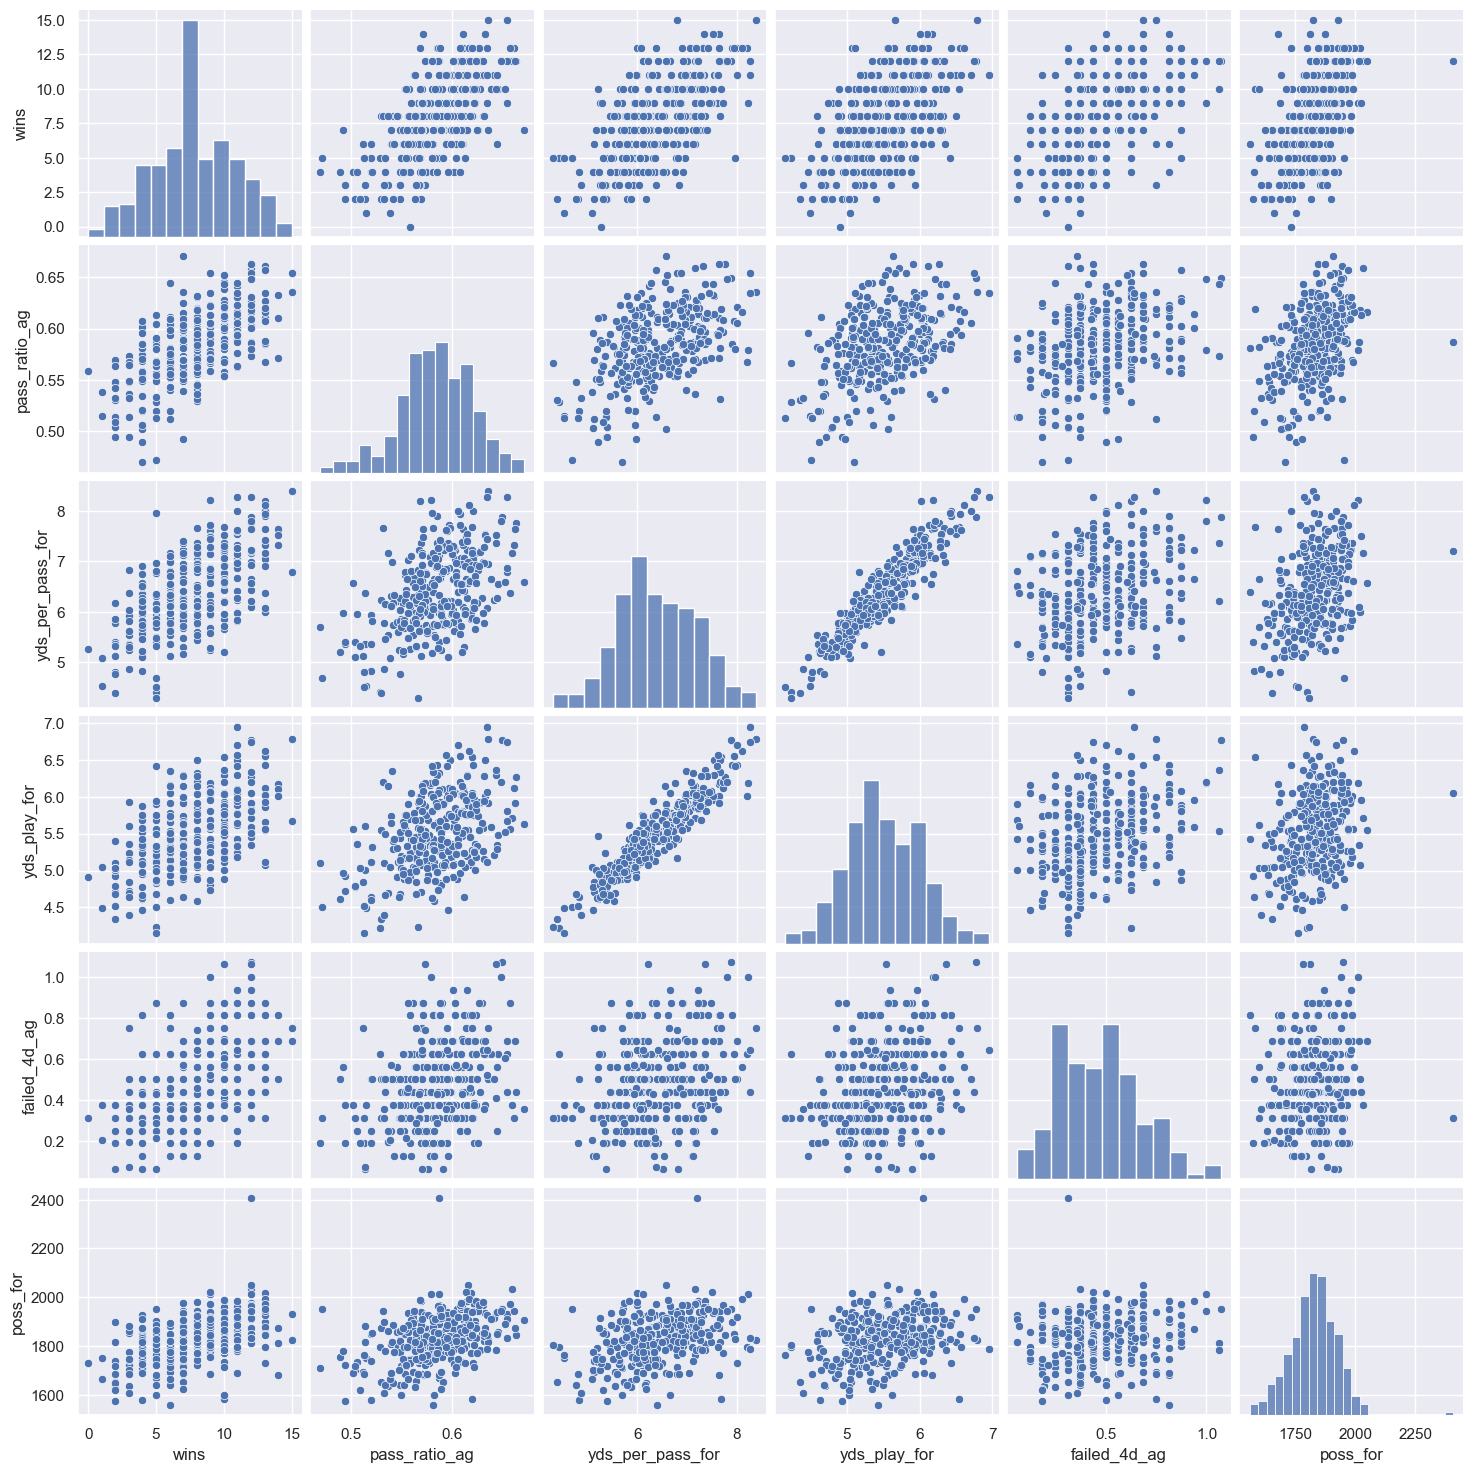

In [77]:
# Selecting the features of interest and plotting a correlation matrix
features = ['wins', 'pass_ratio_ag', 'yds_per_pass_for', 'yds_play_for', 'failed_4d_ag', 'poss_for']
sns.pairplot(all_seasons[features])

Although the correlation between all these 5 features and total wins is not extremely strong, it is clear that there's a trend of more wins for a team that has advantage in these stats.

It can be seen that the passing game had a bigger influence in the number of team wins, and maybe this has to do with the fact that the winningest teams during this timeframe had elite quarterbacks (such as the 3 we mentioned in the previous section) and were racking up passing yards season after season.

The interesting, yet not extremely surprising feature, that we can see in this matrix is the *failed_4d_ag* feature, which translate to failed 4th down attempts by opposing teams. This is fairly easy to explain though, since teams that are losing a game tend to attempt more 4th downs than the team they're playing against, and if failed, it basically translates to a confirmed loss for such games.

Let's now move on to the steps prior to our model!

## 7. Building our predictive model

The model that I'll attempt to use for this exercise will be based on the results of every game played throughout the 2009-to-2018 seasons, and it will be a Decision Tree Classifier model that will attempt to predict, based on certain stats for every game, who won (or will win) every game.

The first step to do this is to compile the three result dummy features into a single *results* feature, with 'home', 'away', or 'tie' labels.

In [78]:
# Resetting the all_games DataFrame index
all_games = all_games.reset_index(drop=True)

# Creating a game_winner column with all dummy features
game_winner = pd.from_dummies(all_games[['home_win', 'away_win', 'tie']])
game_winner = game_winner.apply(lambda x: x.str.strip('_win'))
game_winner

0     home
1     home
2     home
3     away
4     away
...    ...
2518  away
2519  home
2520  home
2521  away
2522  away

[2523 rows x 1 columns]

In [79]:
# Insert the resulting game_winner column into the DataFrame and dropping the dummy features
all_games.insert(7, 'result', game_winner)
all_games.drop(columns=['home_win', 'away_win', 'tie'], inplace=True)
all_games.head()

season     game_id  game_date home_team away_team  home_pts  away_pts  \
0    2009  2009091000 2009-09-10       PIT       TEN        13        10   
1    2009  2009091300 2009-09-13       ATL       MIA        19         7   
2    2009  2009091301 2009-09-13       BAL        KC        38        23   
3    2009  2009091302 2009-09-13       CAR       PHI        10        36   
4    2009  2009091303 2009-09-13       CIN       DEN         7        12   

  result  home_yds  away_yds  home_plays  away_plays  home_time_of_poss  \
0   home     357.0     320.0          70          61             2165.0   
1   home     281.0     259.0          62          55             1831.0   
2   home     501.0     188.0          85          44             2381.0   
3   away     169.0     267.0          68          62             1751.0   
4   away     307.0     302.0          63          52             2005.0   

   away_time_of_poss  home_yds_per_play  away_yds_per_play  home_drives  \
0             1693.0           5.100000           5.245902           13   
1             1747.0           4.596774           4.709091           11   
2             1211.0           5.894118           4.272727           11   
3             1897.0           2.500000           4.322581           15   
4             1593.0           4.873016           5.807692           11   

   away_drives  home_plays_per_drive  away_plays_per_drive  home_rush_ratio  \
0           12              5.384615              5.083333         0.328571   
1           11              5.636364              5.000000         0.387097   
2           11              7.727273              4.000000         0.482353   
3           14              4.857143              5.166667         0.426471   
4           11              5.727273              4.727273         0.428571   

   away_rush_ratio  home_pass_ratio  away_pass_ratio  home_rush_plays  \
0         0.409836         0.671429         0.590164             23.0   
1         0.400000         0.612903         0.600000             27.0   
2         0.386364         0.517647         0.613636             41.0   
3         0.500000         0.573529         0.500000             30.0   
4         0.384615         0.571429         0.615385             27.0   

   away_rush_plays  home_rush_yds  away_rush_yds  home_yds_per_rush  \
0             25.0           36.0           86.0           1.565217   
1             22.0           72.0           96.0           3.000000   
2             17.0          198.0           29.0           4.829268   
3             32.0           87.0          186.0           3.000000   
4             20.0           86.0           75.0           3.185185   

   away_yds_per_rush  home_pass_plays  away_pass_plays  home_pass_yds  \
0           3.440000             47.0             36.0          321.0   
1           4.363636             38.0             34.0          213.0   
2           1.705882             44.0             27.0          303.0   
3           6.000000             39.0             31.0           83.0   
4           3.750000             36.0             32.0          221.0   

   away_pass_yds  home_yds_per_pass  away_yds_per_pass  home_pass_comp  \
0          234.0           6.829787           6.500000            33.0   
1          163.0           5.605263           4.939394            22.0   
2          159.0           6.886364           5.888889            26.0   
3           82.0           2.128205           2.645161            14.0   
4          227.0           6.138889           7.093750            21.0   

   away_pass_comp  home_pass_att  away_pass_att  home_sacks  away_sacks  \
0            22.0           43.0           35.0         1.0         4.0   
1            21.0           36.0           30.0         4.0         2.0   
2            16.0           43.0           24.0         3.0         1.0   
3            17.0           34.0           29.0         2.0         5.0   
4            17.0           33.0           2

This new *result* feature will be our target for the model. We'll keep all other features (including the redundant ones) and, through the process of building the model, we'll instruct the model to select the best features to predict these labels.

Let's first check that our model is clear of null values once again:

In [80]:
all_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2523 entries, 0 to 2522
Data columns (total 84 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   season                  2523 non-null   int64         
 1   game_id                 2523 non-null   int64         
 2   game_date               2523 non-null   datetime64[ns]
 3   home_team               2523 non-null   object        
 4   away_team               2523 non-null   object        
 5   home_pts                2523 non-null   int64         
 6   away_pts                2523 non-null   int64         
 7   result                  2523 non-null   object        
 8   home_yds                2523 non-null   float64       
 9   away_yds                2523 non-null   float64       
 10  home_plays              2523 non-null   int64         
 11  away_plays              2523 non-null   int64         
 12  home_time_of_poss       2523 non-null   float64 

Now, since we'll have an agnostic model that will not look at which team is playing, let's remove these columns out of the model dataset, as well as the season, game date, and scores:

In [81]:
# Dropping the unwanted columns and assigning it as the model DataFrame
df_model = all_games.drop(columns=['season', 'game_id', 'game_date', 'home_team', 'away_team', 'home_pts', 'away_pts'])
df_model.head()

result  home_yds  away_yds  home_plays  away_plays  home_time_of_poss  \
0   home     357.0     320.0          70          61             2165.0   
1   home     281.0     259.0          62          55             1831.0   
2   home     501.0     188.0          85          44             2381.0   
3   away     169.0     267.0          68          62             1751.0   
4   away     307.0     302.0          63          52             2005.0   

   away_time_of_poss  home_yds_per_play  away_yds_per_play  home_drives  \
0             1693.0           5.100000           5.245902           13   
1             1747.0           4.596774           4.709091           11   
2             1211.0           5.894118           4.272727           11   
3             1897.0           2.500000           4.322581           15   
4             1593.0           4.873016           5.807692           11   

   away_drives  home_plays_per_drive  away_plays_per_drive  home_rush_ratio  \
0           12              5.384615              5.083333         0.328571   
1           11              5.636364              5.000000         0.387097   
2           11              7.727273              4.000000         0.482353   
3           14              4.857143              5.166667         0.426471   
4           11              5.727273              4.727273         0.428571   

   away_rush_ratio  home_pass_ratio  away_pass_ratio  home_rush_plays  \
0         0.409836         0.671429         0.590164             23.0   
1         0.400000         0.612903         0.600000             27.0   
2         0.386364         0.517647         0.613636             41.0   
3         0.500000         0.573529         0.500000             30.0   
4         0.384615         0.571429         0.615385             27.0   

   away_rush_plays  home_rush_yds  away_rush_yds  home_yds_per_rush  \
0             25.0           36.0           86.0           1.565217   
1             22.0           72.0           96.0           3.000000   
2             17.0          198.0           29.0           4.829268   
3             32.0           87.0          186.0           3.000000   
4             20.0           86.0           75.0           3.185185   

   away_yds_per_rush  home_pass_plays  away_pass_plays  home_pass_yds  \
0           3.440000             47.0             36.0          321.0   
1           4.363636             38.0             34.0          213.0   
2           1.705882             44.0             27.0          303.0   
3           6.000000             39.0             31.0           83.0   
4           3.750000             36.0             32.0          221.0   

   away_pass_yds  home_yds_per_pass  away_yds_per_pass  home_pass_comp  \
0          234.0           6.829787           6.500000            33.0   
1          163.0           5.605263           4.939394            22.0   
2          159.0           6.886364           5.888889            26.0   
3           82.0           2.128205           2.645161            14.0   
4          227.0           6.138889           7.093750            21.0   

   away_pass_comp  home_pass_att  away_pass_att  home_sacks  away_sacks  \
0            22.0           43.0           35.0         1.0         4.0   
1            21.0           36.0           30.0         4.0         2.0   
2            16.0           43.0           24.0         3.0         1.0   
3            17.0           34.0           29.0         2.0         5.0   
4            17.0           33.0           29.0         3.0         3.0   

   home_sack_yds  away_sack_yds  home_rush_tds  away_rush_tds  home_pass_tds  \
0           10.0           42.0            0.0            0.0            1.0   
1           13.0           16.0            0.0            0.0            2.0   
2           18.0            4.0            2.0            0.0            3.0   
3           20.0           55.0            1.0            1.0            0.0   
4           16.0        

This will now be our first attempt of creating a model with the dataset just like it is so far!

First, I'll split the dataset into training and testing sets, assigning 20% of the data to the test set, and assigning the 'result' column as the target:

In [82]:
# Separating features and target
x = df_model.drop(columns=['result'])
y = df_model['result']

# Splitting the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=36)

# Checking the sizes of each split
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(2018, 76)
(2018,)
(505, 76)
(505,)


So, we have 2,018 rows of data to train our model, as well as 76 features. But as we know, a lot of these features are a bit redundant, which could be counterproductive to our model.

Therefore, before training the Decision Tree, we'll perform a few steps that will be added to a model pipeline:

1. Scale all the features with a **Standard Scaler**, to avoid major influence imbalances from features such as time of possession, or total offensive yards.
2. Narrowing the list of features to train the model with the **SelectKBest** function, which returns a set number of best features from the dataset, based on statistical significance and p-values.
3. Fitting the Decision Tree with the resulting scaled number of features.

Here's the steps to do so:

In [83]:
# Creating a list of tuples with each pipeline step
steps = [
    ('kbest', SelectKBest(k=5)), # Selecting the 5 most significant features
    ('tree', DecisionTreeClassifier(criterion='log_loss', max_depth=5)) # Setting up the tree with a maximum of 5 nodes
]
    
# Fitting the training data to the model
pipeline = Pipeline(steps=steps)
pipeline.fit(x_train, y_train)

Pipeline(steps=[('kbest', SelectKBest(k=5)),
                ('tree',
                 DecisionTreeClassifier(criterion='log_loss', max_depth=5))])

Once this is done, we can use this model to predict the outcomes of games found in the test set:

In [84]:
# Predicting results for the test set
y_pred = pipeline.predict(x_test)

# Returning the accuracy score for the model
pipeline.score(x_test, y=y_test)

0.7782178217821782

With these settings and parameters, our initial model gives us a predictive accuracy of ~78%, which is fairly decent when compared to randomly guessing a 3-way outcome for a game by pure chance (33% of probability between a home win, an away win, or a tie). Granted, ties in the NFL are very unlikely, since according to our data, they happened in only 1% of our games, so one can increase the probability to 50% between a home or away win.

Yet, our model still performs better than that so far.

Now, let's plot a confusion matrix to see the different predictions our model made:

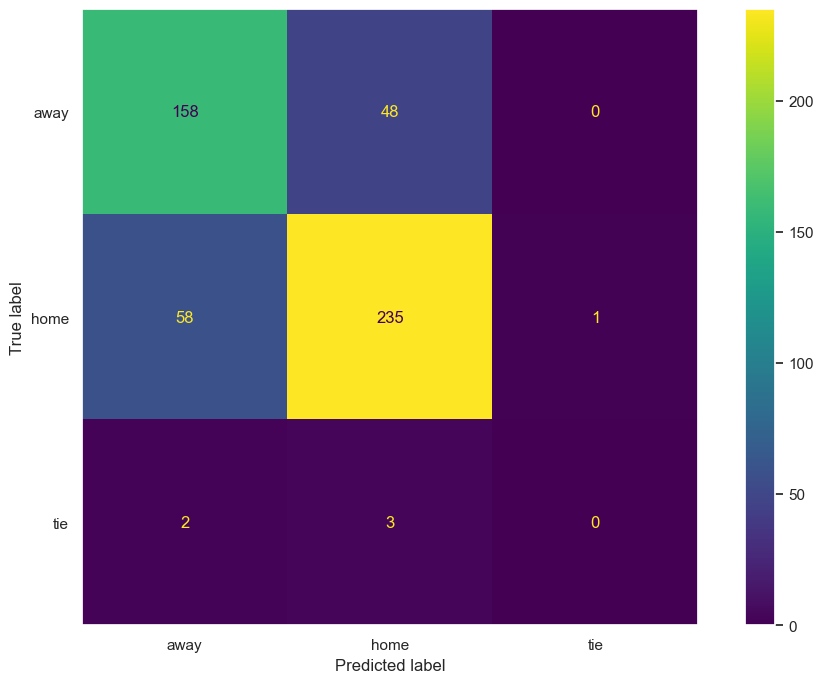

In [85]:
# Creating a confusion matrix between the true outcomes and predictions
cm = confusion_matrix(y_test, y_pred, labels=pipeline.classes_)

# Plotting the confusion matrix
cm_plot = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
cm_plot.plot()
plt.grid(False)
plt.show()

As seen by our first confusion matrix, our model predicted 158 away wins and 235 home wins correctly, giving us a total of 393 correct predictions out of 505 games. Not too shabby!

Whilst the model did pretty well at predicting wins, it missed the mark of predicting ties accurately, since the 5 true ties that were found in our data were predicted as either home or away wins. The silver lining of this is that the model pretty much split these false predictions right in half.

Now, what about metrics such as precision and recall scores for our model? Let's check these out:

In [86]:
# Precision score
p_score = precision_score(y_test, y_pred, labels=pipeline.classes_, average='weighted')
p_score

0.774012235380207

In [87]:
# Recall score
r_score = recall_score(y_test, y_pred, labels=pipeline.classes_, average='weighted')
r_score

0.7782178217821782

Looks like all these other model scores are very close to our accuracy score, which seems to be a good sign!

Finally, let's plot the decision tree to see how the model came on to make these predictions:

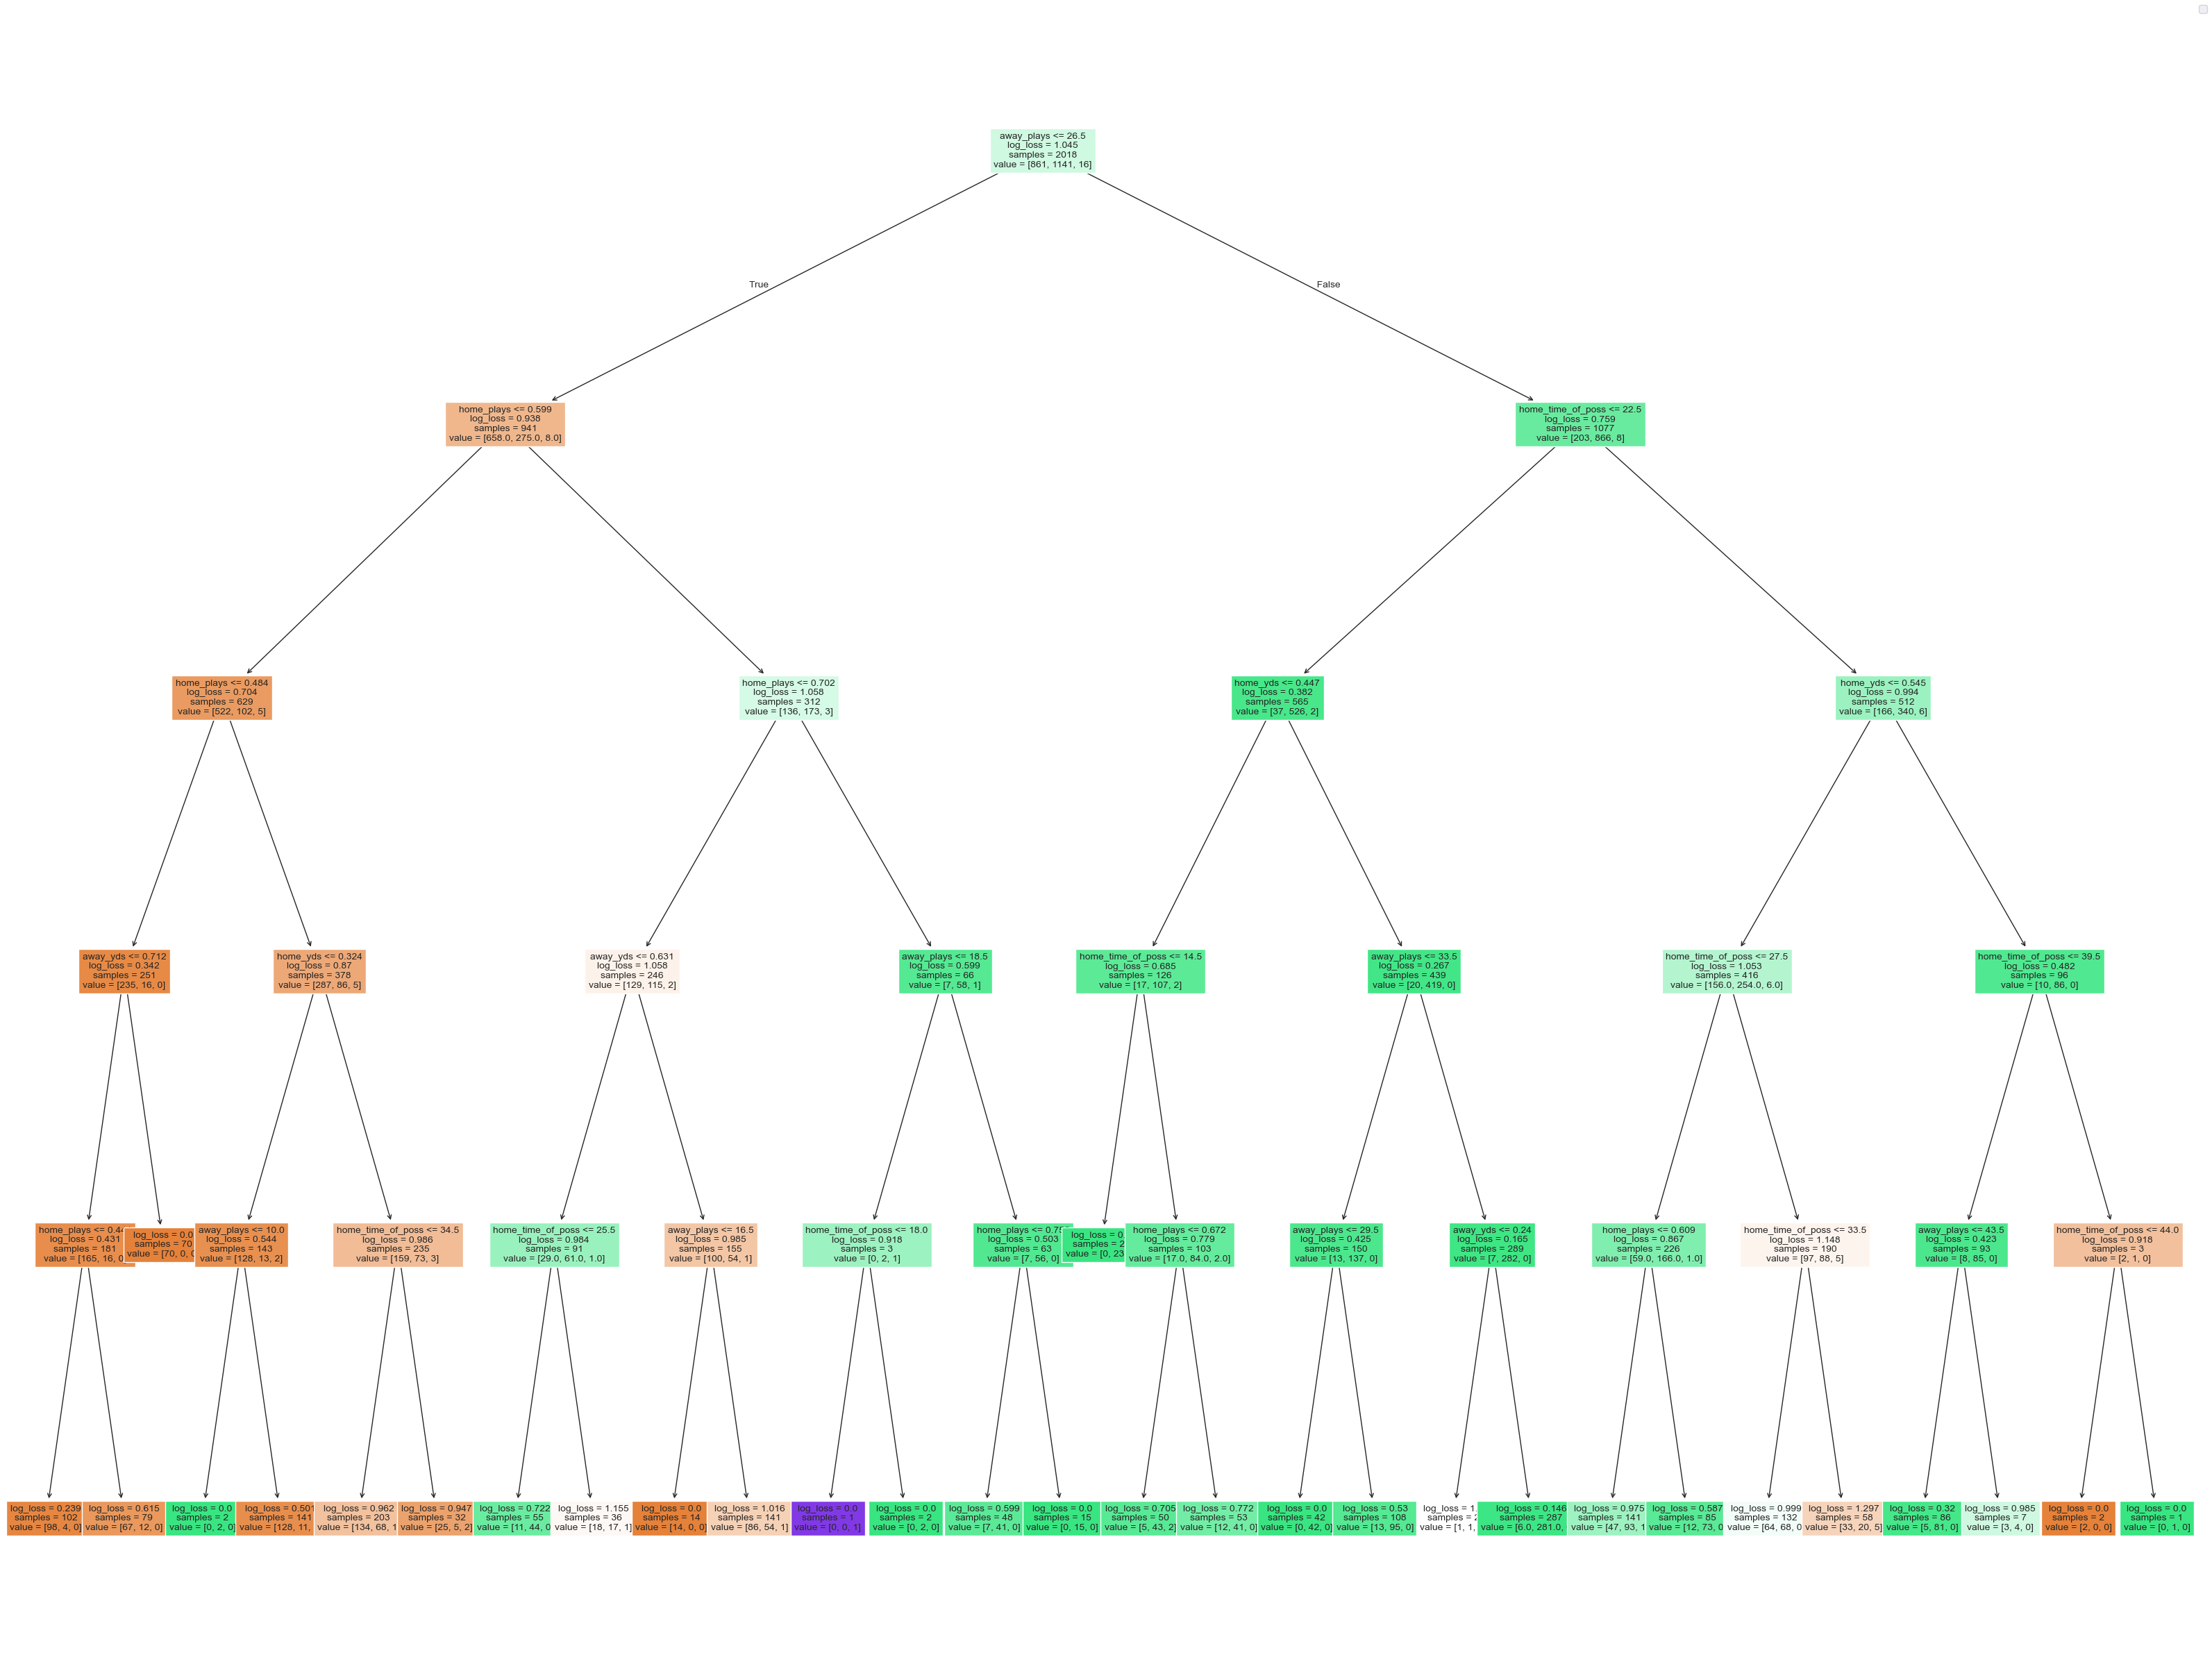

In [88]:
# Creating a decision tree plot
fig = plt.figure(figsize=(32,24))

plot_tree(pipeline['tree'], feature_names=x_train.columns, fontsize=10, filled=True)
fig.tight_layout()
fig.legend()
fig.show()

To understand this decision tree better, the fill colours represent the strength or magnitude of more predictions of a certain label (orange for away wins, green for home wins, and purple for ties). It is worth mentioning that decision trees can be set with a minimum number of samples that each node should predict accurately for one label, which would make the nodes re-work their decision criteria to split the observations differently. In this first instance, the decision tree is set with its default parameter of at least 2 minimum sample predictions per node.

We'll explore this capability later on.

We can see that, at 5 maximum decision levels, the model took the number of plays, amount of yards, and time of possession features as the main predictors for each result.

We'll see if this changes later down the line for other model parameters.

Now, what if, instead of having a lot of columns that include things like average yards per play or average plays per drive, as well as the amount of different scoring ways (touchdowns, field goals, etc) were summarised in our modelling data? Would this affect the predicting capabilities of the model?

Let's put it to the test! First, let's create some new columns, like passing completion %, field goal efficiency, 3rd and 4th down efficiency, among a few others, and see if this affects the way how our model predicts results:

In [89]:
# Creating a list of columns to drop from the model data
model_cols_to_drop = [
    'home_yds_per_play', 'away_yds_per_play', 'home_plays_per_drive', 'away_plays_per_drive',\
    'home_yds_per_rush', 'away_yds_per_rush', 'home_yds_per_pass', 'away_yds_per_pass',\
    'home_rush_tds', 'away_rush_tds', 'home_pass_tds', 'away_pass_tds', 'home_dst_tds', 'away_dst_tds',\
    'home_pass_comp', 'away_pass_comp', 'home_pass_att', 'away_pass_att', 'home_fg_made', 'away_fg_made',\
    'home_fg_att', 'away_fg_att', 'home_xp_made', 'away_xp_made', 'home_xp_att', 'away_xp_att',\
    'home_2pt_made', 'away_2pt_made', 'home_2pt_att', 'away_2pt_att', 'home_fumbles', 'away_fumbles',\
    'home_ints', 'away_ints', 'home_rush_1st_downs', 'away_rush_1st_downs', 'home_pass_1st_downs',\
    'away_pass_1st_downs', 'home_penalty_1st_downs', 'away_penalty_1st_downs', 'home_made_3rd_downs',\
    'away_made_3rd_downs', 'home_failed_3rd_downs', 'away_failed_3rd_downs', 'home_made_4th_downs',\
    'away_made_4th_downs', 'home_failed_4th_downs', 'away_failed_4th_downs'
]

# Re-calculating and summarising columns
df_model['home_comp_pct'] = df_model['home_pass_comp'] / df_model['home_pass_att']
df_model['away_comp_pct'] = df_model['away_pass_comp'] / df_model['away_pass_att']
df_model['home_fg_pct'] = df_model['home_fg_made'] / df_model['home_fg_att']
df_model['away_fg_pct'] = df_model['away_fg_made'] / df_model['away_fg_att']
df_model['home_xp_pct'] = df_model['home_xp_made'] / df_model['home_xp_att']
df_model['away_xp_pct'] = df_model['away_xp_made'] / df_model['away_xp_att']
df_model['home_2pt_pct'] = df_model['home_2pt_made'] / df_model['home_2pt_att']
df_model['away_2pt_pct'] = df_model['away_2pt_made'] / df_model['away_2pt_att']
df_model['home_tos'] = df_model['home_fumbles'] + df_model['home_ints']
df_model['away_tos'] = df_model['away_fumbles'] + df_model['away_ints']
df_model['home_1st_downs'] = df_model[['home_rush_1st_downs','home_pass_1st_downs', 'home_penalty_1st_downs']].sum(axis=1)
df_model['away_1st_downs'] = df_model[['away_rush_1st_downs','away_pass_1st_downs', 'away_penalty_1st_downs']].sum(axis=1)
df_model['home_3d_eff'] = df_model['home_made_3rd_downs'] / df_model['home_failed_3rd_downs']
df_model['away_3d_eff'] = df_model['away_made_3rd_downs'] / df_model['away_failed_3rd_downs']
df_model['home_4d_eff'] = df_model['home_made_4th_downs'] / df_model['home_failed_4th_downs']
df_model['away_4d_eff'] = df_model['away_made_4th_downs'] / df_model['away_failed_4th_downs']

# Creating a new dataset for a 2nd model
new_model = df_model.drop(columns=model_cols_to_drop)
new_model.head()

result  home_yds  away_yds  home_plays  away_plays  home_time_of_poss  \
0   home     357.0     320.0          70          61             2165.0   
1   home     281.0     259.0          62          55             1831.0   
2   home     501.0     188.0          85          44             2381.0   
3   away     169.0     267.0          68          62             1751.0   
4   away     307.0     302.0          63          52             2005.0   

   away_time_of_poss  home_drives  away_drives  home_rush_ratio  \
0             1693.0           13           12         0.328571   
1             1747.0           11           11         0.387097   
2             1211.0           11           11         0.482353   
3             1897.0           15           14         0.426471   
4             1593.0           11           11         0.428571   

   away_rush_ratio  home_pass_ratio  away_pass_ratio  home_rush_plays  \
0         0.409836         0.671429         0.590164             23.0   
1         0.400000         0.612903         0.600000             27.0   
2         0.386364         0.517647         0.613636             41.0   
3         0.500000         0.573529         0.500000             30.0   
4         0.384615         0.571429         0.615385             27.0   

   away_rush_plays  home_rush_yds  away_rush_yds  home_pass_plays  \
0             25.0           36.0           86.0             47.0   
1             22.0           72.0           96.0             38.0   
2             17.0          198.0           29.0             44.0   
3             32.0           87.0          186.0             39.0   
4             20.0           86.0           75.0             36.0   

   away_pass_plays  home_pass_yds  away_pass_yds  home_sacks  away_sacks  \
0             36.0          321.0          234.0         1.0         4.0   
1             34.0          213.0          163.0         4.0         2.0   
2             27.0          303.0          159.0         3.0         1.0   
3             31.0           83.0           82.0         2.0         5.0   
4             32.0          221.0          227.0         3.0         3.0   

   home_sack_yds  away_sack_yds  home_total_tds  away_total_tds  home_punts  \
0           10.0           42.0             1.0             1.0         7.0   
1           13.0           16.0             2.0             1.0         4.0   
2           18.0            4.0             6.0             2.0         3.0   
3           20.0           55.0             3.0             3.0         4.0   
4           16.0           26.0             1.0             1.0         7.0   

   away_punts  home_comp_pct  away_comp_pct  home_fg_pct  away_fg_pct  \
0         5.0       0.767442       0.628571          1.0     0.333333   
1         5.0       0.611111       0.700000          0.5          NaN   
2         5.0       0.604651       0.666667          0.5     1.000000   
3         4.0       0.411765       0.586207          1.0     0.500000   
4         8.0       0.636364       0.586207          NaN     1.000000   

   home_xp_pct  away_xp_pct  home_2pt_pct  away_2pt_pct  home_tos  away_tos  \
0          1.0          1.0           NaN           NaN       3.0       2.0   
1          0.5          1.0           NaN           NaN       0.0       4.0   
2          1.0          1.0           NaN           NaN       1.0       0.0   
3          1.0          1.0           NaN           NaN       7.0       2.0   
4          1.0          NaN           NaN           0.0       2.0       0.0   

   home_1st_downs  away_1st_downs  home_3d_eff  away_3d_eff  home_4d_eff  \
0            19.0            18.0     0.400000     0.444444          NaN   
1            19.0            16.0     0.666667     0.571429          NaN   
2            32.0            11.0     1.428571     0.250000          inf   
3            14.0            17.0     0.230769     0.625000          2.0   
4            16.0            10.0     0.500000     0.333333         

Now, one thing to bear in mind about these new columns is that some of them are generated from dividing a pair of columns. Sometimes, these divisions can return null values (because of 0/0 divisions) or infinity values (because of constant/0 divisions). Therefore, these values need to be cleaned up and replaced before training the new model:

In [90]:
# Checking the amount of null values for every column in the new model
new_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2523 entries, 0 to 2522
Data columns (total 45 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   result             2523 non-null   object 
 1   home_yds           2523 non-null   float64
 2   away_yds           2523 non-null   float64
 3   home_plays         2523 non-null   int64  
 4   away_plays         2523 non-null   int64  
 5   home_time_of_poss  2523 non-null   float64
 6   away_time_of_poss  2523 non-null   float64
 7   home_drives        2523 non-null   int64  
 8   away_drives        2523 non-null   int64  
 9   home_rush_ratio    2523 non-null   float64
 10  away_rush_ratio    2523 non-null   float64
 11  home_pass_ratio    2523 non-null   float64
 12  away_pass_ratio    2523 non-null   float64
 13  home_rush_plays    2523 non-null   float64
 14  away_rush_plays    2523 non-null   float64
 15  home_rush_yds      2523 non-null   float64
 16  away_rush_yds      2523 

In [91]:
# Replacing null and infinity values for 0 and 1
new_model.replace(np.nan, 0, inplace=True)
new_model.replace(np.inf, 1, inplace=True)
new_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2523 entries, 0 to 2522
Data columns (total 45 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   result             2523 non-null   object 
 1   home_yds           2523 non-null   float64
 2   away_yds           2523 non-null   float64
 3   home_plays         2523 non-null   int64  
 4   away_plays         2523 non-null   int64  
 5   home_time_of_poss  2523 non-null   float64
 6   away_time_of_poss  2523 non-null   float64
 7   home_drives        2523 non-null   int64  
 8   away_drives        2523 non-null   int64  
 9   home_rush_ratio    2523 non-null   float64
 10  away_rush_ratio    2523 non-null   float64
 11  home_pass_ratio    2523 non-null   float64
 12  away_pass_ratio    2523 non-null   float64
 13  home_rush_plays    2523 non-null   float64
 14  away_rush_plays    2523 non-null   float64
 15  home_rush_yds      2523 non-null   float64
 16  away_rush_yds      2523 

After these replacements, it's time to re-train a new model!

We'll create a new set of training and testing splits for this new model, and train a model with the same parameters as the first one:

In [92]:
# Creating the new set of features and target
x2 = new_model.drop(columns=['result'])
y2 = new_model['result']

# Splitting the new data in training and testing sets
x2_train, x2_test, y2_train, y2_test = train_test_split(x2, y2, test_size=0.2, random_state=36)

# Checking the size of all splits
print(x2_train.shape)
print(x2_test.shape)
print(y2_train.shape)
print(y2_test.shape)

(2018, 44)
(505, 44)
(2018,)
(505,)


As we can see, we have the same number of observations for the new data, with the difference that we've reduced the number of features from 76 to 44 - almost half of the features!

Now, let's repeat the model building process, predict the new outcomes, and compare against the first model:

In [93]:
# Creating a new pipeline instance with the same parameters
pipeline2 = Pipeline(steps=steps)
pipeline2.fit(x2_train, y2_train)

Pipeline(steps=[('kbest', SelectKBest(k=5)),
                ('tree',
                 DecisionTreeClassifier(criterion='log_loss', max_depth=5))])

In [94]:
# Predicting outcomes with the new model and comparing accuracy scores
y2_pred = pipeline2.predict(x2_test)
pipeline2.score(x2_test, y=y2_test)

0.7801980198019802

Extremely minimal improvement with these new set of features. The model is still producing a 78% accuracy against the test set. Let's check the confusion matrix for this to see if there's any difference in the number of predictions:

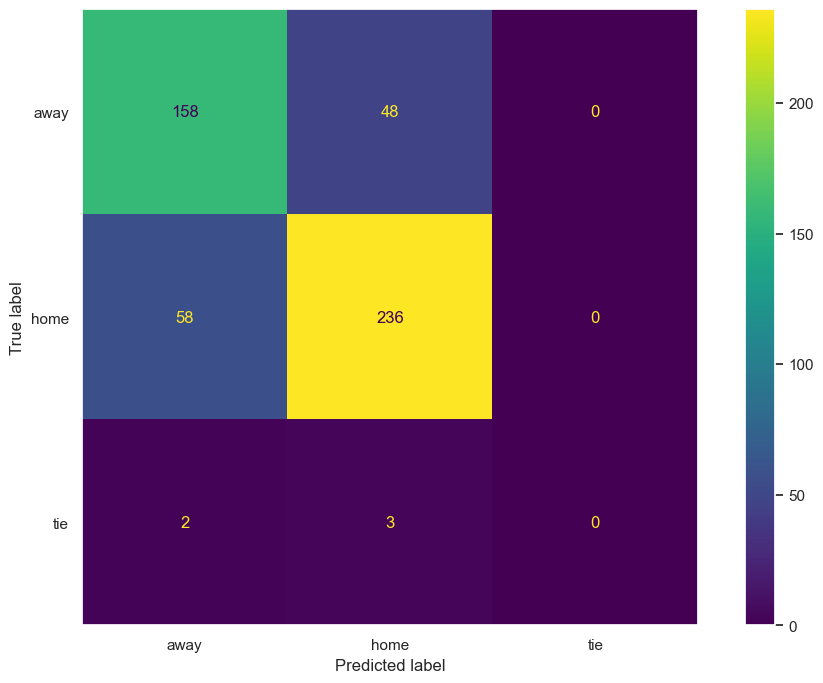

In [95]:
# Creating a confusion matrix between the true outcomes and predictions
cm2 = confusion_matrix(y2_test, y2_pred, labels=pipeline2.classes_)

# Plotting the confusion matrix
cm2_plot = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=pipeline2.classes_)
cm2_plot.plot()
plt.grid(False)
plt.show()

Pretty much the same! The only difference is by 1 more correct prediction of a home win from this new model, which the previous model predicted as a tie instead.

Now, can we potentially get any improvement from this model by performing some hyperparameter tuning and finding the best parameters for this model?

Let's try that out! We'll do this with the help of the **GridSearchCV** function, which iterates a model through a given set of parameters, as well as performing cross-validation with the model data.

The list of parameters that I'll iterate for this will be the SelectKBest's *k* parameter to select the number of best features, from 3 to 15, as well as the tree's criterion, maximum depth, and minimum sample split, as mentioned before.

Let's see how this plays out!

In [96]:
# Setting the parameters grid to iterate through and select the best setting
param_grid={
    'kbest__k': list(range(3,16)), # From 3 to 15 best features
    'tree__criterion': ['gini','entropy','log_loss'], # All possible criterion
    'tree__max_depth': list(range(3,16)), # From 3 to 15 decision levels
    'tree__min_samples_split': list(range(2,11)) # From 2 to 10 minimum samples per split
}

# Initialising the GridSearchCV object for the pipeline, parameter grid, and 10-fold cross-validation
# Select the best estimator based on accuracy
grid = GridSearchCV(estimator=pipeline2,
                    param_grid=param_grid,
                    cv=10,
                    scoring='accuracy',
                    n_jobs=-1,
                    verbose=1)

# Fitting the model with the full dataset to perform the folds
grid.fit(x2, y2)

Fitting 10 folds for each of 4563 candidates, totalling 45630 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('kbest', SelectKBest(k=5)),
                                       ('tree',
                                        DecisionTreeClassifier(criterion='log_loss',
                                                               max_depth=5))]),
             param_grid={'kbest__k': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,
                                      15],
                         'tree__criterion': ['gini', 'entropy', 'log_loss'],
                         'tree__max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                             13, 14, 15],
                         'tree__min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9,
                                                     10]},
             scoring='accuracy', verbose=1)

Based on the provided parameter grid, the GridSearchCV object returned a model whose best parameters are a 14-best feature selector and a 7-level, 6-minimum-sample Decision Tree Classifier.

We can check the whole table of scores for each iteration of the grid search with the *cv_results_* attribute of the object:

In [97]:
# Obtaining the full table of results for each grid search iteration and passing it to a DataFrame
results = grid.cv_results_
df_results = pd.DataFrame(results).drop('params', axis=1)
df_results

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0          0.020990      0.001636         0.005067        0.000844   
1          0.020268      0.001723         0.004204        0.000751   
2          0.020666      0.000946         0.004700        0.000639   
3          0.020367      0.001252         0.004855        0.000830   
4          0.019093      0.000820         0.004340        0.000448   
...             ...           ...              ...             ...   
4558       0.072204      0.003596         0.006148        0.001484   
4559       0.068002      0.005108         0.005691        0.001351   
4560       0.066814      0.004550         0.005209        0.000735   
4561       0.069122      0.005122         0.005235        0.000601   
4562       0.066095      0.005803         0.004998        0.000881   

      param_kbest__k param_tree__criterion  param_tree__max_depth  \
0                  3                  gini                      3   
1                  3                  gini                      3   
2                  3                  gini                      3   
3                  3                  gini                      3   
4                  3                  gini                      3   
...              ...                   ...                    ...   
4558              15              log_loss                     15   
4559              15              log_loss                     15   
4560              15              log_loss                     15   
4561              15              log_loss                     15   
4562              15              log_loss                     15   

      param_tree__min_samples_split  split0_test_score  split1_test_score  \
0                                 2           0.727273           0.802372   
1                                 3           0.727273           0.802372   
2                                 4           0.727273           0.802372   
3                                 5           0.727273           0.802372   
4                                 6           0.727273           0.802372   
...                             ...                ...                ...   
4558                              6           0.723320           0.794466   
4559                              7           0.731225           0.782609   
4560                              8           0.711462           0.798419   
4561                              9           0.727273           0.806324   
4562                             10           0.731225           0.794466   

      split2_test_score  split3_test_score  split4_test_score  \
0              0.750988           0.761905           0.781746   
1              0.750988           0.761905           0.781746   
2              0.750988           0.761905           0.781746   
3              0.750988           0.761905           0.781746   
4              0.750988           0.761905           0.781746   
...                 ...                ...                ...   
4558           0.711462           0.785714           0.781746   
4559           0.719368           0.793651           0.765873   
4560           0.723320           0.777778           0.773810   
4561           0.739130           0.761905           0.765873   
4562           0.743083           0.757937           0.773810   

      split5_test_score  split6_test_score  split7_test_score  \
0              0.789683           0.789683           0.777778   
1              0.789683           0.789683           0.777778   
2              0.789683           0.789683           0.777778   
3              0.789683           0.789683           0.777778   
4              0.789683           0.789683           0.777778   
...                 ...                ...                ...   
4558           0.746032           0.761905           0.765873   
4559           0.746032           0.789683           0.757937   
4560           0.753968           0.789683   

The grid search computed 45,630 iterations - 4,563 different sets of parameters for each of the 10 different fold splits for the data.

This table also provides details for the accuracy score of each of the 10 splits, as well as the mean and standard deviation across the 10 folds for each set of parameters. We can plot a distribution of all mean accuracy scores to see a deeper detail of the range of scores we got:

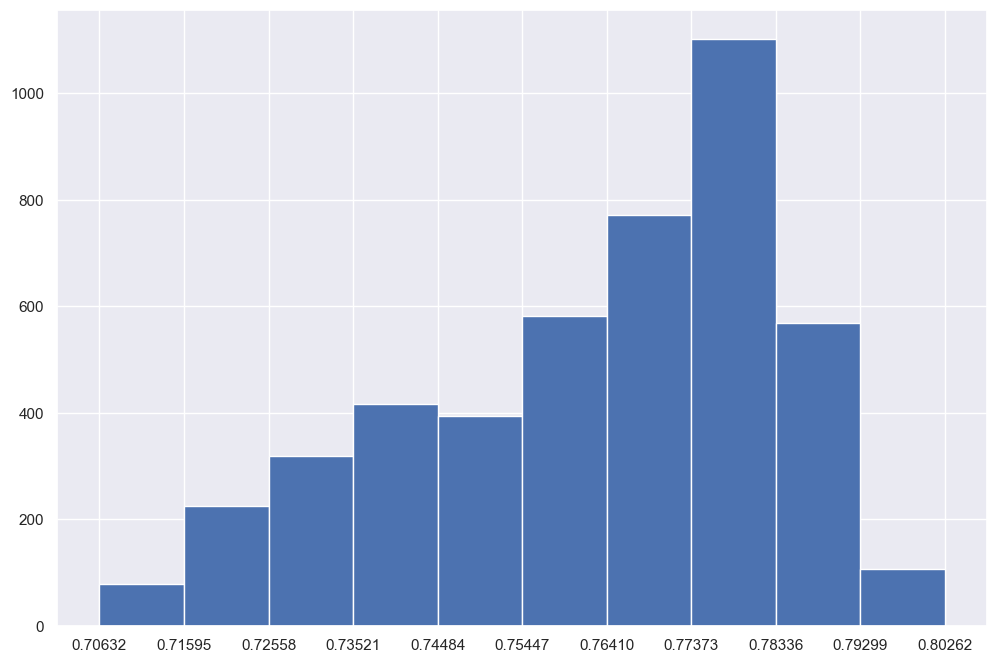

In [98]:
hist, bins = np.histogram(df_results['mean_test_score'], bins=10)

df_results['mean_test_score'].hist(bins=10)
plt.xticks(bins)
plt.show()

We can see that most iterations had an accuracy score of 78%, which was the same score we got on our first two models with random parameters.

Less than 100 iterations (out of 4,563) were able to achieve an 80% accuracy score, indicating that there's little room for model improvement when it comes to hyperparameter tuning. Perhaps other data models would allow for a better accuracy; however, 80% accuracy is still very good for what we're expecting to see!

Now, we can also get the best estimator out of this grid search, and make predictions using the parameters of this model on our test set:

In [99]:
# Saving the best estimator in a standalone variable
best_model = grid.best_estimator_

# Predicting outcomes with the best estimator on the test set
y3_pred = best_model.predict(x2_test)
best_model.score(x2_test, y=y2_test)

0.8653465346534653

Now, our model achieved 86% accuracy on our test set!

Let's check this on a confusion matrix to see how all the predictions plotted out:

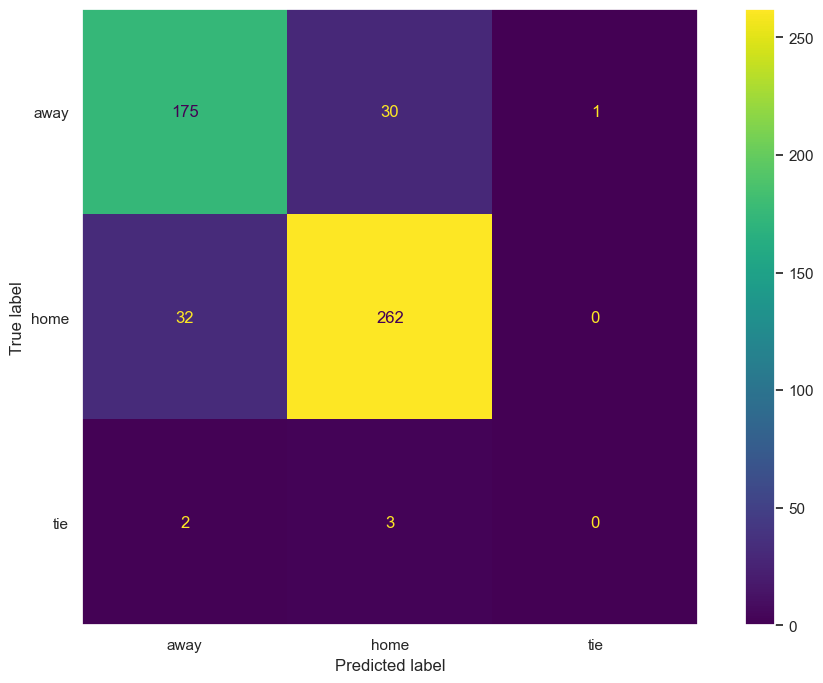

In [100]:
# Creating a confusion matrix between the true outcomes and predictions
cm3 = confusion_matrix(y2_test, y3_pred, labels=grid.classes_)

# Plotting the confusion matrix
cm3_plot = ConfusionMatrixDisplay(confusion_matrix=cm3, display_labels=grid.classes_)
cm3_plot.plot()
plt.grid(False)
plt.show()

This time, a total of 437 out of 505 outcomes were accurately predicted, with 175 away wins and 262 home wins. The tie mispredictions stayed pretty much the same throughout this exercise.

Now, let's check the model's accuracy against the whole data to see how it fared up:

In [102]:
y_all = best_model.predict(x2)
best_model.score(x2, y=y2)

0.8747522790328973

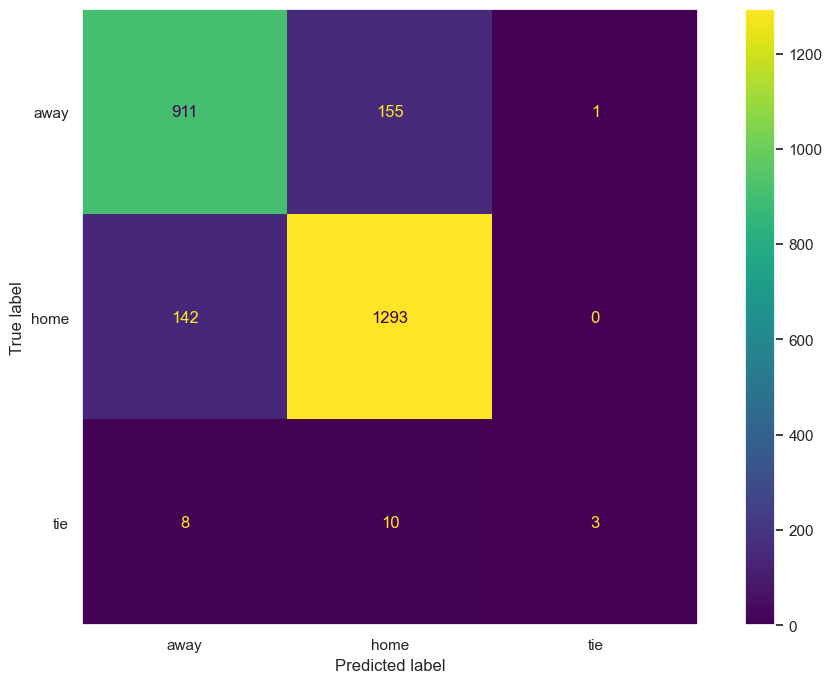

In [103]:
cm4 = confusion_matrix(y2, y_all, labels=grid.classes_)
ConfusionMatrixDisplay(cm4, display_labels=grid.classes_).plot()
plt.grid(False)
plt.show()

More than 2,200 out of 2,523 predictions were correct, giving us an 87% accuracy on the whole dataset!

Even a few ties were accurately predicted by the model, although it performed quite poorly with this label (3 out of 21).

Let's check the precision and recall scores for this model:

In [104]:
# Precision score
p_best_model = precision_score(y2, y_all, labels=grid.classes_, average='weighted')
p_best_model

0.873763228020814

In [105]:
# Recall score
r_best_model = recall_score(y2, y_all, labels=grid.classes_, average='weighted')
r_best_model

0.8747522790328973

Pretty good and consistent overall!

So, now that we have or model trained, tested, and evaluated with the model data, let's now attempt to predict outcomes for data that the model has not seen at all. This data will be game stats for games played after the 2018 season, more specifically, from 2019 to 2023!

## 8. Predicting new games with our predictive model

Now that we have our model assembled, it's time to predict game outcomes for data we've not yet touched.

For this, we'll download another Kaggle dataset that contains team stats for all 2019-to-2023 game, transform this dataset into a digestible format for our model, and predict the results based on the stats we have.

The dataset we'll use is the **"NFL Team Stats 2002-2019 ESPN"** dataset, uploaded by *cviaxmiwnptr*, so credits to them for this data!

First, we'll create a separate Kaggle API instance to search, download, and import this dataset as another DataFrame, just like we did in Section 1:

In [106]:
# Creating a new Kaggle API instance and searching for the dataset
kaggle2 = KaggleApi()
kaggle2.authenticate()
kaggle2.dataset_list(search='NFL ESPN')

[tobycrabtree/nfl-scores-and-betting-data,
 cviaxmiwnptr/nfl-team-stats-20022019-espn,
 jacklichtenstein/espn-nfl-draft-prospect-data,
 speckledpingu/nfl-qb-stats,
 mur418/espn-2019-stats-and-2020-nfl-fantasy-projections,
 rahul253801/political-donations-by-american-sports-owners,
 jpmiller/nfl-competition-data,
 georgedurrant/nfl-qb-shoulder-injuries,
 fishhead/fantasy-football]

In [107]:
# Downloading and unzipping the desired dataset
kaggle2.dataset_download_cli(dataset='cviaxmiwnptr/nfl-team-stats-20022019-espn', unzip=True, force=True)

Dataset URL: https://www.kaggle.com/datasets/cviaxmiwnptr/nfl-team-stats-20022019-espn
License(s): CC0-1.0


100%|██████████| 375k/375k [00:00<00:00, 948kB/s]

In [108]:
# Loading the CSV file path as a new DataFrame
new_csv = "nfl_team_stats_2002-2023.csv"
df_new = pd.read_csv(new_csv)
df_new.head()

season week        date  time_et  neutral       away        home  \
0    2002    1  2002-09-05  8:30 PM    False      49ers      Giants   
1    2002    1  2002-09-08  1:00 PM    False      Colts     Jaguars   
2    2002    1  2002-09-08  1:00 PM    False  Cardinals  Commanders   
3    2002    1  2002-09-08  1:00 PM    False      Lions    Dolphins   
4    2002    1  2002-09-08  1:00 PM    False     Eagles      Titans   

   score_away  score_home  first_downs_away  first_downs_home  \
0          16          13                13                21   
1          28          25                18                19   
2          23          31                14                21   
3          21          49                15                27   
4          24          27                17                22   

   first_downs_from_passing_away  first_downs_from_passing_home  \
0                              7                             17   
1                             13                             11   
2                              9                             13   
3                             10                             15   
4                             11                             15   

   first_downs_from_rushing_away  first_downs_from_rushing_home  \
0                              5                              2   
1                              5                              8   
2                              5                              8   
3                              4                             11   
4                              5                              3   

   first_downs_from_penalty_away  first_downs_from_penalty_home  \
0                              1                              2   
1                              0                              0   
2                              0                              0   
3                              1                              1   
4                              1                              4   

   third_down_comp_away  third_down_att_away  third_down_comp_home  \
0                     4                   12                     9   
1                     9                   14                     8   
2                     4                   13                     9   
3                     7                   14                     6   
4                     7                   15                     6   

   third_down_att_home  fourth_down_comp_away  fourth_down_att_away  \
0                   16                      0                     0   
1                   16                      0                     0   
2                   16                      0                     0   
3                   12                      0                     1   
4                   10                      1                     1   

   fourth_down_comp_home  fourth_down_att_home  plays_away  plays_home  \
0                      0                     1          51          70   
1                      3                     3          60          69   
2                      1                     2          57          73   
3                      1                     1          58          68   
4                      0                     0          64          60   

   drives_away  drives_home  yards_away  yards_home  pass_comp_away  \
0           13           15         279         361              16   
1           17           16         307         343              19   
2           18           18         257         442              14   
3           18           16         257         389              17   
4           17           16         261         328              18   

   pass_att_away  pass_yards_away  pass_comp_home  pass_att_home  \
0             26              166              28             45   
1             31              203              22             36   
2             36              187              28   

Funnily enough, this dataset also contains team stats for games between 2009 and 2018, which is the data we used to train our model. It also has team stats for games before 2009 (up until 2002), and after 2018, which is the data we'll attempt to predict outcomes for.

First, let's check the column details and types:

In [109]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5929 entries, 0 to 5928
Data columns (total 61 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   season                         5929 non-null   int64 
 1   week                           5929 non-null   object
 2   date                           5929 non-null   object
 3   time_et                        5929 non-null   object
 4   neutral                        5929 non-null   bool  
 5   away                           5929 non-null   object
 6   home                           5929 non-null   object
 7   score_away                     5929 non-null   int64 
 8   score_home                     5929 non-null   int64 
 9   first_downs_away               5929 non-null   int64 
 10  first_downs_home               5929 non-null   int64 
 11  first_downs_from_passing_away  5929 non-null   int64 
 12  first_downs_from_passing_home  5929 non-null   int64 
 13  fir

Thankfully, no null values in any of the columns, which is a big help!

However, some of the columns are differently labelled, as well as new columns our model has not seen, and columns that are in our model that are not included in this new data. So we'll have to prepare our data to the best shape possible to put it against our model.

First, let's only focus on games played from the 2019 season onwards:

In [110]:
# Subsetting the data for games after the 2018 season
df_new = df_new[df_new['season'] >= 2019].reset_index(drop=True)
df_new.head()

season week        date  time_et  neutral     away      home  score_away  \
0    2019    1  2019-09-05  8:20 PM    False  Packers     Bears          10   
1    2019    1  2019-09-08  1:00 PM    False   Titans    Browns          43   
2    2019    1  2019-09-08  1:00 PM    False   Ravens  Dolphins          59   
3    2019    1  2019-09-08  1:00 PM    False  Falcons   Vikings          12   
4    2019    1  2019-09-08  1:00 PM    False    Bills      Jets          17   

   score_home  first_downs_away  first_downs_home  \
0           3                13                16   
1          13                21                19   
2          10                31                12   
3          28                27                18   
4          16                23                17   

   first_downs_from_passing_away  first_downs_from_passing_home  \
0                             10                             10   
1                              9                             13   
2                             17                             10   
3                             16                              4   
4                             11                             12   

   first_downs_from_rushing_away  first_downs_from_rushing_home  \
0                              1                              3   
1                              6                              4   
2                             10                              1   
3                              5                             10   
4                              8                              3   

   first_downs_from_penalty_away  first_downs_from_penalty_home  \
0                              2                              3   
1                              6                              2   
2                              4                              1   
3                              6                              4   
4                              4                              2   

   third_down_comp_away  third_down_att_away  third_down_comp_home  \
0                     2                   12                     3   
1                     2                   10                     1   
2                     7                   11                     3   
3                     2                    8                     5   
4                     5                   10                     7   

   third_down_att_home  fourth_down_comp_away  fourth_down_att_away  \
0                   15                      0                     0   
1                   10                      0                     0   
2                   10                      2                     2   
3                   10                      2                     2   
4                   17                      0                     1   

   fourth_down_comp_home  fourth_down_att_home  plays_away  plays_home  \
0                      0                     2          57          65   
1                      0                     2          56          63   
2                      0                     0          73          47   
3                      0                     0          67          49   
4                      1                     2          63          66   

   drives_away  drives_home  yards_away  yards_home  pass_comp_away  \
0           13           12         213         254              18   
1           13           14         339         346              14   
2           12           10         643         200              23   
3           10           10         345         269              33   
4           12           11         370         223              24   

   pass_att_away  pass_yards_away  pass_comp_home  pass_att_home  \
0             30              166              26             45   
1             24              216              25             38   
2             26              378              15             32   
3       

Since our model does not predict the game outcomes using the number of penalties and penalty yards per team, or the redzone efficiency, we'll drop these columns off the data, as well as information about the week, time, and venue neutrality:

In [111]:
# Selecting the columns that will be dropped out of the data
cols_to_drop = [
    'week',
    'time_et',
    'neutral',
    'pen_num_away',
    'pen_yards_away',
    'pen_num_home',
    'pen_yards_home',
    'redzone_comp_away',
    'redzone_comp_home',
    'redzone_att_away',
    'redzone_att_home',
]

df_new.drop(columns=cols_to_drop, inplace=True)
df_new.shape

(1390, 50)

So far, our data of interest contains 50 features, although with different names that we'll have to change later.

Another aspect of this data that we need to transform is the team names. This dataset has all teams named after their actual team name (e.g., Eagles) rather than the team abbreviation (e.g., PHI), as we saw from our first dataset in previous sections. Therefore, in order to maintain consistency with the nomenclature, we'll replace the team names with their respective abbreviations.

First, we'll create a list of all team abbreviations, sorted by the alphabetical order of all team names. This will then be zipped and converted to a dictionary, where the team names are the keys and the abbreviations are the values:

In [112]:
# Creating the list of team abbreviations
team_abbvs = ['SF','CHI','CIN','BUF','DEN','CLE','TB','ARI','LAC','KC','IND',\
              'WAS','DAL','MIA','PHI','ATL','NYG','JAX','NYJ','DET','GB','CAR',\
              'NE','LV','LAR','BAL','NO','SEA','PIT','HOU','TEN','MIN']

# Extracting the list of team names
team_names = df_new['home'].sort_values().unique().tolist()

# Wrapping all key-value pairs in a dictionary
dict_teams = dict(zip(team_names, team_abbvs))
dict_teams

{'49ers': 'SF',
 'Bears': 'CHI',
 'Bengals': 'CIN',
 'Bills': 'BUF',
 'Broncos': 'DEN',
 'Browns': 'CLE',
 'Buccaneers': 'TB',
 'Cardinals': 'ARI',
 'Chargers': 'LAC',
 'Chiefs': 'KC',
 'Colts': 'IND',
 'Commanders': 'WAS',
 'Cowboys': 'DAL',
 'Dolphins': 'MIA',
 'Eagles': 'PHI',
 'Falcons': 'ATL',
 'Giants': 'NYG',
 'Jaguars': 'JAX',
 'Jets': 'NYJ',
 'Lions': 'DET',
 'Packers': 'GB',
 'Panthers': 'CAR',
 'Patriots': 'NE',
 'Raiders': 'LV',
 'Rams': 'LAR',
 'Ravens': 'BAL',
 'Saints': 'NO',
 'Seahawks': 'SEA',
 'Steelers': 'PIT',
 'Texans': 'HOU',
 'Titans': 'TEN',
 'Vikings': 'MIN'}

Now, by using this dictionary, we'll replace every team name with its respective abbreviation:

In [113]:
# Looping through the dictionary and replacing all names with abbreviations
for k, v in dict_teams.items():
    df_new['away'].replace(k, v, inplace=True)
    df_new['home'].replace(k, v, inplace=True)

# Checking the transformed dataset
df_new.head()

season        date away home  score_away  score_home  first_downs_away  \
0    2019  2019-09-05   GB  CHI          10           3                13   
1    2019  2019-09-08  TEN  CLE          43          13                21   
2    2019  2019-09-08  BAL  MIA          59          10                31   
3    2019  2019-09-08  ATL  MIN          12          28                27   
4    2019  2019-09-08  BUF  NYJ          17          16                23   

   first_downs_home  first_downs_from_passing_away  \
0                16                             10   
1                19                              9   
2                12                             17   
3                18                             16   
4                17                             11   

   first_downs_from_passing_home  first_downs_from_rushing_away  \
0                             10                              1   
1                             13                              6   
2                             10                             10   
3                              4                              5   
4                             12                              8   

   first_downs_from_rushing_home  first_downs_from_penalty_away  \
0                              3                              2   
1                              4                              6   
2                              1                              4   
3                             10                              6   
4                              3                              4   

   first_downs_from_penalty_home  third_down_comp_away  third_down_att_away  \
0                              3                     2                   12   
1                              2                     2                   10   
2                              1                     7                   11   
3                              4                     2                    8   
4                              2                     5                   10   

   third_down_comp_home  third_down_att_home  fourth_down_comp_away  \
0                     3                   15                      0   
1                     1                   10                      0   
2                     3                   10                      2   
3                     5                   10                      2   
4                     7                   17                      0   

   fourth_down_att_away  fourth_down_comp_home  fourth_down_att_home  \
0                     0                      0                     2   
1                     0                      0                     2   
2                     2                      0                     0   
3                     2                      0                     0   
4                     1                      1                     2   

   plays_away  plays_home  drives_away  drives_home  yards_away  yards_home  \
0          57          65           13           12         213         254   
1          56          63           13           14         339         346   
2          73          47           12           10         643         200   
3          67          49           10           10         345         269   
4          63          66           12           11         370         223   

   pass_comp_away  pass_att_away  pass_yards_away  pass_comp_home  \
0              18             30              166              26   
1              14             24              216              25   
2              23             26              378              15   
3              33             46              272               8   
4              24             37              242              28   

   pass_att_home  pass_yards_home  sacks_num_away  sacks_yards_away  \
0             45              208               5                37   
1             38              244         

Excellent! Now all team abbreviations are assigned within the dataset!

Next, we need to replace the column names from the new data in the same way as the model data that we used to train our classifier.

To do this, we'll check the column names of both datasets, create a list of names to replace, and then replace the columns in the desired format:

In [114]:
# Checking the new data column names
df_new.columns

Index(['season', 'date', 'away', 'home', 'score_away', 'score_home',
       'first_downs_away', 'first_downs_home', 'first_downs_from_passing_away',
       'first_downs_from_passing_home', 'first_downs_from_rushing_away',
       'first_downs_from_rushing_home', 'first_downs_from_penalty_away',
       'first_downs_from_penalty_home', 'third_down_comp_away',
       'third_down_att_away', 'third_down_comp_home', 'third_down_att_home',
       'fourth_down_comp_away', 'fourth_down_att_away',
       'fourth_down_comp_home', 'fourth_down_att_home', 'plays_away',
       'plays_home', 'drives_away', 'drives_home', 'yards_away', 'yards_home',
       'pass_comp_away', 'pass_att_away', 'pass_yards_away', 'pass_comp_home',
       'pass_att_home', 'pass_yards_home', 'sacks_num_away',
       'sacks_yards_away', 'sacks_num_home', 'sacks_yards_home',
       'rush_att_away', 'rush_yards_away', 'rush_att_home', 'rush_yards_home',
       'fumbles_away', 'fumbles_home', 'interceptions_away',
       'interc

In [115]:
# Checking the model data column names
new_model.columns

Index(['result', 'home_yds', 'away_yds', 'home_plays', 'away_plays',
       'home_time_of_poss', 'away_time_of_poss', 'home_drives', 'away_drives',
       'home_rush_ratio', 'away_rush_ratio', 'home_pass_ratio',
       'away_pass_ratio', 'home_rush_plays', 'away_rush_plays',
       'home_rush_yds', 'away_rush_yds', 'home_pass_plays', 'away_pass_plays',
       'home_pass_yds', 'away_pass_yds', 'home_sacks', 'away_sacks',
       'home_sack_yds', 'away_sack_yds', 'home_total_tds', 'away_total_tds',
       'home_punts', 'away_punts', 'home_comp_pct', 'away_comp_pct',
       'home_fg_pct', 'away_fg_pct', 'home_xp_pct', 'away_xp_pct',
       'home_2pt_pct', 'away_2pt_pct', 'home_tos', 'away_tos',
       'home_1st_downs', 'away_1st_downs', 'home_3d_eff', 'away_3d_eff',
       'home_4d_eff', 'away_4d_eff'],
      dtype='object')

In [116]:
# Listing the columns with the desired column names to replace
replace_cols = ['season', 'date', 'away', 'home', 'away_pts', 'home_pts',
       'away_1st_downs', 'home_1st_downs', 'first_downs_from_passing_away',
       'first_downs_from_passing_home', 'first_downs_from_rushing_away',
       'first_downs_from_rushing_home', 'first_downs_from_penalty_away',
       'first_downs_from_penalty_home', 'third_down_comp_away',
       'third_down_att_away', 'third_down_comp_home', 'third_down_att_home',
       'fourth_down_comp_away', 'fourth_down_att_away',
       'fourth_down_comp_home', 'fourth_down_att_home', 'away_plays',
       'home_plays', 'away_drives', 'home_drives', 'away_yds', 'home_yds',
       'pass_comp_away', 'pass_att_away', 'away_pass_yds', 'pass_comp_home',
       'pass_att_home', 'home_pass_yds', 'away_sacks',
       'away_sack_yds', 'home_sacks', 'home_sack_yds',
       'away_rush_plays', 'away_rush_yds', 'home_rush_plays', 'home_rush_yds',
       'fumbles_away', 'fumbles_home', 'interceptions_away',
       'interceptions_home', 'def_st_td_away', 'def_st_td_home', 'away_time_of_poss', 
        'home_time_of_poss']

df_new.columns = replace_cols

In [117]:
df_new.head()

season        date away home  away_pts  home_pts  away_1st_downs  \
0    2019  2019-09-05   GB  CHI        10         3              13   
1    2019  2019-09-08  TEN  CLE        43        13              21   
2    2019  2019-09-08  BAL  MIA        59        10              31   
3    2019  2019-09-08  ATL  MIN        12        28              27   
4    2019  2019-09-08  BUF  NYJ        17        16              23   

   home_1st_downs  first_downs_from_passing_away  \
0              16                             10   
1              19                              9   
2              12                             17   
3              18                             16   
4              17                             11   

   first_downs_from_passing_home  first_downs_from_rushing_away  \
0                             10                              1   
1                             13                              6   
2                             10                             10   
3                              4                              5   
4                             12                              8   

   first_downs_from_rushing_home  first_downs_from_penalty_away  \
0                              3                              2   
1                              4                              6   
2                              1                              4   
3                             10                              6   
4                              3                              4   

   first_downs_from_penalty_home  third_down_comp_away  third_down_att_away  \
0                              3                     2                   12   
1                              2                     2                   10   
2                              1                     7                   11   
3                              4                     2                    8   
4                              2                     5                   10   

   third_down_comp_home  third_down_att_home  fourth_down_comp_away  \
0                     3                   15                      0   
1                     1                   10                      0   
2                     3                   10                      2   
3                     5                   10                      2   
4                     7                   17                      0   

   fourth_down_att_away  fourth_down_comp_home  fourth_down_att_home  \
0                     0                      0                     2   
1                     0                      0                     2   
2                     2                      0                     0   
3                     2                      0                     0   
4                     1                      1                     2   

   away_plays  home_plays  away_drives  home_drives  away_yds  home_yds  \
0          57          65           13           12       213       254   
1          56          63           13           14       339       346   
2          73          47           12           10       643       200   
3          67          49           10           10       345       269   
4          63          66           12           11       370       223   

   pass_comp_away  pass_att_away  away_pass_yds  pass_comp_home  \
0              18             30            166              26   
1              14             24            216              25   
2              23             26            378              15   
3              33             46            272               8   
4              24             37            242              28   

   pass_att_home  home_pass_yds  away_sacks  away_sack_yds  home_sacks  \
0             45            208           5             37           5   
1             38            244           4             32           5   
2             32            179           1   

In [118]:
# Calculating new columns to match the model features
df_new['away_pass_plays'] = df_new['pass_att_away'] + df_new['away_sacks']
df_new['home_pass_plays'] = df_new['pass_att_home'] + df_new['home_sacks']
df_new['away_rush_ratio'] = df_new['away_rush_plays']/df_new['away_plays']
df_new['home_rush_ratio'] = df_new['home_rush_plays']/df_new['home_plays']
df_new['away_pass_ratio'] = df_new['away_pass_plays']/df_new['away_plays']
df_new['home_pass_ratio'] = df_new['home_pass_plays']/df_new['home_plays']
df_new['away_3d_eff'] = df_new['third_down_comp_away']/df_new['third_down_att_away']
df_new['home_3d_eff'] = df_new['third_down_comp_home']/df_new['third_down_att_home']
df_new['away_4d_eff'] = df_new['fourth_down_comp_away']/df_new['fourth_down_att_away']
df_new['home_4d_eff'] = df_new['fourth_down_comp_home']/df_new['fourth_down_att_home']
df_new['away_comp_pct'] = df_new['pass_comp_away']/df_new['pass_att_away']
df_new['home_comp_pct'] = df_new['pass_comp_home']/df_new['pass_att_home']
df_new['away_tos'] = df_new['fumbles_away'] + df_new['interceptions_away']
df_new['home_tos'] = df_new['fumbles_home'] + df_new['interceptions_home']
df_new['away_time_of_poss'] = df_new['away_time_of_poss'].apply(
    lambda x: int(x[:2]) * 60 + int(x[-2:]))
df_new['home_time_of_poss'] = df_new['home_time_of_poss'].apply(
    lambda x: int(x[:2]) * 60 + int(x[-2:]))

# Listing columns to drop from the data
drop_cols = ['season', 'date', 'away', 'home', 'first_downs_from_passing_away',
       'first_downs_from_passing_home', 'first_downs_from_rushing_away',
       'first_downs_from_rushing_home', 'first_downs_from_penalty_away',
       'first_downs_from_penalty_home', 'third_down_comp_away',
       'third_down_att_away', 'third_down_comp_home', 'third_down_att_home',
       'fourth_down_comp_away', 'fourth_down_att_away',
       'fourth_down_comp_home', 'fourth_down_att_home','pass_comp_away', 'pass_att_away', 'pass_comp_home',
       'pass_att_home','fumbles_away', 'fumbles_home', 'interceptions_away',
       'interceptions_home', 'def_st_td_away', 'def_st_td_home']

df_new.drop(columns=drop_cols, inplace=True)
df_new.head()

away_pts  home_pts  away_1st_downs  home_1st_downs  away_plays  home_plays  \
0        10         3              13              16          57          65   
1        43        13              21              19          56          63   
2        59        10              31              12          73          47   
3        12        28              27              18          67          49   
4        17        16              23              17          63          66   

   away_drives  home_drives  away_yds  home_yds  away_pass_yds  home_pass_yds  \
0           13           12       213       254            166            208   
1           13           14       339       346            216            244   
2           12           10       643       200            378            179   
3           10           10       345       269            272             97   
4           12           11       370       223            242            155   

   away_sacks  away_sack_yds  home_sacks  home_sack_yds  away_rush_plays  \
0           5             37           5             20               22   
1           4             32           5             41               28   
2           1              1           3             11               46   
3           4             32           1              1               17   
4           1             12           4             20               25   

   away_rush_yds  home_rush_plays  home_rush_yds  away_time_of_poss  \
0             47               15             46               1863   
1            123               20            102               1758   
2            265               12             21               2407   
3             73               38            172               1813   
4            128               21             68               1679   

   home_time_of_poss  away_pass_plays  home_pass_plays  away_rush_ratio  \
0               1737               35               50         0.385965   
1               1842               28               43         0.500000   
2               1193               27               35         0.630137   
3               1787               50               11         0.253731   
4               1921               38               45         0.396825   

   home_rush_ratio  away_pass_ratio  home_pass_ratio  away_3d_eff  \
0         0.230769         0.614035         0.769231     0.166667   
1         0.317460         0.500000         0.682540     0.200000   
2         0.255319         0.369863         0.744681     0.636364   
3         0.775510         0.746269         0.224490     0.250000   
4         0.318182         0.603175         0.681818     0.500000   

   home_3d_eff  away_4d_eff  home_4d_eff  away_comp_pct  home_comp_pct  \
0     0.200000          NaN          0.0       0.600000       0.577778   
1     0.100000          NaN          0.0       0.583333       0.657895   
2     0.300000          1.0          NaN       0.884615       0.468750   
3     0.500000          1.0          NaN       0.717391       0.800000   
4     0.411765          0.0          0.5       0.648649       0.682927   

   away_tos  home_tos  
0         0         1  
1         0         3  
2         0         3  
3         3         0  
4         4         1

In [119]:
df_new.shape

(1390, 36)

We end up now with a DataFrame of 34 features (without including home and away points)! However, as we can recall from the previous section, we used 44 to train our model, which means we'll have to re-train the best model we derived with an adapted model dataset that doesn't include the features that are not on this new dataset.

Before anything, we need to also perform the same replacement for null or infinity efficiencies that we saw in previous models, with 0s and 1s respectively:

In [120]:
df_new.replace(np.nan, 0, inplace=True)
df_new.replace(np.inf, 1, inplace=True)
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1390 entries, 0 to 1389
Data columns (total 36 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   away_pts           1390 non-null   int64  
 1   home_pts           1390 non-null   int64  
 2   away_1st_downs     1390 non-null   int64  
 3   home_1st_downs     1390 non-null   int64  
 4   away_plays         1390 non-null   int64  
 5   home_plays         1390 non-null   int64  
 6   away_drives        1390 non-null   int64  
 7   home_drives        1390 non-null   int64  
 8   away_yds           1390 non-null   int64  
 9   home_yds           1390 non-null   int64  
 10  away_pass_yds      1390 non-null   int64  
 11  home_pass_yds      1390 non-null   int64  
 12  away_sacks         1390 non-null   int64  
 13  away_sack_yds      1390 non-null   int64  
 14  home_sacks         1390 non-null   int64  
 15  home_sack_yds      1390 non-null   int64  
 16  away_rush_plays    1390 

Now, let's derive our 'result' target column with the help of the home and away points columns, so that we have our true labels ready for comparison after performing the predictions:

In [121]:
# Creating the result column
df_new['result'] = np.where(
    df_new['away_pts'] > df_new['home_pts'], 'away',
    np.where(df_new['away_pts'] < df_new['home_pts'], 'home', 'tie')
)
df_new.reset_index(drop=True, inplace=True)
df_new.head()

away_pts  home_pts  away_1st_downs  home_1st_downs  away_plays  home_plays  \
0        10         3              13              16          57          65   
1        43        13              21              19          56          63   
2        59        10              31              12          73          47   
3        12        28              27              18          67          49   
4        17        16              23              17          63          66   

   away_drives  home_drives  away_yds  home_yds  away_pass_yds  home_pass_yds  \
0           13           12       213       254            166            208   
1           13           14       339       346            216            244   
2           12           10       643       200            378            179   
3           10           10       345       269            272             97   
4           12           11       370       223            242            155   

   away_sacks  away_sack_yds  home_sacks  home_sack_yds  away_rush_plays  \
0           5             37           5             20               22   
1           4             32           5             41               28   
2           1              1           3             11               46   
3           4             32           1              1               17   
4           1             12           4             20               25   

   away_rush_yds  home_rush_plays  home_rush_yds  away_time_of_poss  \
0             47               15             46               1863   
1            123               20            102               1758   
2            265               12             21               2407   
3             73               38            172               1813   
4            128               21             68               1679   

   home_time_of_poss  away_pass_plays  home_pass_plays  away_rush_ratio  \
0               1737               35               50         0.385965   
1               1842               28               43         0.500000   
2               1193               27               35         0.630137   
3               1787               50               11         0.253731   
4               1921               38               45         0.396825   

   home_rush_ratio  away_pass_ratio  home_pass_ratio  away_3d_eff  \
0         0.230769         0.614035         0.769231     0.166667   
1         0.317460         0.500000         0.682540     0.200000   
2         0.255319         0.369863         0.744681     0.636364   
3         0.775510         0.746269         0.224490     0.250000   
4         0.318182         0.603175         0.681818     0.500000   

   home_3d_eff  away_4d_eff  home_4d_eff  away_comp_pct  home_comp_pct  \
0     0.200000          0.0          0.0       0.600000       0.577778   
1     0.100000          0.0          0.0       0.583333       0.657895   
2     0.300000          1.0          0.0       0.884615       0.468750   
3     0.500000          1.0          0.0       0.717391       0.800000   
4     0.411765          0.0          0.5       0.648649       0.682927   

   away_tos  home_tos result  
0         0         1   away  
1         0         3   away  
2         0         3   away  
3         3         0   home  
4         4         1   away

Almost done now!

Since we have 10 features that were in our original model data, but are not present in our new data, we'll have to take these off the model data and re-train the model once again.

These features are the total touchdowns, punts, field goal efficiency, PAT efficiency, and 2-pt conversion efficiency, both for home and away teams.

We'll also take out the points columns too, since they have served their purpose to derive the results for the new games.

In [122]:
# Listing the columns to be removed from the model data
model_drop_cols = [
    'result', 'home_total_tds', 'away_total_tds', 'home_punts', 'away_punts',
    'home_fg_pct', 'away_fg_pct', 'home_xp_pct', 'away_xp_pct', 'home_2pt_pct', 'away_2pt_pct'
]

# Creating new feature and target sets to train the model
x3 = new_model.drop(columns=model_drop_cols)
y3 = new_model['result']

# Fitting the data back to the model
best_model.fit(x3, y3)

Pipeline(steps=[('kbest', SelectKBest(k=14)),
                ('tree',
                 DecisionTreeClassifier(max_depth=7, min_samples_split=6))])

Our model is now trained with the modified model data and is ready to take on the new games to be predicted!

First, we need to drop the points and result columns out of the new data, and use the order of the model data columns to order the new data just like that:

In [123]:
# Subsetting the new data without points and result, with ordered columns
new_samples = df_new.drop(columns=['result', 'away_pts', 'home_pts'])
new_samples = new_samples[x3.columns.tolist()]
new_samples

home_yds  away_yds  home_plays  away_plays  home_time_of_poss  \
0          254       213          65          57               1737   
1          346       339          63          56               1842   
2          200       643          47          73               1193   
3          269       345          49          67               1787   
4          223       370          66          63               1921   
...        ...       ...         ...         ...                ...   
1385       391       408          71          60               1920   
1386       368       361          78          47               2223   
1387       336       319          57          73               1350   
1388       413       442          66          72               1932   
1389       455       382          79          71               2186   

      away_time_of_poss  home_drives  away_drives  home_rush_ratio  \
0                  1863           12           13         0.230769   
1                  1758           14           13         0.317460   
2                  2407           10           12         0.255319   
3                  1813           10           10         0.775510   
4                  1679           11           12         0.318182   
...                 ...          ...          ...              ...   
1385               1680           12           11         0.366197   
1386               1377            8            9         0.500000   
1387               2250           11           11         0.280702   
1388               1668           11           10         0.500000   
1389               2311           13           13         0.379747   

      away_rush_ratio  home_pass_ratio  away_pass_ratio  home_rush_plays  \
0            0.385965         0.769231         0.614035               15   
1            0.500000         0.682540         0.500000               20   
2            0.630137         0.744681         0.369863               12   
3            0.253731         0.224490         0.746269               38   
4            0.396825         0.681818         0.603175               21   
...               ...              ...              ...              ...   
1385         0.250000         0.633803         0.750000               26   
1386         0.510638         0.500000         0.489362               39   
1387         0.438356         0.719298         0.561644               16   
1388         0.402778         0.500000         0.597222               33   
1389         0.436620         0.620253         0.563380               30   

      away_rush_plays  home_rush_yds  away_rush_yds  home_pass_plays  \
0                  22             46             47               50   
1                  28            102            123               43   
2                  46             21            265               35   
3                  17            172             73               11   
4                  25             68            128               45   
...               ...            ...            ...              ...   
1385               15            114             89               45   
1386               24            182            146               39   
1387               32             81             89               41   
1388               29            155            182               33   
1389               31            130            110               49   

      away_pass_plays  home_pass_yds  away_pass_yds  home_sacks  away_sacks  \
0                  35            208            166           5           5   
1                  28            244            216           5           4   
2                  27            179            378           3           1   
3                  50             97            272           1           4   
4                  38            155            242           4           1   
...               ...            ...            ...         

Now, let's separate the true outcomes into a new variable:

In [124]:
true_labels = df_new['result']
true_labels.shape

(1390,)

We can confirm that both the feature and target sets are of the same length, at 1,390 games to predict.

Now, let's predict these new games and see what the results are!

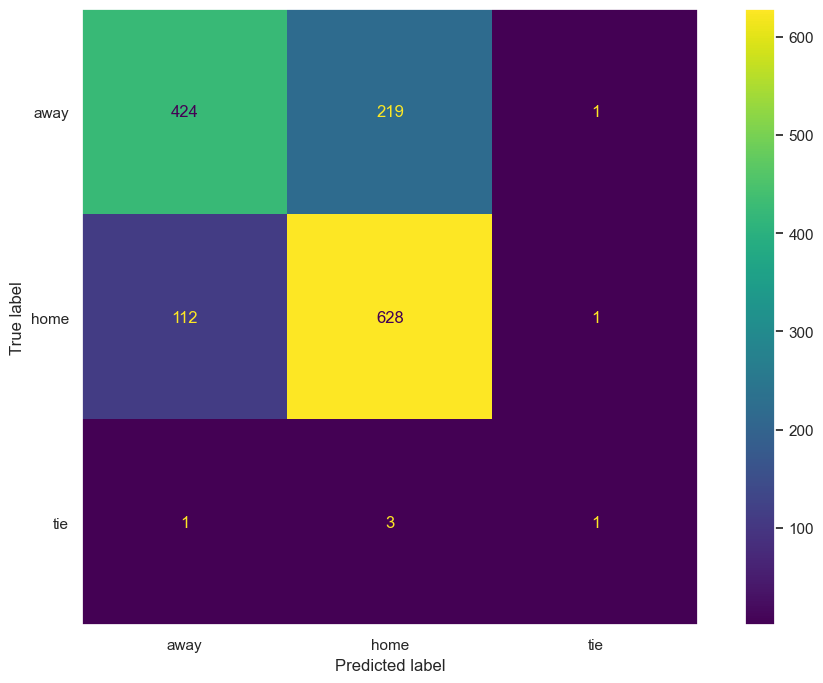

In [125]:
# Predicting the new games
predictions = best_model.predict(new_samples)

# Plotting a confusion matrix with the new predictions
cm_new_samples = confusion_matrix(true_labels, predictions, labels=best_model.classes_)
ConfusionMatrixDisplay(cm_new_samples, display_labels=best_model.classes_).plot()
plt.grid(False)
plt.show()

So, out of 1,309 new games, our model was able to accurately predict 1,053 correct outcomes, which is the equivalent of an accuracy score of:

In [126]:
accuracy_score(true_labels, predictions)

0.7575539568345324

I'd say that's a pretty solid model! But let's check more metrics and see more details about our model performance against unseen data:

In [127]:
# Precision score
precision_score(true_labels, predictions, labels=best_model.classes_, average='weighted')

0.760877031138809

Precision seems fairly consistent to what we've seen across this whole experiment, at 76% for this instance!

In [128]:
# Recall score
recall_score(true_labels, predictions, labels=best_model.classes_, average='weighted')

0.7575539568345324

Recall also stayed consistent with the trends seen throughout the experiment, at almost 76% as well!

In [129]:
# Jaccard index
jaccard_score(true_labels, predictions, labels=best_model.classes_, average='weighted')

0.607661696524229

For this case, we've also calculated the Jaccard Index, or also known as the similarity index, which is the model's ability to predict each instance exactly as it is seen in the true data. In other words, the model's ability to take on one observation and predict exactly the true outcome for that observation.

In our case with this new data, the Jaccard Index indicates a 60% similarity, which means that 60 out of a 100 observations were labelled exactly as the true labels were given. Not an encouraging number for our particular case, but good to see that other metrics performed fairly well.

As a final step, we'll also predict the probabilities of each observation to have any of the labels, and calculate the ROC-AUC score of each class against the other 2:

In [130]:
# Predicting the probabilities for each observation
probs = best_model.predict_proba(new_samples)

# Calculating the ROC-AUC score between true labels and probabilities
roc_auc_score(true_labels, probs, average='weighted', multi_class='ovr', labels=best_model.classes_)

0.822101109810442

The ROC-AUC score for our model tells us that its performance is very solid! It suggests that the model is pretty close of making perfect predictions across the board. However, it is worth noting that our data is fairly imbalanced from a 3-class standpoint, since we have an extremely small sample of ties to compute:

In [131]:
df_new['result'].value_counts()

result
home    741
away    644
tie       5
Name: count, dtype: int64

As we can see, only 5 ties were recorded in the games between 2019 and 2023, and our model managed to predict only 1 out of these 5 ties correctly.

## 9. So what did we learn?

It was a very interesting experiment to perform, and understanding some of the potential key stats to track through a game to predict the likelihood of a team's victory is always a topic of curiosity.

There's plenty of other metrics and stats that can also influence a team's chances of winning, such as the EPA (Expected Points Added) per play, which determines how impactful each play can be towards adding points to the scoreboard, or WPA (Win Probability Added) per play, or the probability of different outcomes in every play (a touchdown, field goal, etc). It can also get as detailed as the environment details, like the weather or the altitude (for playing in places like Denver for example). Notwithstanding, the simple metrics that can be seen in a regular scoreboard can be just as significant, which is why they're shown to the public in the first place, and most teams usually go back to these basic details to improve their performance.

Creating a model like this for the first time was very fun! Especially after going back and forth and attempting different things throughout the coding process and see the difference between results. I've certainly enjoyed dedicating the past 5-6 days fully immersed in this project and am looking forward to starting new projects with other cases of interest!

## 10. What next?

A project like this could take many different angles that at some point I'll probably experiment with. For example, predicting a team's likelihood of winning based on cumulative stats throughout the season, or predicting a team's record based on previous years and in-season stats, or collecting player data and use that to predict a team's performance. Possibilities are plenty!

For now, I'll digest the great feeling of success I've gotten from producing this, and I hope it is something you'll enjoy reading!

As I want to keep developing my journey in the Data Science world, especially around sports, I'm fully open to collaboration with others that are better skilled at programming, or know more about accessible data sources. If anyone would like to get in touch and help each other out in getting better at programming or analysis, please reach out!

Thanks!